##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libdouble-conversion3 libfluidsynth2 libinstpatch-1.0-2
  libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5
  libqt5widgets5 libsdl2-2.0-0 libxcb-xinerama0 libxcb-xinput0 qsynth
  qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity qt5-image-formats-plugins qtwayland5 jackd
  musescore


The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libdouble-conversion3 libfluidsynth2
  libinstpatch-1.0-2 libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5svg5 libqt5widgets5 libsdl2-2.0-0 libxcb-xinerama0
  libxcb-xinput0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont


0 upgraded, 19 newly installed, 0 to remove and 168 not upgraded.


Need to get 136 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libdouble-conversion3 amd64 3.1.5-4ubuntu1 [37.9 kB]
Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcre2-16-0 amd64 10.34-7 [181 kB]
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5core5a amd64 5.12.8+dfsg-0ubuntu2.1 [2006 kB]
2% [3 libqt5core5a 8043 B/2006 kB 0%]

Get:4 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5dbus5 amd64 5.12.8+dfsg-0ubuntu2.1 [208 kB]
Get:5 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5network5 amd64 5.12.8+dfsg-0ubuntu2.1 [673 kB]
Get:6 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libxcb-xinerama0 amd64 1.14-2 [5260 B]
Get:7 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libxcb-xinput0 amd64 1.14-2 [29.3 kB]
Get:8 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5gui5 amd64 5.12.8+dfsg-0ubuntu2.1 [2971 kB]
9% [8 libqt5gui5 4096 B/2971 kB 0%]

Get:9 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5widgets5 amd64 5.12.8+dfsg-0ubuntu2.1 [2295 kB]
Get:10 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]
16% [Waiting for headers]

Get:11 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
16% [11 fluid-soundfont-gm 15.1 kB/119 MB 0%]

20% [11 fluid-soundfont-gm 7502 kB/119 MB 6%]

36% [11 fluid-soundfont-gm 35.4 MB/119 MB 30%]

51% [11 fluid-soundfont-gm 59.5 MB/119 MB 50%]

65% [11 fluid-soundfont-gm 84.7 MB/119 MB 71%]

79% [11 fluid-soundfont-gm 107 MB/119 MB 90%]

85% [11 fluid-soundfont-gm 118 MB/119 MB 99%]

Get:12 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:13 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libsdl2-2.0-0 amd64 2.0.10+dfsg1-3 [407 kB]
Get:14 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5420 kB]
89% [14 timgm6mb-soundfont 45.1 kB/5420 kB 1%]

Get:15 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [198 kB]
95% [Waiting for headers]

Get:16 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluidsynth amd64 2.1.1-2 [25.6 kB]
96% [Waiting for headers]

Get:17 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qsynth amd64 0.6.1-1build1 [245 kB]
96% [17 qsynth 9461 B/245 kB 4%]

Get:18 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 qt5-gtk-platformtheme amd64 5.12.8+dfsg-0ubuntu2.1 [124 kB]
Get:19 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qttranslations5-l10n all 5.12.8-0ubuntu1 [1486 kB]
Fetched 136 MB in 4s (31.5 MB/s)



78Selecting previously unselected package libdouble-conversion3:amd64.


(Reading database ... 139817 files and directories currently installed.)
Preparing to unpack .../00-libdouble-conversion3_3.1.5-4ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  1%] [..........................................................] 8

Unpacking libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [  3%] [#.........................................................] 8Selecting previously unselected package libpcre2-16-0:amd64.
Preparing to unpack .../01-libpcre2-16-0_10.34-7_amd64.deb ...
7Progress: [  4%] [##........................................................] 8Unpacking libpcre2-16-0:amd64 (10.34-7) ...


7Progress: [  5%] [###.......................................................] 8

Selecting previously unselected package libqt5core5a:amd64.
Preparing to unpack .../02-libqt5core5a_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  6%] [###.......................................................] 8Unpacking libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [  8%] [####......................................................] 8

Selecting previously unselected package libqt5dbus5:amd64.
Preparing to unpack .../03-libqt5dbus5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  9%] [#####.....................................................] 8Unpacking libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 10%] [######....................................................] 8Selecting previously unselected package libqt5network5:amd64.
Preparing to unpack .../04-libqt5network5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 12%] [######....................................................] 8Unpacking libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 13%] [#######...................................................] 8Selecting previously unselected package libxcb-xinerama0:amd64.


Preparing to unpack .../05-libxcb-xinerama0_1.14-2_amd64.deb ...
7Progress: [ 14%] [########..................................................] 8Unpacking libxcb-xinerama0:amd64 (1.14-2) ...
7Progress: [ 16%] [#########.................................................] 8Selecting previously unselected package libxcb-xinput0:amd64.
Preparing to unpack .../06-libxcb-xinput0_1.14-2_amd64.deb ...
7Progress: [ 17%] [#########.................................................] 8Unpacking libxcb-xinput0:amd64 (1.14-2) ...


7Progress: [ 18%] [##########................................................] 8Selecting previously unselected package libqt5gui5:amd64.


Preparing to unpack .../07-libqt5gui5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 19%] [###########...............................................] 8Unpacking libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 21%] [############..............................................] 8

Selecting previously unselected package libqt5widgets5:amd64.
Preparing to unpack .../08-libqt5widgets5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 22%] [############..............................................] 8Unpacking libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 23%] [#############.............................................] 8

Selecting previously unselected package libqt5svg5:amd64.
Preparing to unpack .../09-libqt5svg5_5.12.8-0ubuntu1_amd64.deb ...
7Progress: [ 25%] [##############............................................] 8Unpacking libqt5svg5:amd64 (5.12.8-0ubuntu1) ...
7Progress: [ 26%] [###############...........................................] 8

Selecting previously unselected package fluid-soundfont-gm.
Preparing to unpack .../10-fluid-soundfont-gm_3.1-5.1_all.deb ...
7Progress: [ 27%] [###############...........................................] 8Unpacking fluid-soundfont-gm (3.1-5.1) ...


7Progress: [ 29%] [################..........................................] 8Selecting previously unselected package libinstpatch-1.0-2:amd64.


Preparing to unpack .../11-libinstpatch-1.0-2_1.1.2-2build1_amd64.deb ...
7Progress: [ 30%] [#################.........................................] 8Unpacking libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...


7Progress: [ 31%] [##################........................................] 8Selecting previously unselected package libsdl2-2.0-0:amd64.
Preparing to unpack .../12-libsdl2-2.0-0_2.0.10+dfsg1-3_amd64.deb ...
7Progress: [ 32%] [##################........................................] 8Unpacking libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...


7Progress: [ 34%] [###################.......................................] 8

Selecting previously unselected package timgm6mb-soundfont.
Preparing to unpack .../13-timgm6mb-soundfont_1.3-3_all.deb ...
7Progress: [ 35%] [####################......................................] 8Unpacking timgm6mb-soundfont (1.3-3) ...


7Progress: [ 36%] [#####################.....................................] 8Selecting previously unselected package libfluidsynth2:amd64.


Preparing to unpack .../14-libfluidsynth2_2.1.1-2_amd64.deb ...
7Progress: [ 38%] [#####################.....................................] 8Unpacking libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 39%] [######################....................................] 8

Selecting previously unselected package fluidsynth.
Preparing to unpack .../15-fluidsynth_2.1.1-2_amd64.deb ...
7Progress: [ 40%] [#######################...................................] 8Unpacking fluidsynth (2.1.1-2) ...
7Progress: [ 42%] [########################..................................] 8

Selecting previously unselected package qsynth.
Preparing to unpack .../16-qsynth_0.6.1-1build1_amd64.deb ...
7Progress: [ 43%] [########################..................................] 8Unpacking qsynth (0.6.1-1build1) ...


7Progress: [ 44%] [#########################.................................] 8Selecting previously unselected package qt5-gtk-platformtheme:amd64.
Preparing to unpack .../17-qt5-gtk-platformtheme_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...


7Progress: [ 45%] [##########################................................] 8Unpacking qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 47%] [###########################...............................] 8Selecting previously unselected package qttranslations5-l10n.


Preparing to unpack .../18-qttranslations5-l10n_5.12.8-0ubuntu1_all.deb ...
7Progress: [ 48%] [###########################...............................] 8Unpacking qttranslations5-l10n (5.12.8-0ubuntu1) ...


7Progress: [ 49%] [############################..............................] 8

Setting up libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [ 51%] [#############################.............................] 87Progress: [ 52%] [##############################............................] 8Setting up libxcb-xinput0:amd64 (1.14-2) ...
7Progress: [ 53%] [##############################............................] 87Progress: [ 55%] [###############################...........................] 8Setting up libpcre2-16-0:amd64 (10.34-7) ...
7Progress: [ 56%] [################################..........................] 87Progress: [ 57%] [#################################.........................] 8Setting up libxcb-xinerama0:amd64 (1.14-2) ...
7Progress: [ 58%] [#################################.........................] 8

7Progress: [ 60%] [##################################........................] 8Setting up qttranslations5-l10n (5.12.8-0ubuntu1) ...
7Progress: [ 61%] [###################################.......................] 87Progress: [ 62%] [####################################......................] 8Setting up libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 64%] [####################################......................] 87Progress: [ 65%] [#####################################.....................] 8Setting up libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 66%] [######################################....................] 87Progress: [ 68%] [#######################################...................] 8Setting up fluid-soundfont-gm (3.1-5.1) ...
7Progress: [ 69%] [#######################################...................] 87Progress: [ 70%] [########################################..................] 8Setting up libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3)

7Progress: [ 74%] [##########################################................] 8

update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
7Progress: [ 75%] [###########################################...............] 8Setting up libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...
7Progress: [ 77%] [############################################..............] 87Progress: [ 78%] [#############################################.............] 8Setting up libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 79%] [#############################################.............] 87Progress: [ 81%] [##############################################............] 8Setting up libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 82%] [###############################################...........] 87Progress: [ 83%] [#############################################

7Progress: [ 86%] [#################################################.........] 8Setting up libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 87%] [##################################################........] 87Progress: [ 88%] [###################################################.......] 8Setting up qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 90%] [###################################################.......] 87Progress: [ 91%] [####################################################......] 8Setting up fluidsynth (2.1.1-2) ...
7Progress: [ 92%] [#####################################################.....] 8

Created symlink /etc/systemd/user/multi-user.target.wants/fluidsynth.service → /usr/lib/systemd/user/fluidsynth.service.
7Progress: [ 94%] [######################################################....] 8Setting up libqt5svg5:amd64 (5.12.8-0ubuntu1) ...
7Progress: [ 95%] [######################################################....] 8

7Progress: [ 96%] [#######################################################...] 8Setting up qsynth (0.6.1-1build1) ...
7Progress: [ 97%] [########################################################..] 87Progress: [ 99%] [#########################################################.] 8Processing triggers for desktop-file-utils (0.24-1ubuntu3) ...
Processing triggers for mime-support (3.64ubuntu1) ...
Processing triggers for hicolor-icon-theme (0.17-2) ...


Processing triggers for gnome-menus (3.36.0-1ubuntu1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.7) ...


Processing triggers for man-db (2.9.1-1) ...



78

In [3]:
!pip install --upgrade pyfluidsynth

In [4]:
!pip install pretty_midi

  Preparing metadata (setup.py) ... -

 \

 |

 done


 \

 |

 /

 -

 \

 |

 done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591938 sha256=6a00b8325b2a39692363c90fd56fa22b4bb6e41af4de237565562dbdfe80dc17
  Stored in directory: /home/kbuilder/.cache/pip/wheels/f0/3e/3d/126d7680aae66f3baed077a43a77b91f86e1b4a887fd703cc6
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

    8192/59243107 [..............................] - ETA: 0s

 4202496/59243107 [=>............................] - ETA: 0s

19070976/59243107 [========>.....................] - ETA: 0s

37224448/59243107 [=================>............] - ETA: 0s

54878208/59243107 [==========================>...] - ETA: 0s

59243107/59243107 [==============================] - 0s 0us/step


The dataset contains about 1,200 MIDI files.

In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_04_Track04_wav.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


Do some inspection on the MIDI file. What kinds of instruments are used?

In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=62, note_name=D4, duration=0.0417
1: pitch=66, note_name=F#4, duration=0.0375
2: pitch=66, note_name=F#4, duration=0.0542
3: pitch=57, note_name=A3, duration=0.0396
4: pitch=62, note_name=D4, duration=0.0396
5: pitch=66, note_name=F#4, duration=0.0365
6: pitch=66, note_name=F#4, duration=0.0354
7: pitch=57, note_name=A3, duration=0.0354
8: pitch=62, note_name=D4, duration=0.0375
9: pitch=66, note_name=F#4, duration=0.0427


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,62,0.148958,0.190625,0.000000,0.041667
1,66,0.154167,0.191667,0.005208,0.037500
2,66,0.652083,0.706250,0.497917,0.054167
3,57,0.676042,0.715625,0.023958,0.039583
4,62,1.189583,1.229167,0.513542,0.039583


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D4', 'F#4', 'F#4', 'A3', 'D4', 'F#4', 'F#4', 'A3', 'A5', 'F#4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

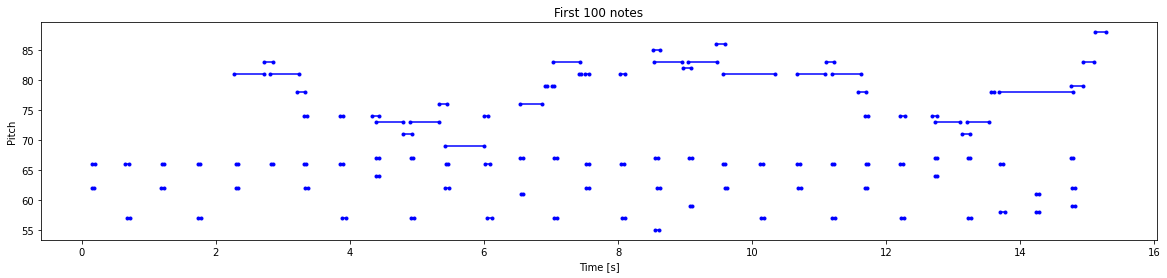

In [19]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

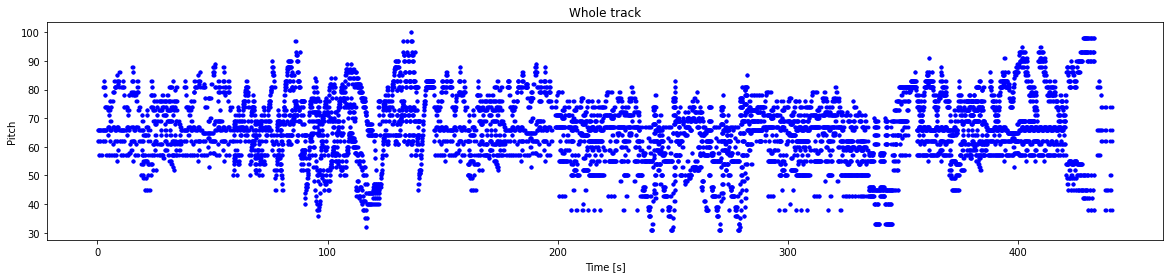

In [20]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

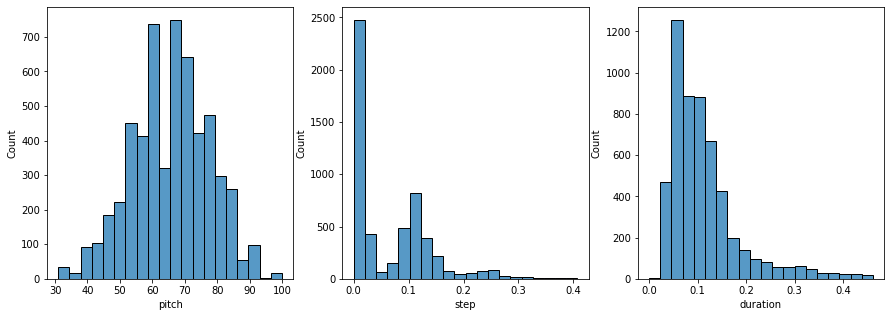

In [22]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [25]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 20968


Next, create a `tf.data.Dataset` from the parsed notes.

In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4921875  0.         0.065625  ]
 [0.5078125  0.08854167 0.06666667]
 [0.4921875  0.07916667 0.06979167]
 [0.484375   0.05625    0.028125  ]
 [0.4921875  0.29583333 0.03333333]
 [0.5078125  0.18645833 0.05      ]
 [0.4921875  0.14583333 0.04583333]
 [0.4765625  0.13333333 1.803125  ]
 [0.5078125  0.00208333 0.0625    ]
 [0.4921875  0.14375    0.04166667]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=62.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.18333333333333313>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.04270833333333357>}


Batch the examples, and configure the dataset for performance.

In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               


 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                


 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   


 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   


 step (Dense)                   (None, 1)            129         ['lstm[0][0]']                   


Total params: 84,354


Trainable params: 84,354


Non-trainable params: 0


__________________________________________________________________________________________________


Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

      1/Unknown - 5s 5s/step - loss: 4.9012 - duration_loss: 0.0376 - pitch_loss: 4.8462 - step_loss: 0.0174

     19/Unknown - 5s 3ms/step - loss: 5.0246 - duration_loss: 0.1467 - pitch_loss: 4.8459 - step_loss: 0.0320

     38/Unknown - 5s 3ms/step - loss: 5.0069 - duration_loss: 0.1314 - pitch_loss: 4.8467 - step_loss: 0.0288

     57/Unknown - 5s 3ms/step - loss: 4.9992 - duration_loss: 0.1264 - pitch_loss: 4.8461 - step_loss: 0.0266

     76/Unknown - 5s 3ms/step - loss: 4.9914 - duration_loss: 0.1209 - pitch_loss: 4.8459 - step_loss: 0.0246

     95/Unknown - 5s 3ms/step - loss: 5.0001 - duration_loss: 0.1269 - pitch_loss: 4.8458 - step_loss: 0.0274

    114/Unknown - 5s 3ms/step - loss: 5.0062 - duration_loss: 0.1302 - pitch_loss: 4.8458 - step_loss: 0.0303

    134/Unknown - 5s 3ms/step - loss: 5.0139 - duration_loss: 0.1337 - pitch_loss: 4.8456 - step_loss: 0.0346

    153/Unknown - 5s 3ms/step - loss: 5.0237 - duration_loss: 0.1436 - pitch_loss: 4.8456 - step_loss: 0.0346

    172/Unknown - 5s 3ms/step - loss: 5.0254 - duration_loss: 0.1465 - pitch_loss: 4.8457 - step_loss: 0.0333

    191/Unknown - 5s 3ms/step - loss: 5.0306 - duration_loss: 0.1519 - pitch_loss: 4.8456 - step_loss: 0.0331

    210/Unknown - 5s 3ms/step - loss: 5.0307 - duration_loss: 0.1522 - pitch_loss: 4.8456 - step_loss: 0.0329

    229/Unknown - 5s 3ms/step - loss: 5.0304 - duration_loss: 0.1517 - pitch_loss: 4.8456 - step_loss: 0.0330

    248/Unknown - 5s 3ms/step - loss: 5.0273 - duration_loss: 0.1493 - pitch_loss: 4.8457 - step_loss: 0.0324

    267/Unknown - 6s 3ms/step - loss: 5.0273 - duration_loss: 0.1493 - pitch_loss: 4.8456 - step_loss: 0.0324

    287/Unknown - 6s 3ms/step - loss: 5.0240 - duration_loss: 0.1469 - pitch_loss: 4.8457 - step_loss: 0.0314

    307/Unknown - 6s 3ms/step - loss: 5.0224 - duration_loss: 0.1462 - pitch_loss: 4.8457 - step_loss: 0.0305

327/327 [==============================] - 6s 3ms/step - loss: 5.0227 - duration_loss: 0.1470 - pitch_loss: 4.8455 - step_loss: 0.0302


{'loss': 5.022714614868164,
 'duration_loss': 0.14702337980270386,
 'pitch_loss': 4.845539093017578,
 'step_loss': 0.03015401028096676}

One way balance this is to use the `loss_weights` argument to compile:

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [39]:
model.evaluate(train_ds, return_dict=True)

      1/Unknown - 1s 736ms/step - loss: 0.2973 - duration_loss: 0.0376 - pitch_loss: 4.8462 - step_loss: 0.0174

     19/Unknown - 1s 3ms/step - loss: 0.4210 - duration_loss: 0.1467 - pitch_loss: 4.8459 - step_loss: 0.0320  

     38/Unknown - 1s 3ms/step - loss: 0.4025 - duration_loss: 0.1314 - pitch_loss: 4.8467 - step_loss: 0.0288

     57/Unknown - 1s 3ms/step - loss: 0.3954 - duration_loss: 0.1264 - pitch_loss: 4.8461 - step_loss: 0.0266

     76/Unknown - 1s 3ms/step - loss: 0.3878 - duration_loss: 0.1209 - pitch_loss: 4.8459 - step_loss: 0.0246

     96/Unknown - 1s 3ms/step - loss: 0.3960 - duration_loss: 0.1265 - pitch_loss: 4.8458 - step_loss: 0.0272

    115/Unknown - 1s 3ms/step - loss: 0.4023 - duration_loss: 0.1300 - pitch_loss: 4.8457 - step_loss: 0.0301

    134/Unknown - 1s 3ms/step - loss: 0.4106 - duration_loss: 0.1337 - pitch_loss: 4.8456 - step_loss: 0.0346

    154/Unknown - 1s 3ms/step - loss: 0.4199 - duration_loss: 0.1432 - pitch_loss: 4.8456 - step_loss: 0.0344

    174/Unknown - 1s 3ms/step - loss: 0.4235 - duration_loss: 0.1473 - pitch_loss: 4.8457 - step_loss: 0.0339

    194/Unknown - 1s 3ms/step - loss: 0.4283 - duration_loss: 0.1532 - pitch_loss: 4.8456 - step_loss: 0.0328

    214/Unknown - 1s 3ms/step - loss: 0.4285 - duration_loss: 0.1527 - pitch_loss: 4.8456 - step_loss: 0.0335

    233/Unknown - 1s 3ms/step - loss: 0.4259 - duration_loss: 0.1509 - pitch_loss: 4.8456 - step_loss: 0.0327

    252/Unknown - 1s 3ms/step - loss: 0.4240 - duration_loss: 0.1487 - pitch_loss: 4.8456 - step_loss: 0.0331

    272/Unknown - 1s 3ms/step - loss: 0.4223 - duration_loss: 0.1479 - pitch_loss: 4.8456 - step_loss: 0.0321

    292/Unknown - 2s 3ms/step - loss: 0.4210 - duration_loss: 0.1475 - pitch_loss: 4.8457 - step_loss: 0.0312

    312/Unknown - 2s 3ms/step - loss: 0.4190 - duration_loss: 0.1461 - pitch_loss: 4.8456 - step_loss: 0.0306

327/327 [==============================] - 2s 3ms/step - loss: 0.4195 - duration_loss: 0.1470 - pitch_loss: 4.8455 - step_loss: 0.0302


{'loss': 0.41945430636405945,
 'duration_loss': 0.14702337980270386,
 'pitch_loss': 4.845539093017578,
 'step_loss': 0.03015401028096676}

Train the model.

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


      1/Unknown - 2s 2s/step - loss: 0.2973 - duration_loss: 0.0376 - pitch_loss: 4.8462 - step_loss: 0.0174

     14/Unknown - 2s 4ms/step - loss: 0.3566 - duration_loss: 0.0937 - pitch_loss: 4.7692 - step_loss: 0.0245

     27/Unknown - 2s 4ms/step - loss: 0.3740 - duration_loss: 0.1120 - pitch_loss: 4.6941 - step_loss: 0.0273

     40/Unknown - 2s 4ms/step - loss: 0.3511 - duration_loss: 0.0959 - pitch_loss: 4.6084 - step_loss: 0.0248

     53/Unknown - 2s 4ms/step - loss: 0.3517 - duration_loss: 0.1036 - pitch_loss: 4.4854 - step_loss: 0.0238

     66/Unknown - 2s 4ms/step - loss: 0.3425 - duration_loss: 0.0982 - pitch_loss: 4.4414 - step_loss: 0.0222

     80/Unknown - 2s 4ms/step - loss: 0.3349 - duration_loss: 0.0945 - pitch_loss: 4.3512 - step_loss: 0.0229

     93/Unknown - 2s 4ms/step - loss: 0.3306 - duration_loss: 0.0938 - pitch_loss: 4.2784 - step_loss: 0.0229

    106/Unknown - 2s 4ms/step - loss: 0.3271 - duration_loss: 0.0941 - pitch_loss: 4.2171 - step_loss: 0.0222

    119/Unknown - 2s 4ms/step - loss: 0.3347 - duration_loss: 0.0993 - pitch_loss: 4.1735 - step_loss: 0.0268

    132/Unknown - 2s 4ms/step - loss: 0.3360 - duration_loss: 0.1004 - pitch_loss: 4.1375 - step_loss: 0.0287

    145/Unknown - 2s 4ms/step - loss: 0.3381 - duration_loss: 0.1036 - pitch_loss: 4.1046 - step_loss: 0.0292

    158/Unknown - 2s 4ms/step - loss: 0.3377 - duration_loss: 0.1055 - pitch_loss: 4.0789 - step_loss: 0.0282

    171/Unknown - 2s 4ms/step - loss: 0.3361 - duration_loss: 0.1058 - pitch_loss: 4.0538 - step_loss: 0.0277

    184/Unknown - 3s 4ms/step - loss: 0.3363 - duration_loss: 0.1073 - pitch_loss: 4.0310 - step_loss: 0.0274

    197/Unknown - 3s 4ms/step - loss: 0.3361 - duration_loss: 0.1085 - pitch_loss: 4.0121 - step_loss: 0.0270

    210/Unknown - 3s 4ms/step - loss: 0.3350 - duration_loss: 0.1078 - pitch_loss: 3.9969 - step_loss: 0.0274

    223/Unknown - 3s 4ms/step - loss: 0.3352 - duration_loss: 0.1081 - pitch_loss: 3.9839 - step_loss: 0.0279

    236/Unknown - 3s 4ms/step - loss: 0.3315 - duration_loss: 0.1060 - pitch_loss: 3.9687 - step_loss: 0.0271

    249/Unknown - 3s 4ms/step - loss: 0.3312 - duration_loss: 0.1054 - pitch_loss: 3.9605 - step_loss: 0.0278

    262/Unknown - 3s 4ms/step - loss: 0.3300 - duration_loss: 0.1052 - pitch_loss: 3.9504 - step_loss: 0.0273

    276/Unknown - 3s 4ms/step - loss: 0.3284 - duration_loss: 0.1047 - pitch_loss: 3.9395 - step_loss: 0.0268

    290/Unknown - 3s 4ms/step - loss: 0.3253 - duration_loss: 0.1028 - pitch_loss: 3.9293 - step_loss: 0.0260

    303/Unknown - 3s 4ms/step - loss: 0.3240 - duration_loss: 0.1024 - pitch_loss: 3.9229 - step_loss: 0.0255

    317/Unknown - 3s 4ms/step - loss: 0.3219 - duration_loss: 0.1010 - pitch_loss: 3.9149 - step_loss: 0.0252

327/327 [==============================] - 3s 4ms/step - loss: 0.3230 - duration_loss: 0.1025 - pitch_loss: 3.9105 - step_loss: 0.0250


Epoch 2/50


  1/327 [..............................] - ETA: 1s - loss: 0.2318 - duration_loss: 0.0280 - pitch_loss: 3.8132 - step_loss: 0.0131

 15/327 [>.............................] - ETA: 1s - loss: 0.3257 - duration_loss: 0.1186 - pitch_loss: 3.7589 - step_loss: 0.0191

 29/327 [=>............................] - ETA: 1s - loss: 0.3134 - duration_loss: 0.1020 - pitch_loss: 3.7518 - step_loss: 0.0238

 42/327 [==>...........................] - ETA: 1s - loss: 0.3016 - duration_loss: 0.0914 - pitch_loss: 3.7646 - step_loss: 0.0220

 56/327 [====>.........................] - ETA: 1s - loss: 0.3006 - duration_loss: 0.0909 - pitch_loss: 3.7745 - step_loss: 0.0210

 70/327 [=====>........................] - ETA: 0s - loss: 0.2934 - duration_loss: 0.0854 - pitch_loss: 3.7682 - step_loss: 0.0196

 84/327 [======>.......................] - ETA: 0s - loss: 0.2948 - duration_loss: 0.0859 - pitch_loss: 3.7614 - step_loss: 0.0209

 98/327 [=======>......................] - ETA: 0s - loss: 0.2954 - duration_loss: 0.0863 - pitch_loss: 3.7620 - step_loss: 0.0211

112/327 [=========>....................] - ETA: 0s - loss: 0.3017 - duration_loss: 0.0904 - pitch_loss: 3.7565 - step_loss: 0.0234

126/327 [==========>...................] - ETA: 0s - loss: 0.3078 - duration_loss: 0.0927 - pitch_loss: 3.7585 - step_loss: 0.0271

140/327 [===========>..................] - ETA: 0s - loss: 0.3108 - duration_loss: 0.0951 - pitch_loss: 3.7602 - step_loss: 0.0276

154/327 [=============>................] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0981 - pitch_loss: 3.7582 - step_loss: 0.0273

168/327 [==============>...............] - ETA: 0s - loss: 0.3124 - duration_loss: 0.0982 - pitch_loss: 3.7542 - step_loss: 0.0265

182/327 [===============>..............] - ETA: 0s - loss: 0.3156 - duration_loss: 0.1016 - pitch_loss: 3.7508 - step_loss: 0.0264

196/327 [================>.............] - ETA: 0s - loss: 0.3158 - duration_loss: 0.1024 - pitch_loss: 3.7474 - step_loss: 0.0260

210/327 [==================>...........] - ETA: 0s - loss: 0.3163 - duration_loss: 0.1026 - pitch_loss: 3.7471 - step_loss: 0.0264

224/327 [===================>..........] - ETA: 0s - loss: 0.3174 - duration_loss: 0.1033 - pitch_loss: 3.7466 - step_loss: 0.0268

238/327 [====================>.........] - ETA: 0s - loss: 0.3143 - duration_loss: 0.1007 - pitch_loss: 3.7452 - step_loss: 0.0263

252/327 [======================>.......] - ETA: 0s - loss: 0.3145 - duration_loss: 0.1004 - pitch_loss: 3.7461 - step_loss: 0.0267

266/327 [=======================>......] - ETA: 0s - loss: 0.3148 - duration_loss: 0.1014 - pitch_loss: 3.7459 - step_loss: 0.0261

280/327 [========================>.....] - ETA: 0s - loss: 0.3134 - duration_loss: 0.1005 - pitch_loss: 3.7444 - step_loss: 0.0257

294/327 [=========================>....] - ETA: 0s - loss: 0.3117 - duration_loss: 0.0994 - pitch_loss: 3.7438 - step_loss: 0.0251

308/327 [===========================>..] - ETA: 0s - loss: 0.3099 - duration_loss: 0.0980 - pitch_loss: 3.7430 - step_loss: 0.0248

321/327 [============================>.] - ETA: 0s - loss: 0.3091 - duration_loss: 0.0975 - pitch_loss: 3.7430 - step_loss: 0.0244

327/327 [==============================] - 1s 4ms/step - loss: 0.3103 - duration_loss: 0.0988 - pitch_loss: 3.7435 - step_loss: 0.0243


Epoch 3/50


  1/327 [..............................] - ETA: 1s - loss: 0.2311 - duration_loss: 0.0288 - pitch_loss: 3.7992 - step_loss: 0.0123

 14/327 [>.............................] - ETA: 1s - loss: 0.2927 - duration_loss: 0.0858 - pitch_loss: 3.7526 - step_loss: 0.0192

 28/327 [=>............................] - ETA: 1s - loss: 0.3151 - duration_loss: 0.1046 - pitch_loss: 3.7357 - step_loss: 0.0237

 42/327 [==>...........................] - ETA: 1s - loss: 0.2996 - duration_loss: 0.0909 - pitch_loss: 3.7491 - step_loss: 0.0213

 55/327 [====>.........................] - ETA: 1s - loss: 0.2984 - duration_loss: 0.0902 - pitch_loss: 3.7592 - step_loss: 0.0203

 69/327 [=====>........................] - ETA: 0s - loss: 0.2910 - duration_loss: 0.0844 - pitch_loss: 3.7510 - step_loss: 0.0191

 82/327 [======>.......................] - ETA: 0s - loss: 0.2913 - duration_loss: 0.0840 - pitch_loss: 3.7447 - step_loss: 0.0200

 95/327 [=======>......................] - ETA: 0s - loss: 0.2953 - duration_loss: 0.0874 - pitch_loss: 3.7447 - step_loss: 0.0207

109/327 [=========>....................] - ETA: 0s - loss: 0.2998 - duration_loss: 0.0904 - pitch_loss: 3.7393 - step_loss: 0.0224

123/327 [==========>...................] - ETA: 0s - loss: 0.3028 - duration_loss: 0.0913 - pitch_loss: 3.7399 - step_loss: 0.0244

137/327 [===========>..................] - ETA: 0s - loss: 0.3063 - duration_loss: 0.0923 - pitch_loss: 3.7415 - step_loss: 0.0269

150/327 [============>.................] - ETA: 0s - loss: 0.3099 - duration_loss: 0.0961 - pitch_loss: 3.7379 - step_loss: 0.0269

164/327 [==============>...............] - ETA: 0s - loss: 0.3108 - duration_loss: 0.0978 - pitch_loss: 3.7371 - step_loss: 0.0261

178/327 [===============>..............] - ETA: 0s - loss: 0.3132 - duration_loss: 0.1005 - pitch_loss: 3.7326 - step_loss: 0.0261

192/327 [================>.............] - ETA: 0s - loss: 0.3142 - duration_loss: 0.1020 - pitch_loss: 3.7309 - step_loss: 0.0256

206/327 [=================>............] - ETA: 0s - loss: 0.3152 - duration_loss: 0.1026 - pitch_loss: 3.7298 - step_loss: 0.0261

219/327 [===================>..........] - ETA: 0s - loss: 0.3153 - duration_loss: 0.1028 - pitch_loss: 3.7279 - step_loss: 0.0262

233/327 [====================>.........] - ETA: 0s - loss: 0.3136 - duration_loss: 0.1015 - pitch_loss: 3.7250 - step_loss: 0.0259

247/327 [=====================>........] - ETA: 0s - loss: 0.3106 - duration_loss: 0.0988 - pitch_loss: 3.7265 - step_loss: 0.0254

261/327 [======================>.......] - ETA: 0s - loss: 0.3129 - duration_loss: 0.1007 - pitch_loss: 3.7254 - step_loss: 0.0260

275/327 [========================>.....] - ETA: 0s - loss: 0.3119 - duration_loss: 0.1002 - pitch_loss: 3.7239 - step_loss: 0.0255

289/327 [=========================>....] - ETA: 0s - loss: 0.3092 - duration_loss: 0.0983 - pitch_loss: 3.7209 - step_loss: 0.0249

303/327 [==========================>...] - ETA: 0s - loss: 0.3084 - duration_loss: 0.0980 - pitch_loss: 3.7210 - step_loss: 0.0243

317/327 [============================>.] - ETA: 0s - loss: 0.3068 - duration_loss: 0.0968 - pitch_loss: 3.7185 - step_loss: 0.0241

327/327 [==============================] - 1s 4ms/step - loss: 0.3084 - duration_loss: 0.0984 - pitch_loss: 3.7210 - step_loss: 0.0240


Epoch 4/50


  1/327 [..............................] - ETA: 1s - loss: 0.2298 - duration_loss: 0.0270 - pitch_loss: 3.8175 - step_loss: 0.0119

 15/327 [>.............................] - ETA: 1s - loss: 0.3235 - duration_loss: 0.1173 - pitch_loss: 3.7445 - step_loss: 0.0190

 29/327 [=>............................] - ETA: 1s - loss: 0.3105 - duration_loss: 0.1007 - pitch_loss: 3.7335 - step_loss: 0.0231

 43/327 [==>...........................] - ETA: 1s - loss: 0.2989 - duration_loss: 0.0901 - pitch_loss: 3.7425 - step_loss: 0.0216

 57/327 [====>.........................] - ETA: 1s - loss: 0.2976 - duration_loss: 0.0893 - pitch_loss: 3.7526 - step_loss: 0.0206

 71/327 [=====>........................] - ETA: 0s - loss: 0.2916 - duration_loss: 0.0849 - pitch_loss: 3.7476 - step_loss: 0.0193

 85/327 [======>.......................] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0843 - pitch_loss: 3.7413 - step_loss: 0.0204

 99/327 [========>.....................] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0863 - pitch_loss: 3.7410 - step_loss: 0.0207

112/327 [=========>....................] - ETA: 0s - loss: 0.2993 - duration_loss: 0.0895 - pitch_loss: 3.7350 - step_loss: 0.0230

126/327 [==========>...................] - ETA: 0s - loss: 0.3050 - duration_loss: 0.0916 - pitch_loss: 3.7372 - step_loss: 0.0266

140/327 [===========>..................] - ETA: 0s - loss: 0.3078 - duration_loss: 0.0937 - pitch_loss: 3.7381 - step_loss: 0.0272

154/327 [=============>................] - ETA: 0s - loss: 0.3103 - duration_loss: 0.0968 - pitch_loss: 3.7355 - step_loss: 0.0268

167/327 [==============>...............] - ETA: 0s - loss: 0.3094 - duration_loss: 0.0969 - pitch_loss: 3.7308 - step_loss: 0.0260

181/327 [===============>..............] - ETA: 0s - loss: 0.3127 - duration_loss: 0.1005 - pitch_loss: 3.7264 - step_loss: 0.0259

195/327 [================>.............] - ETA: 0s - loss: 0.3128 - duration_loss: 0.1010 - pitch_loss: 3.7230 - step_loss: 0.0256

209/327 [==================>...........] - ETA: 0s - loss: 0.3136 - duration_loss: 0.1015 - pitch_loss: 3.7228 - step_loss: 0.0260

223/327 [===================>..........] - ETA: 0s - loss: 0.3143 - duration_loss: 0.1017 - pitch_loss: 3.7235 - step_loss: 0.0264

237/327 [====================>.........] - ETA: 0s - loss: 0.3113 - duration_loss: 0.0996 - pitch_loss: 3.7215 - step_loss: 0.0256

251/327 [======================>.......] - ETA: 0s - loss: 0.3118 - duration_loss: 0.0994 - pitch_loss: 3.7217 - step_loss: 0.0263

265/327 [=======================>......] - ETA: 0s - loss: 0.3122 - duration_loss: 0.1006 - pitch_loss: 3.7202 - step_loss: 0.0257

279/327 [========================>.....] - ETA: 0s - loss: 0.3100 - duration_loss: 0.0988 - pitch_loss: 3.7188 - step_loss: 0.0253

293/327 [=========================>....] - ETA: 0s - loss: 0.3089 - duration_loss: 0.0984 - pitch_loss: 3.7172 - step_loss: 0.0246

306/327 [===========================>..] - ETA: 0s - loss: 0.3072 - duration_loss: 0.0972 - pitch_loss: 3.7171 - step_loss: 0.0241

320/327 [============================>.] - ETA: 0s - loss: 0.3063 - duration_loss: 0.0966 - pitch_loss: 3.7158 - step_loss: 0.0240

327/327 [==============================] - 1s 4ms/step - loss: 0.3073 - duration_loss: 0.0978 - pitch_loss: 3.7164 - step_loss: 0.0238


Epoch 5/50


  1/327 [..............................] - ETA: 1s - loss: 0.2241 - duration_loss: 0.0229 - pitch_loss: 3.7696 - step_loss: 0.0128

 15/327 [>.............................] - ETA: 1s - loss: 0.3222 - duration_loss: 0.1177 - pitch_loss: 3.7117 - step_loss: 0.0189

 28/327 [=>............................] - ETA: 1s - loss: 0.3117 - duration_loss: 0.1036 - pitch_loss: 3.6994 - step_loss: 0.0232

 41/327 [==>...........................] - ETA: 1s - loss: 0.2984 - duration_loss: 0.0918 - pitch_loss: 3.7084 - step_loss: 0.0212

 55/327 [====>.........................] - ETA: 1s - loss: 0.2961 - duration_loss: 0.0896 - pitch_loss: 3.7158 - step_loss: 0.0207

 69/327 [=====>........................] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0839 - pitch_loss: 3.7060 - step_loss: 0.0196

 83/327 [======>.......................] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0828 - pitch_loss: 3.6996 - step_loss: 0.0203

 97/327 [=======>......................] - ETA: 0s - loss: 0.2916 - duration_loss: 0.0859 - pitch_loss: 3.6960 - step_loss: 0.0209

111/327 [=========>....................] - ETA: 0s - loss: 0.2969 - duration_loss: 0.0895 - pitch_loss: 3.6925 - step_loss: 0.0228

125/327 [==========>...................] - ETA: 0s - loss: 0.3022 - duration_loss: 0.0911 - pitch_loss: 3.6942 - step_loss: 0.0263

139/327 [===========>..................] - ETA: 0s - loss: 0.3045 - duration_loss: 0.0927 - pitch_loss: 3.6943 - step_loss: 0.0271

153/327 [=============>................] - ETA: 0s - loss: 0.3079 - duration_loss: 0.0965 - pitch_loss: 3.6918 - step_loss: 0.0268

166/327 [==============>...............] - ETA: 0s - loss: 0.3071 - duration_loss: 0.0967 - pitch_loss: 3.6897 - step_loss: 0.0260

179/327 [===============>..............] - ETA: 0s - loss: 0.3098 - duration_loss: 0.0996 - pitch_loss: 3.6851 - step_loss: 0.0259

192/327 [================>.............] - ETA: 0s - loss: 0.3106 - duration_loss: 0.1010 - pitch_loss: 3.6838 - step_loss: 0.0254

205/327 [=================>............] - ETA: 0s - loss: 0.3110 - duration_loss: 0.1009 - pitch_loss: 3.6825 - step_loss: 0.0260

219/327 [===================>..........] - ETA: 0s - loss: 0.3113 - duration_loss: 0.1013 - pitch_loss: 3.6822 - step_loss: 0.0259

233/327 [====================>.........] - ETA: 0s - loss: 0.3097 - duration_loss: 0.1001 - pitch_loss: 3.6797 - step_loss: 0.0256

247/327 [=====================>........] - ETA: 0s - loss: 0.3066 - duration_loss: 0.0975 - pitch_loss: 3.6807 - step_loss: 0.0251

261/327 [======================>.......] - ETA: 0s - loss: 0.3090 - duration_loss: 0.0994 - pitch_loss: 3.6793 - step_loss: 0.0256

275/327 [========================>.....] - ETA: 0s - loss: 0.3080 - duration_loss: 0.0989 - pitch_loss: 3.6780 - step_loss: 0.0252

288/327 [=========================>....] - ETA: 0s - loss: 0.3056 - duration_loss: 0.0972 - pitch_loss: 3.6751 - step_loss: 0.0246

302/327 [==========================>...] - ETA: 0s - loss: 0.3046 - duration_loss: 0.0968 - pitch_loss: 3.6748 - step_loss: 0.0241

315/327 [===========================>..] - ETA: 0s - loss: 0.3030 - duration_loss: 0.0956 - pitch_loss: 3.6720 - step_loss: 0.0239

327/327 [==============================] - 1s 4ms/step - loss: 0.3044 - duration_loss: 0.0971 - pitch_loss: 3.6720 - step_loss: 0.0237


Epoch 6/50


  1/327 [..............................] - ETA: 1s - loss: 0.2211 - duration_loss: 0.0237 - pitch_loss: 3.6908 - step_loss: 0.0128

 14/327 [>.............................] - ETA: 1s - loss: 0.2857 - duration_loss: 0.0845 - pitch_loss: 3.6381 - step_loss: 0.0192

 27/327 [=>............................] - ETA: 1s - loss: 0.3091 - duration_loss: 0.1040 - pitch_loss: 3.6309 - step_loss: 0.0235

 41/327 [==>...........................] - ETA: 1s - loss: 0.2947 - duration_loss: 0.0916 - pitch_loss: 3.6405 - step_loss: 0.0211

 55/327 [====>.........................] - ETA: 1s - loss: 0.2917 - duration_loss: 0.0895 - pitch_loss: 3.6479 - step_loss: 0.0198

 69/327 [=====>........................] - ETA: 0s - loss: 0.2844 - duration_loss: 0.0836 - pitch_loss: 3.6436 - step_loss: 0.0186

 83/327 [======>.......................] - ETA: 0s - loss: 0.2840 - duration_loss: 0.0826 - pitch_loss: 3.6414 - step_loss: 0.0193

 97/327 [=======>......................] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0856 - pitch_loss: 3.6394 - step_loss: 0.0199

111/327 [=========>....................] - ETA: 0s - loss: 0.2927 - duration_loss: 0.0888 - pitch_loss: 3.6377 - step_loss: 0.0220

125/327 [==========>...................] - ETA: 0s - loss: 0.2976 - duration_loss: 0.0904 - pitch_loss: 3.6398 - step_loss: 0.0252

139/327 [===========>..................] - ETA: 0s - loss: 0.3001 - duration_loss: 0.0921 - pitch_loss: 3.6416 - step_loss: 0.0259

153/327 [=============>................] - ETA: 0s - loss: 0.3037 - duration_loss: 0.0958 - pitch_loss: 3.6416 - step_loss: 0.0258

167/327 [==============>...............] - ETA: 0s - loss: 0.3031 - duration_loss: 0.0960 - pitch_loss: 3.6406 - step_loss: 0.0251

181/327 [===============>..............] - ETA: 0s - loss: 0.3064 - duration_loss: 0.0995 - pitch_loss: 3.6386 - step_loss: 0.0250

195/327 [================>.............] - ETA: 0s - loss: 0.3064 - duration_loss: 0.0999 - pitch_loss: 3.6374 - step_loss: 0.0246

209/327 [==================>...........] - ETA: 0s - loss: 0.3069 - duration_loss: 0.0998 - pitch_loss: 3.6401 - step_loss: 0.0251

222/327 [===================>..........] - ETA: 0s - loss: 0.3077 - duration_loss: 0.1000 - pitch_loss: 3.6431 - step_loss: 0.0255

235/327 [====================>.........] - ETA: 0s - loss: 0.3055 - duration_loss: 0.0985 - pitch_loss: 3.6420 - step_loss: 0.0249

249/327 [=====================>........] - ETA: 0s - loss: 0.3061 - duration_loss: 0.0982 - pitch_loss: 3.6454 - step_loss: 0.0256

263/327 [=======================>......] - ETA: 0s - loss: 0.3055 - duration_loss: 0.0983 - pitch_loss: 3.6439 - step_loss: 0.0250

277/327 [========================>.....] - ETA: 0s - loss: 0.3045 - duration_loss: 0.0977 - pitch_loss: 3.6435 - step_loss: 0.0246

291/327 [=========================>....] - ETA: 0s - loss: 0.3030 - duration_loss: 0.0969 - pitch_loss: 3.6421 - step_loss: 0.0240

305/327 [==========================>...] - ETA: 0s - loss: 0.3014 - duration_loss: 0.0958 - pitch_loss: 3.6413 - step_loss: 0.0235

319/327 [============================>.] - ETA: 0s - loss: 0.3006 - duration_loss: 0.0954 - pitch_loss: 3.6394 - step_loss: 0.0232

327/327 [==============================] - 1s 4ms/step - loss: 0.3016 - duration_loss: 0.0964 - pitch_loss: 3.6405 - step_loss: 0.0232


Epoch 7/50


  1/327 [..............................] - ETA: 1s - loss: 0.2221 - duration_loss: 0.0258 - pitch_loss: 3.6798 - step_loss: 0.0123

 14/327 [>.............................] - ETA: 1s - loss: 0.2844 - duration_loss: 0.0835 - pitch_loss: 3.6274 - step_loss: 0.0196

 28/327 [=>............................] - ETA: 1s - loss: 0.3055 - duration_loss: 0.1017 - pitch_loss: 3.6134 - step_loss: 0.0231

 42/327 [==>...........................] - ETA: 1s - loss: 0.2915 - duration_loss: 0.0895 - pitch_loss: 3.6254 - step_loss: 0.0208

 56/327 [====>.........................] - ETA: 1s - loss: 0.2903 - duration_loss: 0.0891 - pitch_loss: 3.6297 - step_loss: 0.0198

 70/327 [=====>........................] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0837 - pitch_loss: 3.6256 - step_loss: 0.0185

 84/327 [======>.......................] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0841 - pitch_loss: 3.6216 - step_loss: 0.0195

 98/327 [=======>......................] - ETA: 0s - loss: 0.2850 - duration_loss: 0.0843 - pitch_loss: 3.6201 - step_loss: 0.0197

112/327 [=========>....................] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0875 - pitch_loss: 3.6204 - step_loss: 0.0222

126/327 [==========>...................] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0895 - pitch_loss: 3.6250 - step_loss: 0.0251

140/327 [===========>..................] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0916 - pitch_loss: 3.6281 - step_loss: 0.0256

154/327 [=============>................] - ETA: 0s - loss: 0.3017 - duration_loss: 0.0949 - pitch_loss: 3.6274 - step_loss: 0.0255

168/327 [==============>...............] - ETA: 0s - loss: 0.3014 - duration_loss: 0.0956 - pitch_loss: 3.6232 - step_loss: 0.0247

182/327 [===============>..............] - ETA: 0s - loss: 0.3045 - duration_loss: 0.0988 - pitch_loss: 3.6222 - step_loss: 0.0246

196/327 [================>.............] - ETA: 0s - loss: 0.3042 - duration_loss: 0.0988 - pitch_loss: 3.6203 - step_loss: 0.0243

210/327 [==================>...........] - ETA: 0s - loss: 0.3042 - duration_loss: 0.0984 - pitch_loss: 3.6207 - step_loss: 0.0249

224/327 [===================>..........] - ETA: 0s - loss: 0.3051 - duration_loss: 0.0989 - pitch_loss: 3.6202 - step_loss: 0.0252

238/327 [====================>.........] - ETA: 0s - loss: 0.3024 - duration_loss: 0.0966 - pitch_loss: 3.6194 - step_loss: 0.0248

252/327 [======================>.......] - ETA: 0s - loss: 0.3027 - duration_loss: 0.0966 - pitch_loss: 3.6195 - step_loss: 0.0252

266/327 [=======================>......] - ETA: 0s - loss: 0.3032 - duration_loss: 0.0977 - pitch_loss: 3.6197 - step_loss: 0.0246

280/327 [========================>.....] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0968 - pitch_loss: 3.6188 - step_loss: 0.0242

294/327 [=========================>....] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0957 - pitch_loss: 3.6179 - step_loss: 0.0237

308/327 [===========================>..] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0944 - pitch_loss: 3.6161 - step_loss: 0.0234

322/327 [============================>.] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0939 - pitch_loss: 3.6154 - step_loss: 0.0231

327/327 [==============================] - 1s 4ms/step - loss: 0.2991 - duration_loss: 0.0953 - pitch_loss: 3.6168 - step_loss: 0.0230


Epoch 8/50


  1/327 [..............................] - ETA: 1s - loss: 0.2448 - duration_loss: 0.0524 - pitch_loss: 3.6338 - step_loss: 0.0107

 14/327 [>.............................] - ETA: 1s - loss: 0.2853 - duration_loss: 0.0856 - pitch_loss: 3.6136 - step_loss: 0.0190

 28/327 [=>............................] - ETA: 1s - loss: 0.3047 - duration_loss: 0.1025 - pitch_loss: 3.5998 - step_loss: 0.0222

 42/327 [==>...........................] - ETA: 1s - loss: 0.2907 - duration_loss: 0.0902 - pitch_loss: 3.6079 - step_loss: 0.0201

 56/327 [====>.........................] - ETA: 1s - loss: 0.2897 - duration_loss: 0.0897 - pitch_loss: 3.6131 - step_loss: 0.0193

 69/327 [=====>........................] - ETA: 0s - loss: 0.2823 - duration_loss: 0.0836 - pitch_loss: 3.6091 - step_loss: 0.0182

 82/327 [======>.......................] - ETA: 0s - loss: 0.2823 - duration_loss: 0.0830 - pitch_loss: 3.6071 - step_loss: 0.0190

 95/327 [=======>......................] - ETA: 0s - loss: 0.2857 - duration_loss: 0.0858 - pitch_loss: 3.6062 - step_loss: 0.0195

108/327 [========>.....................] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0883 - pitch_loss: 3.6035 - step_loss: 0.0213

122/327 [==========>...................] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0887 - pitch_loss: 3.6068 - step_loss: 0.0228

135/327 [===========>..................] - ETA: 0s - loss: 0.2941 - duration_loss: 0.0889 - pitch_loss: 3.6119 - step_loss: 0.0246

148/327 [============>.................] - ETA: 0s - loss: 0.2982 - duration_loss: 0.0926 - pitch_loss: 3.6104 - step_loss: 0.0251

162/327 [=============>................] - ETA: 0s - loss: 0.2998 - duration_loss: 0.0948 - pitch_loss: 3.6107 - step_loss: 0.0244

176/327 [===============>..............] - ETA: 0s - loss: 0.3023 - duration_loss: 0.0975 - pitch_loss: 3.6050 - step_loss: 0.0245

190/327 [================>.............] - ETA: 0s - loss: 0.3020 - duration_loss: 0.0979 - pitch_loss: 3.6049 - step_loss: 0.0239

204/327 [=================>............] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0984 - pitch_loss: 3.6056 - step_loss: 0.0234

218/327 [===================>..........] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0987 - pitch_loss: 3.6031 - step_loss: 0.0245

232/327 [====================>.........] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0977 - pitch_loss: 3.6033 - step_loss: 0.0242

246/327 [=====================>........] - ETA: 0s - loss: 0.2992 - duration_loss: 0.0952 - pitch_loss: 3.6051 - step_loss: 0.0238

260/327 [======================>.......] - ETA: 0s - loss: 0.3018 - duration_loss: 0.0973 - pitch_loss: 3.6059 - step_loss: 0.0243

274/327 [========================>.....] - ETA: 0s - loss: 0.3006 - duration_loss: 0.0964 - pitch_loss: 3.6043 - step_loss: 0.0240

288/327 [=========================>....] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0950 - pitch_loss: 3.6029 - step_loss: 0.0233

302/327 [==========================>...] - ETA: 0s - loss: 0.2976 - duration_loss: 0.0946 - pitch_loss: 3.6033 - step_loss: 0.0228

316/327 [===========================>..] - ETA: 0s - loss: 0.2961 - duration_loss: 0.0934 - pitch_loss: 3.6011 - step_loss: 0.0226

327/327 [==============================] - 1s 4ms/step - loss: 0.2976 - duration_loss: 0.0949 - pitch_loss: 3.6027 - step_loss: 0.0225


Epoch 9/50


  1/327 [..............................] - ETA: 1s - loss: 0.2218 - duration_loss: 0.0297 - pitch_loss: 3.6292 - step_loss: 0.0106

 15/327 [>.............................] - ETA: 1s - loss: 0.3144 - duration_loss: 0.1150 - pitch_loss: 3.6106 - step_loss: 0.0189

 29/327 [=>............................] - ETA: 1s - loss: 0.2982 - duration_loss: 0.0971 - pitch_loss: 3.5905 - step_loss: 0.0216

 43/327 [==>...........................] - ETA: 1s - loss: 0.2886 - duration_loss: 0.0885 - pitch_loss: 3.5993 - step_loss: 0.0202

 57/327 [====>.........................] - ETA: 1s - loss: 0.2870 - duration_loss: 0.0877 - pitch_loss: 3.6031 - step_loss: 0.0191

 71/327 [=====>........................] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0834 - pitch_loss: 3.6031 - step_loss: 0.0180

 85/327 [======>.......................] - ETA: 0s - loss: 0.2815 - duration_loss: 0.0827 - pitch_loss: 3.5986 - step_loss: 0.0189

 99/327 [========>.....................] - ETA: 0s - loss: 0.2829 - duration_loss: 0.0841 - pitch_loss: 3.5972 - step_loss: 0.0189

113/327 [=========>....................] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0858 - pitch_loss: 3.5947 - step_loss: 0.0212

126/327 [==========>...................] - ETA: 0s - loss: 0.2909 - duration_loss: 0.0876 - pitch_loss: 3.5977 - step_loss: 0.0234

140/327 [===========>..................] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0898 - pitch_loss: 3.6016 - step_loss: 0.0240

154/327 [=============>................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0929 - pitch_loss: 3.6020 - step_loss: 0.0243

167/327 [==============>...............] - ETA: 0s - loss: 0.2973 - duration_loss: 0.0936 - pitch_loss: 3.5989 - step_loss: 0.0237

181/327 [===============>..............] - ETA: 0s - loss: 0.3005 - duration_loss: 0.0969 - pitch_loss: 3.5965 - step_loss: 0.0237

194/327 [================>.............] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0970 - pitch_loss: 3.5971 - step_loss: 0.0235

208/327 [==================>...........] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0970 - pitch_loss: 3.5980 - step_loss: 0.0243

222/327 [===================>..........] - ETA: 0s - loss: 0.3017 - duration_loss: 0.0972 - pitch_loss: 3.5984 - step_loss: 0.0246

235/327 [====================>.........] - ETA: 0s - loss: 0.2999 - duration_loss: 0.0960 - pitch_loss: 3.5957 - step_loss: 0.0241

249/327 [=====================>........] - ETA: 0s - loss: 0.3004 - duration_loss: 0.0956 - pitch_loss: 3.5986 - step_loss: 0.0248

263/327 [=======================>......] - ETA: 0s - loss: 0.2999 - duration_loss: 0.0958 - pitch_loss: 3.5971 - step_loss: 0.0243

277/327 [========================>.....] - ETA: 0s - loss: 0.2989 - duration_loss: 0.0953 - pitch_loss: 3.5963 - step_loss: 0.0238

290/327 [=========================>....] - ETA: 0s - loss: 0.2967 - duration_loss: 0.0937 - pitch_loss: 3.5952 - step_loss: 0.0233

304/327 [==========================>...] - ETA: 0s - loss: 0.2960 - duration_loss: 0.0934 - pitch_loss: 3.5951 - step_loss: 0.0229

318/327 [============================>.] - ETA: 0s - loss: 0.2944 - duration_loss: 0.0921 - pitch_loss: 3.5923 - step_loss: 0.0226

327/327 [==============================] - 1s 4ms/step - loss: 0.2960 - duration_loss: 0.0938 - pitch_loss: 3.5937 - step_loss: 0.0226


Epoch 10/50


  1/327 [..............................] - ETA: 1s - loss: 0.2175 - duration_loss: 0.0257 - pitch_loss: 3.6240 - step_loss: 0.0106

 14/327 [>.............................] - ETA: 1s - loss: 0.2786 - duration_loss: 0.0793 - pitch_loss: 3.6025 - step_loss: 0.0192

 28/327 [=>............................] - ETA: 1s - loss: 0.3006 - duration_loss: 0.0992 - pitch_loss: 3.5821 - step_loss: 0.0223

 42/327 [==>...........................] - ETA: 1s - loss: 0.2877 - duration_loss: 0.0882 - pitch_loss: 3.5902 - step_loss: 0.0200

 55/327 [====>.........................] - ETA: 1s - loss: 0.2869 - duration_loss: 0.0881 - pitch_loss: 3.5927 - step_loss: 0.0191

 68/327 [=====>........................] - ETA: 0s - loss: 0.2806 - duration_loss: 0.0829 - pitch_loss: 3.5900 - step_loss: 0.0181

 81/327 [======>.......................] - ETA: 0s - loss: 0.2801 - duration_loss: 0.0820 - pitch_loss: 3.5897 - step_loss: 0.0186

 95/327 [=======>......................] - ETA: 0s - loss: 0.2827 - duration_loss: 0.0842 - pitch_loss: 3.5879 - step_loss: 0.0191

109/327 [=========>....................] - ETA: 0s - loss: 0.2858 - duration_loss: 0.0856 - pitch_loss: 3.5859 - step_loss: 0.0208

123/327 [==========>...................] - ETA: 0s - loss: 0.2868 - duration_loss: 0.0857 - pitch_loss: 3.5866 - step_loss: 0.0217

137/327 [===========>..................] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0868 - pitch_loss: 3.5896 - step_loss: 0.0237

151/327 [============>.................] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0925 - pitch_loss: 3.5897 - step_loss: 0.0237

165/327 [==============>...............] - ETA: 0s - loss: 0.2952 - duration_loss: 0.0927 - pitch_loss: 3.5881 - step_loss: 0.0231

179/327 [===============>..............] - ETA: 0s - loss: 0.2973 - duration_loss: 0.0950 - pitch_loss: 3.5841 - step_loss: 0.0232

193/327 [================>.............] - ETA: 0s - loss: 0.2976 - duration_loss: 0.0955 - pitch_loss: 3.5850 - step_loss: 0.0229

206/327 [=================>............] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0956 - pitch_loss: 3.5862 - step_loss: 0.0236

219/327 [===================>..........] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0957 - pitch_loss: 3.5845 - step_loss: 0.0237

232/327 [====================>.........] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0950 - pitch_loss: 3.5828 - step_loss: 0.0236

246/327 [=====================>........] - ETA: 0s - loss: 0.2949 - duration_loss: 0.0925 - pitch_loss: 3.5839 - step_loss: 0.0232

260/327 [======================>.......] - ETA: 0s - loss: 0.2978 - duration_loss: 0.0948 - pitch_loss: 3.5843 - step_loss: 0.0238

273/327 [========================>.....] - ETA: 0s - loss: 0.2967 - duration_loss: 0.0942 - pitch_loss: 3.5828 - step_loss: 0.0234

286/327 [=========================>....] - ETA: 0s - loss: 0.2953 - duration_loss: 0.0933 - pitch_loss: 3.5818 - step_loss: 0.0229

299/327 [==========================>...] - ETA: 0s - loss: 0.2943 - duration_loss: 0.0927 - pitch_loss: 3.5816 - step_loss: 0.0225

313/327 [===========================>..] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0912 - pitch_loss: 3.5785 - step_loss: 0.0223

327/327 [==============================] - ETA: 0s - loss: 0.2935 - duration_loss: 0.0925 - pitch_loss: 3.5792 - step_loss: 0.0221

327/327 [==============================] - 1s 4ms/step - loss: 0.2935 - duration_loss: 0.0925 - pitch_loss: 3.5792 - step_loss: 0.0221


Epoch 11/50


  1/327 [..............................] - ETA: 1s - loss: 0.2168 - duration_loss: 0.0249 - pitch_loss: 3.6331 - step_loss: 0.0102

 14/327 [>.............................] - ETA: 1s - loss: 0.2780 - duration_loss: 0.0808 - pitch_loss: 3.5709 - step_loss: 0.0187

 28/327 [=>............................] - ETA: 1s - loss: 0.2984 - duration_loss: 0.0984 - pitch_loss: 3.5604 - step_loss: 0.0220

 42/327 [==>...........................] - ETA: 1s - loss: 0.2862 - duration_loss: 0.0878 - pitch_loss: 3.5720 - step_loss: 0.0197

 55/327 [====>.........................] - ETA: 1s - loss: 0.2856 - duration_loss: 0.0878 - pitch_loss: 3.5780 - step_loss: 0.0189

 68/327 [=====>........................] - ETA: 1s - loss: 0.2792 - duration_loss: 0.0825 - pitch_loss: 3.5753 - step_loss: 0.0180

 81/327 [======>.......................] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0815 - pitch_loss: 3.5770 - step_loss: 0.0186

 94/327 [=======>......................] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0804 - pitch_loss: 3.5765 - step_loss: 0.0189

108/327 [========>.....................] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0845 - pitch_loss: 3.5711 - step_loss: 0.0202

121/327 [==========>...................] - ETA: 0s - loss: 0.2853 - duration_loss: 0.0853 - pitch_loss: 3.5744 - step_loss: 0.0212

134/327 [===========>..................] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0849 - pitch_loss: 3.5788 - step_loss: 0.0224

147/327 [============>.................] - ETA: 0s - loss: 0.2903 - duration_loss: 0.0884 - pitch_loss: 3.5814 - step_loss: 0.0228

160/327 [=============>................] - ETA: 0s - loss: 0.2920 - duration_loss: 0.0906 - pitch_loss: 3.5822 - step_loss: 0.0223

173/327 [==============>...............] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0922 - pitch_loss: 3.5784 - step_loss: 0.0228

187/327 [================>.............] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0936 - pitch_loss: 3.5772 - step_loss: 0.0221

201/327 [=================>............] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0939 - pitch_loss: 3.5778 - step_loss: 0.0218

215/327 [==================>...........] - ETA: 0s - loss: 0.2957 - duration_loss: 0.0938 - pitch_loss: 3.5757 - step_loss: 0.0230

228/327 [===================>..........] - ETA: 0s - loss: 0.2955 - duration_loss: 0.0939 - pitch_loss: 3.5745 - step_loss: 0.0229

241/327 [=====================>........] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0925 - pitch_loss: 3.5767 - step_loss: 0.0227

255/327 [======================>.......] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0924 - pitch_loss: 3.5767 - step_loss: 0.0232

269/327 [=======================>......] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0931 - pitch_loss: 3.5760 - step_loss: 0.0229

283/327 [========================>.....] - ETA: 0s - loss: 0.2938 - duration_loss: 0.0925 - pitch_loss: 3.5753 - step_loss: 0.0225

297/327 [==========================>...] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0913 - pitch_loss: 3.5752 - step_loss: 0.0220

311/327 [===========================>..] - ETA: 0s - loss: 0.2904 - duration_loss: 0.0899 - pitch_loss: 3.5731 - step_loss: 0.0219

324/327 [============================>.] - ETA: 0s - loss: 0.2894 - duration_loss: 0.0892 - pitch_loss: 3.5711 - step_loss: 0.0217

327/327 [==============================] - 1s 4ms/step - loss: 0.2912 - duration_loss: 0.0909 - pitch_loss: 3.5728 - step_loss: 0.0216


Epoch 12/50


  1/327 [..............................] - ETA: 1s - loss: 0.2195 - duration_loss: 0.0272 - pitch_loss: 3.6225 - step_loss: 0.0112

 14/327 [>.............................] - ETA: 1s - loss: 0.2754 - duration_loss: 0.0795 - pitch_loss: 3.5551 - step_loss: 0.0182

 28/327 [=>............................] - ETA: 1s - loss: 0.2956 - duration_loss: 0.0964 - pitch_loss: 3.5544 - step_loss: 0.0214

 41/327 [==>...........................] - ETA: 1s - loss: 0.2858 - duration_loss: 0.0881 - pitch_loss: 3.5656 - step_loss: 0.0195

 54/327 [===>..........................] - ETA: 1s - loss: 0.2850 - duration_loss: 0.0880 - pitch_loss: 3.5715 - step_loss: 0.0185

 67/327 [=====>........................] - ETA: 1s - loss: 0.2787 - duration_loss: 0.0826 - pitch_loss: 3.5708 - step_loss: 0.0176

 81/327 [======>.......................] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0810 - pitch_loss: 3.5726 - step_loss: 0.0184

 95/327 [=======>......................] - ETA: 0s - loss: 0.2800 - duration_loss: 0.0826 - pitch_loss: 3.5718 - step_loss: 0.0188

109/327 [=========>....................] - ETA: 0s - loss: 0.2815 - duration_loss: 0.0832 - pitch_loss: 3.5703 - step_loss: 0.0198

123/327 [==========>...................] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0833 - pitch_loss: 3.5706 - step_loss: 0.0207

137/327 [===========>..................] - ETA: 0s - loss: 0.2842 - duration_loss: 0.0835 - pitch_loss: 3.5747 - step_loss: 0.0220

151/327 [============>.................] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0885 - pitch_loss: 3.5743 - step_loss: 0.0221

164/327 [==============>...............] - ETA: 0s - loss: 0.2902 - duration_loss: 0.0899 - pitch_loss: 3.5715 - step_loss: 0.0218

178/327 [===============>..............] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0920 - pitch_loss: 3.5658 - step_loss: 0.0221

191/327 [================>.............] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0931 - pitch_loss: 3.5645 - step_loss: 0.0218

205/327 [=================>............] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0924 - pitch_loss: 3.5649 - step_loss: 0.0225

218/327 [===================>..........] - ETA: 0s - loss: 0.2933 - duration_loss: 0.0927 - pitch_loss: 3.5623 - step_loss: 0.0225

231/327 [====================>.........] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0919 - pitch_loss: 3.5625 - step_loss: 0.0224

244/327 [=====================>........] - ETA: 0s - loss: 0.2906 - duration_loss: 0.0902 - pitch_loss: 3.5650 - step_loss: 0.0222

257/327 [======================>.......] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0921 - pitch_loss: 3.5641 - step_loss: 0.0228

270/327 [=======================>......] - ETA: 0s - loss: 0.2920 - duration_loss: 0.0914 - pitch_loss: 3.5637 - step_loss: 0.0224

283/327 [========================>.....] - ETA: 0s - loss: 0.2913 - duration_loss: 0.0911 - pitch_loss: 3.5630 - step_loss: 0.0220

296/327 [==========================>...] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0901 - pitch_loss: 3.5633 - step_loss: 0.0216

309/327 [===========================>..] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0886 - pitch_loss: 3.5614 - step_loss: 0.0215

323/327 [============================>.] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0882 - pitch_loss: 3.5591 - step_loss: 0.0212

327/327 [==============================] - 1s 4ms/step - loss: 0.2890 - duration_loss: 0.0897 - pitch_loss: 3.5606 - step_loss: 0.0212


Epoch 13/50


  1/327 [..............................] - ETA: 1s - loss: 0.2151 - duration_loss: 0.0240 - pitch_loss: 3.6134 - step_loss: 0.0104

 14/327 [>.............................] - ETA: 1s - loss: 0.2743 - duration_loss: 0.0782 - pitch_loss: 3.5576 - step_loss: 0.0182

 27/327 [=>............................] - ETA: 1s - loss: 0.2951 - duration_loss: 0.0965 - pitch_loss: 3.5435 - step_loss: 0.0214

 40/327 [==>...........................] - ETA: 1s - loss: 0.2816 - duration_loss: 0.0851 - pitch_loss: 3.5445 - step_loss: 0.0193

 53/327 [===>..........................] - ETA: 1s - loss: 0.2847 - duration_loss: 0.0883 - pitch_loss: 3.5563 - step_loss: 0.0185

 66/327 [=====>........................] - ETA: 1s - loss: 0.2777 - duration_loss: 0.0823 - pitch_loss: 3.5594 - step_loss: 0.0174

 80/327 [======>.......................] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0794 - pitch_loss: 3.5634 - step_loss: 0.0176

 93/327 [=======>......................] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0789 - pitch_loss: 3.5620 - step_loss: 0.0179

106/327 [========>.....................] - ETA: 0s - loss: 0.2741 - duration_loss: 0.0786 - pitch_loss: 3.5573 - step_loss: 0.0176

120/327 [==========>...................] - ETA: 0s - loss: 0.2800 - duration_loss: 0.0817 - pitch_loss: 3.5624 - step_loss: 0.0202

134/327 [===========>..................] - ETA: 0s - loss: 0.2797 - duration_loss: 0.0803 - pitch_loss: 3.5648 - step_loss: 0.0212

148/327 [============>.................] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0832 - pitch_loss: 3.5642 - step_loss: 0.0221

161/327 [=============>................] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0860 - pitch_loss: 3.5634 - step_loss: 0.0218

174/327 [==============>...............] - ETA: 0s - loss: 0.2895 - duration_loss: 0.0892 - pitch_loss: 3.5616 - step_loss: 0.0223

187/327 [================>.............] - ETA: 0s - loss: 0.2886 - duration_loss: 0.0890 - pitch_loss: 3.5588 - step_loss: 0.0216

200/327 [=================>............] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0897 - pitch_loss: 3.5612 - step_loss: 0.0215

213/327 [==================>...........] - ETA: 0s - loss: 0.2904 - duration_loss: 0.0896 - pitch_loss: 3.5585 - step_loss: 0.0229

226/327 [===================>..........] - ETA: 0s - loss: 0.2904 - duration_loss: 0.0899 - pitch_loss: 3.5573 - step_loss: 0.0227

240/327 [=====================>........] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0890 - pitch_loss: 3.5590 - step_loss: 0.0224

254/327 [======================>.......] - ETA: 0s - loss: 0.2897 - duration_loss: 0.0889 - pitch_loss: 3.5593 - step_loss: 0.0229

268/327 [=======================>......] - ETA: 0s - loss: 0.2901 - duration_loss: 0.0898 - pitch_loss: 3.5575 - step_loss: 0.0224

281/327 [========================>.....] - ETA: 0s - loss: 0.2892 - duration_loss: 0.0893 - pitch_loss: 3.5573 - step_loss: 0.0220

295/327 [==========================>...] - ETA: 0s - loss: 0.2872 - duration_loss: 0.0878 - pitch_loss: 3.5585 - step_loss: 0.0215

308/327 [===========================>..] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0864 - pitch_loss: 3.5577 - step_loss: 0.0214

322/327 [============================>.] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0858 - pitch_loss: 3.5555 - step_loss: 0.0211

327/327 [==============================] - 1s 4ms/step - loss: 0.2862 - duration_loss: 0.0873 - pitch_loss: 3.5571 - step_loss: 0.0211


Epoch 14/50


  1/327 [..............................] - ETA: 1s - loss: 0.2133 - duration_loss: 0.0235 - pitch_loss: 3.6146 - step_loss: 0.0091

 15/327 [>.............................] - ETA: 1s - loss: 0.3042 - duration_loss: 0.1085 - pitch_loss: 3.5553 - step_loss: 0.0180

 29/327 [=>............................] - ETA: 1s - loss: 0.2899 - duration_loss: 0.0927 - pitch_loss: 3.5394 - step_loss: 0.0202

 43/327 [==>...........................] - ETA: 1s - loss: 0.2822 - duration_loss: 0.0856 - pitch_loss: 3.5508 - step_loss: 0.0191

 56/327 [====>.........................] - ETA: 1s - loss: 0.2814 - duration_loss: 0.0854 - pitch_loss: 3.5584 - step_loss: 0.0180

 70/327 [=====>........................] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0803 - pitch_loss: 3.5592 - step_loss: 0.0170

 83/327 [======>.......................] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0787 - pitch_loss: 3.5602 - step_loss: 0.0175

 97/327 [=======>......................] - ETA: 0s - loss: 0.2756 - duration_loss: 0.0797 - pitch_loss: 3.5619 - step_loss: 0.0178

111/327 [=========>....................] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0795 - pitch_loss: 3.5613 - step_loss: 0.0190

125/327 [==========>...................] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0799 - pitch_loss: 3.5675 - step_loss: 0.0206

138/327 [===========>..................] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0794 - pitch_loss: 3.5690 - step_loss: 0.0217

151/327 [============>.................] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0835 - pitch_loss: 3.5700 - step_loss: 0.0217

164/327 [==============>...............] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0848 - pitch_loss: 3.5705 - step_loss: 0.0213

177/327 [===============>..............] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0875 - pitch_loss: 3.5657 - step_loss: 0.0217

190/327 [================>.............] - ETA: 0s - loss: 0.2870 - duration_loss: 0.0875 - pitch_loss: 3.5643 - step_loss: 0.0213

204/327 [=================>............] - ETA: 0s - loss: 0.2871 - duration_loss: 0.0880 - pitch_loss: 3.5649 - step_loss: 0.0208

217/327 [==================>...........] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0891 - pitch_loss: 3.5617 - step_loss: 0.0221

230/327 [====================>.........] - ETA: 0s - loss: 0.2882 - duration_loss: 0.0882 - pitch_loss: 3.5621 - step_loss: 0.0220

243/327 [=====================>........] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0868 - pitch_loss: 3.5640 - step_loss: 0.0217

256/327 [======================>.......] - ETA: 0s - loss: 0.2880 - duration_loss: 0.0875 - pitch_loss: 3.5628 - step_loss: 0.0223

269/327 [=======================>......] - ETA: 0s - loss: 0.2882 - duration_loss: 0.0881 - pitch_loss: 3.5618 - step_loss: 0.0220

282/327 [========================>.....] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0878 - pitch_loss: 3.5604 - step_loss: 0.0216

295/327 [==========================>...] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0866 - pitch_loss: 3.5613 - step_loss: 0.0212

308/327 [===========================>..] - ETA: 0s - loss: 0.2843 - duration_loss: 0.0853 - pitch_loss: 3.5589 - step_loss: 0.0210

321/327 [============================>.] - ETA: 0s - loss: 0.2835 - duration_loss: 0.0849 - pitch_loss: 3.5570 - step_loss: 0.0208

327/327 [==============================] - 1s 4ms/step - loss: 0.2849 - duration_loss: 0.0863 - pitch_loss: 3.5582 - step_loss: 0.0207


Epoch 15/50


  1/327 [..............................] - ETA: 1s - loss: 0.2325 - duration_loss: 0.0440 - pitch_loss: 3.5671 - step_loss: 0.0101

 14/327 [>.............................] - ETA: 1s - loss: 0.2753 - duration_loss: 0.0808 - pitch_loss: 3.5332 - step_loss: 0.0179

 28/327 [=>............................] - ETA: 1s - loss: 0.2915 - duration_loss: 0.0948 - pitch_loss: 3.5221 - step_loss: 0.0206

 41/327 [==>...........................] - ETA: 1s - loss: 0.2823 - duration_loss: 0.0866 - pitch_loss: 3.5357 - step_loss: 0.0190

 54/327 [===>..........................] - ETA: 1s - loss: 0.2818 - duration_loss: 0.0864 - pitch_loss: 3.5460 - step_loss: 0.0181

 67/327 [=====>........................] - ETA: 1s - loss: 0.2761 - duration_loss: 0.0815 - pitch_loss: 3.5473 - step_loss: 0.0172

 80/327 [======>.......................] - ETA: 0s - loss: 0.2736 - duration_loss: 0.0789 - pitch_loss: 3.5497 - step_loss: 0.0172

 94/327 [=======>......................] - ETA: 0s - loss: 0.2724 - duration_loss: 0.0775 - pitch_loss: 3.5478 - step_loss: 0.0175

107/327 [========>.....................] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0767 - pitch_loss: 3.5436 - step_loss: 0.0169

120/327 [==========>...................] - ETA: 0s - loss: 0.2771 - duration_loss: 0.0798 - pitch_loss: 3.5466 - step_loss: 0.0200

133/327 [===========>..................] - ETA: 0s - loss: 0.2771 - duration_loss: 0.0789 - pitch_loss: 3.5498 - step_loss: 0.0207

146/327 [============>.................] - ETA: 0s - loss: 0.2808 - duration_loss: 0.0819 - pitch_loss: 3.5532 - step_loss: 0.0212

159/327 [=============>................] - ETA: 0s - loss: 0.2830 - duration_loss: 0.0845 - pitch_loss: 3.5562 - step_loss: 0.0207

172/327 [==============>...............] - ETA: 0s - loss: 0.2850 - duration_loss: 0.0865 - pitch_loss: 3.5541 - step_loss: 0.0208

185/327 [===============>..............] - ETA: 0s - loss: 0.2857 - duration_loss: 0.0875 - pitch_loss: 3.5494 - step_loss: 0.0207

198/327 [=================>............] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0884 - pitch_loss: 3.5511 - step_loss: 0.0206

211/327 [==================>...........] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0873 - pitch_loss: 3.5491 - step_loss: 0.0214

224/327 [===================>..........] - ETA: 0s - loss: 0.2879 - duration_loss: 0.0885 - pitch_loss: 3.5503 - step_loss: 0.0219

237/327 [====================>.........] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0868 - pitch_loss: 3.5499 - step_loss: 0.0214

250/327 [=====================>........] - ETA: 0s - loss: 0.2865 - duration_loss: 0.0869 - pitch_loss: 3.5506 - step_loss: 0.0221

263/327 [=======================>......] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0875 - pitch_loss: 3.5494 - step_loss: 0.0217

277/327 [========================>.....] - ETA: 0s - loss: 0.2861 - duration_loss: 0.0874 - pitch_loss: 3.5494 - step_loss: 0.0213

290/327 [=========================>....] - ETA: 0s - loss: 0.2841 - duration_loss: 0.0858 - pitch_loss: 3.5481 - step_loss: 0.0209

304/327 [==========================>...] - ETA: 0s - loss: 0.2829 - duration_loss: 0.0850 - pitch_loss: 3.5475 - step_loss: 0.0205

318/327 [============================>.] - ETA: 0s - loss: 0.2813 - duration_loss: 0.0838 - pitch_loss: 3.5445 - step_loss: 0.0203

327/327 [==============================] - 1s 4ms/step - loss: 0.2831 - duration_loss: 0.0856 - pitch_loss: 3.5460 - step_loss: 0.0202


Epoch 16/50


  1/327 [..............................] - ETA: 1s - loss: 0.2130 - duration_loss: 0.0256 - pitch_loss: 3.5493 - step_loss: 0.0100

 14/327 [>.............................] - ETA: 1s - loss: 0.2663 - duration_loss: 0.0716 - pitch_loss: 3.5218 - step_loss: 0.0186

 28/327 [=>............................] - ETA: 1s - loss: 0.2842 - duration_loss: 0.0887 - pitch_loss: 3.5089 - step_loss: 0.0200

 42/327 [==>...........................] - ETA: 1s - loss: 0.2748 - duration_loss: 0.0804 - pitch_loss: 3.5227 - step_loss: 0.0182

 56/327 [====>.........................] - ETA: 1s - loss: 0.2753 - duration_loss: 0.0810 - pitch_loss: 3.5312 - step_loss: 0.0178

 69/327 [=====>........................] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0758 - pitch_loss: 3.5302 - step_loss: 0.0170

 82/327 [======>.......................] - ETA: 0s - loss: 0.2688 - duration_loss: 0.0758 - pitch_loss: 3.5303 - step_loss: 0.0165

 96/327 [=======>......................] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0767 - pitch_loss: 3.5310 - step_loss: 0.0170

110/327 [=========>....................] - ETA: 0s - loss: 0.2703 - duration_loss: 0.0760 - pitch_loss: 3.5300 - step_loss: 0.0178

124/327 [==========>...................] - ETA: 0s - loss: 0.2713 - duration_loss: 0.0760 - pitch_loss: 3.5327 - step_loss: 0.0186

138/327 [===========>..................] - ETA: 0s - loss: 0.2714 - duration_loss: 0.0751 - pitch_loss: 3.5367 - step_loss: 0.0195

152/327 [============>.................] - ETA: 0s - loss: 0.2767 - duration_loss: 0.0798 - pitch_loss: 3.5411 - step_loss: 0.0198

166/327 [==============>...............] - ETA: 0s - loss: 0.2769 - duration_loss: 0.0803 - pitch_loss: 3.5405 - step_loss: 0.0196

180/327 [===============>..............] - ETA: 0s - loss: 0.2800 - duration_loss: 0.0832 - pitch_loss: 3.5379 - step_loss: 0.0199

193/327 [================>.............] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0844 - pitch_loss: 3.5384 - step_loss: 0.0198

207/327 [=================>............] - ETA: 0s - loss: 0.2818 - duration_loss: 0.0843 - pitch_loss: 3.5389 - step_loss: 0.0206

221/327 [===================>..........] - ETA: 0s - loss: 0.2829 - duration_loss: 0.0849 - pitch_loss: 3.5392 - step_loss: 0.0210

235/327 [====================>.........] - ETA: 0s - loss: 0.2812 - duration_loss: 0.0838 - pitch_loss: 3.5370 - step_loss: 0.0206

248/327 [=====================>........] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0834 - pitch_loss: 3.5382 - step_loss: 0.0206

262/327 [=======================>......] - ETA: 0s - loss: 0.2820 - duration_loss: 0.0841 - pitch_loss: 3.5370 - step_loss: 0.0211

276/327 [========================>.....] - ETA: 0s - loss: 0.2817 - duration_loss: 0.0841 - pitch_loss: 3.5358 - step_loss: 0.0208

290/327 [=========================>....] - ETA: 0s - loss: 0.2796 - duration_loss: 0.0826 - pitch_loss: 3.5347 - step_loss: 0.0203

304/327 [==========================>...] - ETA: 0s - loss: 0.2783 - duration_loss: 0.0817 - pitch_loss: 3.5343 - step_loss: 0.0199

318/327 [============================>.] - ETA: 0s - loss: 0.2770 - duration_loss: 0.0805 - pitch_loss: 3.5327 - step_loss: 0.0199

327/327 [==============================] - 1s 4ms/step - loss: 0.2789 - duration_loss: 0.0823 - pitch_loss: 3.5350 - step_loss: 0.0199


Epoch 17/50


  1/327 [..............................] - ETA: 1s - loss: 0.2202 - duration_loss: 0.0302 - pitch_loss: 3.5855 - step_loss: 0.0107

 14/327 [>.............................] - ETA: 1s - loss: 0.2651 - duration_loss: 0.0708 - pitch_loss: 3.5389 - step_loss: 0.0173

 27/327 [=>............................] - ETA: 1s - loss: 0.2816 - duration_loss: 0.0863 - pitch_loss: 3.5238 - step_loss: 0.0191

 41/327 [==>...........................] - ETA: 1s - loss: 0.2745 - duration_loss: 0.0806 - pitch_loss: 3.5241 - step_loss: 0.0177

 55/327 [====>.........................] - ETA: 1s - loss: 0.2749 - duration_loss: 0.0816 - pitch_loss: 3.5302 - step_loss: 0.0168

 68/327 [=====>........................] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0770 - pitch_loss: 3.5270 - step_loss: 0.0160

 81/327 [======>.......................] - ETA: 0s - loss: 0.2682 - duration_loss: 0.0761 - pitch_loss: 3.5277 - step_loss: 0.0158

 95/327 [=======>......................] - ETA: 0s - loss: 0.2687 - duration_loss: 0.0761 - pitch_loss: 3.5285 - step_loss: 0.0162

109/327 [=========>....................] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0753 - pitch_loss: 3.5285 - step_loss: 0.0166

123/327 [==========>...................] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0756 - pitch_loss: 3.5302 - step_loss: 0.0171

137/327 [===========>..................] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0742 - pitch_loss: 3.5337 - step_loss: 0.0183

151/327 [============>.................] - ETA: 0s - loss: 0.2737 - duration_loss: 0.0781 - pitch_loss: 3.5373 - step_loss: 0.0188

165/327 [==============>...............] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0796 - pitch_loss: 3.5382 - step_loss: 0.0187

178/327 [===============>..............] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0821 - pitch_loss: 3.5343 - step_loss: 0.0191

192/327 [================>.............] - ETA: 0s - loss: 0.2798 - duration_loss: 0.0840 - pitch_loss: 3.5349 - step_loss: 0.0190

205/327 [=================>............] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0837 - pitch_loss: 3.5367 - step_loss: 0.0199

219/327 [===================>..........] - ETA: 0s - loss: 0.2808 - duration_loss: 0.0838 - pitch_loss: 3.5360 - step_loss: 0.0202

232/327 [====================>.........] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0836 - pitch_loss: 3.5347 - step_loss: 0.0202

246/327 [=====================>........] - ETA: 0s - loss: 0.2782 - duration_loss: 0.0814 - pitch_loss: 3.5357 - step_loss: 0.0200

259/327 [======================>.......] - ETA: 0s - loss: 0.2806 - duration_loss: 0.0832 - pitch_loss: 3.5357 - step_loss: 0.0206

272/327 [=======================>......] - ETA: 0s - loss: 0.2800 - duration_loss: 0.0829 - pitch_loss: 3.5347 - step_loss: 0.0204

286/327 [=========================>....] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0822 - pitch_loss: 3.5337 - step_loss: 0.0200

300/327 [==========================>...] - ETA: 0s - loss: 0.2770 - duration_loss: 0.0809 - pitch_loss: 3.5324 - step_loss: 0.0196

314/327 [===========================>..] - ETA: 0s - loss: 0.2757 - duration_loss: 0.0798 - pitch_loss: 3.5296 - step_loss: 0.0194

327/327 [==============================] - ETA: 0s - loss: 0.2771 - duration_loss: 0.0813 - pitch_loss: 3.5306 - step_loss: 0.0193

327/327 [==============================] - 1s 4ms/step - loss: 0.2771 - duration_loss: 0.0813 - pitch_loss: 3.5306 - step_loss: 0.0193


Epoch 18/50


  1/327 [..............................] - ETA: 1s - loss: 0.2158 - duration_loss: 0.0287 - pitch_loss: 3.5236 - step_loss: 0.0109

 14/327 [>.............................] - ETA: 1s - loss: 0.2629 - duration_loss: 0.0709 - pitch_loss: 3.4954 - step_loss: 0.0172

 28/327 [=>............................] - ETA: 1s - loss: 0.2773 - duration_loss: 0.0842 - pitch_loss: 3.4872 - step_loss: 0.0188

 42/327 [==>...........................] - ETA: 1s - loss: 0.2708 - duration_loss: 0.0786 - pitch_loss: 3.4966 - step_loss: 0.0174

 56/327 [====>.........................] - ETA: 1s - loss: 0.2707 - duration_loss: 0.0788 - pitch_loss: 3.5043 - step_loss: 0.0166

 70/327 [=====>........................] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0751 - pitch_loss: 3.5056 - step_loss: 0.0158

 84/327 [======>.......................] - ETA: 0s - loss: 0.2655 - duration_loss: 0.0743 - pitch_loss: 3.5067 - step_loss: 0.0158

 98/327 [=======>......................] - ETA: 0s - loss: 0.2644 - duration_loss: 0.0729 - pitch_loss: 3.5099 - step_loss: 0.0160

112/327 [=========>....................] - ETA: 0s - loss: 0.2642 - duration_loss: 0.0719 - pitch_loss: 3.5100 - step_loss: 0.0167

126/327 [==========>...................] - ETA: 0s - loss: 0.2652 - duration_loss: 0.0721 - pitch_loss: 3.5153 - step_loss: 0.0173

140/327 [===========>..................] - ETA: 0s - loss: 0.2657 - duration_loss: 0.0715 - pitch_loss: 3.5169 - step_loss: 0.0184

154/327 [=============>................] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0746 - pitch_loss: 3.5216 - step_loss: 0.0186

167/327 [==============>...............] - ETA: 0s - loss: 0.2704 - duration_loss: 0.0759 - pitch_loss: 3.5207 - step_loss: 0.0185

180/327 [===============>..............] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0786 - pitch_loss: 3.5188 - step_loss: 0.0188

193/327 [================>.............] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0802 - pitch_loss: 3.5208 - step_loss: 0.0186

207/327 [=================>............] - ETA: 0s - loss: 0.2759 - duration_loss: 0.0802 - pitch_loss: 3.5221 - step_loss: 0.0196

221/327 [===================>..........] - ETA: 0s - loss: 0.2772 - duration_loss: 0.0806 - pitch_loss: 3.5243 - step_loss: 0.0204

235/327 [====================>.........] - ETA: 0s - loss: 0.2758 - duration_loss: 0.0797 - pitch_loss: 3.5227 - step_loss: 0.0199

248/327 [=====================>........] - ETA: 0s - loss: 0.2753 - duration_loss: 0.0792 - pitch_loss: 3.5240 - step_loss: 0.0199

261/327 [======================>.......] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0801 - pitch_loss: 3.5236 - step_loss: 0.0203

275/327 [========================>.....] - ETA: 0s - loss: 0.2763 - duration_loss: 0.0802 - pitch_loss: 3.5222 - step_loss: 0.0200

289/327 [=========================>....] - ETA: 0s - loss: 0.2745 - duration_loss: 0.0789 - pitch_loss: 3.5202 - step_loss: 0.0196

303/327 [==========================>...] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0781 - pitch_loss: 3.5194 - step_loss: 0.0192

316/327 [===========================>..] - ETA: 0s - loss: 0.2722 - duration_loss: 0.0772 - pitch_loss: 3.5177 - step_loss: 0.0191

327/327 [==============================] - 1s 4ms/step - loss: 0.2737 - duration_loss: 0.0787 - pitch_loss: 3.5193 - step_loss: 0.0191


Epoch 19/50


  1/327 [..............................] - ETA: 1s - loss: 0.2125 - duration_loss: 0.0236 - pitch_loss: 3.5281 - step_loss: 0.0124

 14/327 [>.............................] - ETA: 1s - loss: 0.2639 - duration_loss: 0.0721 - pitch_loss: 3.4907 - step_loss: 0.0173

 27/327 [=>............................] - ETA: 1s - loss: 0.2806 - duration_loss: 0.0871 - pitch_loss: 3.5000 - step_loss: 0.0185

 41/327 [==>...........................] - ETA: 1s - loss: 0.2720 - duration_loss: 0.0796 - pitch_loss: 3.5038 - step_loss: 0.0172

 55/327 [====>.........................] - ETA: 1s - loss: 0.2717 - duration_loss: 0.0797 - pitch_loss: 3.5106 - step_loss: 0.0165

 69/327 [=====>........................] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0741 - pitch_loss: 3.5093 - step_loss: 0.0157

 83/327 [======>.......................] - ETA: 0s - loss: 0.2643 - duration_loss: 0.0736 - pitch_loss: 3.5089 - step_loss: 0.0152

 97/327 [=======>......................] - ETA: 0s - loss: 0.2634 - duration_loss: 0.0720 - pitch_loss: 3.5089 - step_loss: 0.0160

111/327 [=========>....................] - ETA: 0s - loss: 0.2633 - duration_loss: 0.0711 - pitch_loss: 3.5098 - step_loss: 0.0166

125/327 [==========>...................] - ETA: 0s - loss: 0.2631 - duration_loss: 0.0705 - pitch_loss: 3.5104 - step_loss: 0.0170

139/327 [===========>..................] - ETA: 0s - loss: 0.2630 - duration_loss: 0.0693 - pitch_loss: 3.5095 - step_loss: 0.0182

153/327 [=============>................] - ETA: 0s - loss: 0.2661 - duration_loss: 0.0718 - pitch_loss: 3.5112 - step_loss: 0.0187

167/327 [==============>...............] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0727 - pitch_loss: 3.5088 - step_loss: 0.0185

180/327 [===============>..............] - ETA: 0s - loss: 0.2705 - duration_loss: 0.0762 - pitch_loss: 3.5102 - step_loss: 0.0188

194/327 [================>.............] - ETA: 0s - loss: 0.2720 - duration_loss: 0.0777 - pitch_loss: 3.5133 - step_loss: 0.0186

208/327 [==================>...........] - ETA: 0s - loss: 0.2730 - duration_loss: 0.0776 - pitch_loss: 3.5149 - step_loss: 0.0196

222/327 [===================>..........] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0786 - pitch_loss: 3.5160 - step_loss: 0.0204

236/327 [====================>.........] - ETA: 0s - loss: 0.2736 - duration_loss: 0.0779 - pitch_loss: 3.5155 - step_loss: 0.0199

250/327 [=====================>........] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0777 - pitch_loss: 3.5154 - step_loss: 0.0208

264/327 [=======================>......] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0792 - pitch_loss: 3.5133 - step_loss: 0.0204

278/327 [========================>.....] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0786 - pitch_loss: 3.5130 - step_loss: 0.0200

292/327 [=========================>....] - ETA: 0s - loss: 0.2727 - duration_loss: 0.0775 - pitch_loss: 3.5116 - step_loss: 0.0196

306/327 [===========================>..] - ETA: 0s - loss: 0.2716 - duration_loss: 0.0768 - pitch_loss: 3.5104 - step_loss: 0.0193

320/327 [============================>.] - ETA: 0s - loss: 0.2710 - duration_loss: 0.0763 - pitch_loss: 3.5089 - step_loss: 0.0193

327/327 [==============================] - 1s 4ms/step - loss: 0.2722 - duration_loss: 0.0775 - pitch_loss: 3.5099 - step_loss: 0.0192


Epoch 20/50


  1/327 [..............................] - ETA: 1s - loss: 0.2146 - duration_loss: 0.0272 - pitch_loss: 3.5486 - step_loss: 0.0100

 14/327 [>.............................] - ETA: 1s - loss: 0.2610 - duration_loss: 0.0711 - pitch_loss: 3.4548 - step_loss: 0.0171

 27/327 [=>............................] - ETA: 1s - loss: 0.2774 - duration_loss: 0.0846 - pitch_loss: 3.4655 - step_loss: 0.0196

 41/327 [==>...........................] - ETA: 1s - loss: 0.2691 - duration_loss: 0.0776 - pitch_loss: 3.4739 - step_loss: 0.0178

 54/327 [===>..........................] - ETA: 1s - loss: 0.2684 - duration_loss: 0.0773 - pitch_loss: 3.4898 - step_loss: 0.0167

 67/327 [=====>........................] - ETA: 1s - loss: 0.2642 - duration_loss: 0.0735 - pitch_loss: 3.4940 - step_loss: 0.0159

 81/327 [======>.......................] - ETA: 0s - loss: 0.2624 - duration_loss: 0.0723 - pitch_loss: 3.4921 - step_loss: 0.0155

 95/327 [=======>......................] - ETA: 0s - loss: 0.2618 - duration_loss: 0.0710 - pitch_loss: 3.4941 - step_loss: 0.0161

108/327 [========>.....................] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0700 - pitch_loss: 3.4963 - step_loss: 0.0167

122/327 [==========>...................] - ETA: 0s - loss: 0.2633 - duration_loss: 0.0708 - pitch_loss: 3.5012 - step_loss: 0.0174

135/327 [===========>..................] - ETA: 0s - loss: 0.2622 - duration_loss: 0.0684 - pitch_loss: 3.5051 - step_loss: 0.0185

149/327 [============>.................] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0705 - pitch_loss: 3.5081 - step_loss: 0.0194

162/327 [=============>................] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0732 - pitch_loss: 3.5090 - step_loss: 0.0192

175/327 [===============>..............] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0767 - pitch_loss: 3.5075 - step_loss: 0.0196

188/327 [================>.............] - ETA: 0s - loss: 0.2718 - duration_loss: 0.0771 - pitch_loss: 3.5069 - step_loss: 0.0193

201/327 [=================>............] - ETA: 0s - loss: 0.2721 - duration_loss: 0.0777 - pitch_loss: 3.5091 - step_loss: 0.0189

214/327 [==================>...........] - ETA: 0s - loss: 0.2739 - duration_loss: 0.0782 - pitch_loss: 3.5066 - step_loss: 0.0204

228/327 [===================>..........] - ETA: 0s - loss: 0.2736 - duration_loss: 0.0781 - pitch_loss: 3.5058 - step_loss: 0.0202

241/327 [=====================>........] - ETA: 0s - loss: 0.2725 - duration_loss: 0.0771 - pitch_loss: 3.5077 - step_loss: 0.0200

254/327 [======================>.......] - ETA: 0s - loss: 0.2723 - duration_loss: 0.0764 - pitch_loss: 3.5070 - step_loss: 0.0206

268/327 [=======================>......] - ETA: 0s - loss: 0.2729 - duration_loss: 0.0773 - pitch_loss: 3.5057 - step_loss: 0.0202

282/327 [========================>.....] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0765 - pitch_loss: 3.5027 - step_loss: 0.0200

295/327 [==========================>...] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0752 - pitch_loss: 3.5027 - step_loss: 0.0197

308/327 [===========================>..] - ETA: 0s - loss: 0.2688 - duration_loss: 0.0743 - pitch_loss: 3.5002 - step_loss: 0.0196

321/327 [============================>.] - ETA: 0s - loss: 0.2685 - duration_loss: 0.0742 - pitch_loss: 3.4986 - step_loss: 0.0194

327/327 [==============================] - 1s 4ms/step - loss: 0.2699 - duration_loss: 0.0756 - pitch_loss: 3.4999 - step_loss: 0.0193


Epoch 21/50


  1/327 [..............................] - ETA: 1s - loss: 0.2146 - duration_loss: 0.0270 - pitch_loss: 3.5181 - step_loss: 0.0117

 14/327 [>.............................] - ETA: 1s - loss: 0.2597 - duration_loss: 0.0701 - pitch_loss: 3.4407 - step_loss: 0.0175

 27/327 [=>............................] - ETA: 1s - loss: 0.2755 - duration_loss: 0.0829 - pitch_loss: 3.4529 - step_loss: 0.0200

 40/327 [==>...........................] - ETA: 1s - loss: 0.2642 - duration_loss: 0.0734 - pitch_loss: 3.4579 - step_loss: 0.0179

 53/327 [===>..........................] - ETA: 1s - loss: 0.2664 - duration_loss: 0.0756 - pitch_loss: 3.4726 - step_loss: 0.0172

 67/327 [=====>........................] - ETA: 1s - loss: 0.2618 - duration_loss: 0.0715 - pitch_loss: 3.4794 - step_loss: 0.0163

 80/327 [======>.......................] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0709 - pitch_loss: 3.4819 - step_loss: 0.0159

 93/327 [=======>......................] - ETA: 0s - loss: 0.2591 - duration_loss: 0.0687 - pitch_loss: 3.4807 - step_loss: 0.0164

106/327 [========>.....................] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0677 - pitch_loss: 3.4805 - step_loss: 0.0162

119/327 [=========>....................] - ETA: 0s - loss: 0.2597 - duration_loss: 0.0683 - pitch_loss: 3.4842 - step_loss: 0.0172

132/327 [===========>..................] - ETA: 0s - loss: 0.2591 - duration_loss: 0.0669 - pitch_loss: 3.4879 - step_loss: 0.0178

145/327 [============>.................] - ETA: 0s - loss: 0.2597 - duration_loss: 0.0669 - pitch_loss: 3.4866 - step_loss: 0.0185

158/327 [=============>................] - ETA: 0s - loss: 0.2617 - duration_loss: 0.0691 - pitch_loss: 3.4872 - step_loss: 0.0182

172/327 [==============>...............] - ETA: 0s - loss: 0.2623 - duration_loss: 0.0699 - pitch_loss: 3.4861 - step_loss: 0.0182

185/327 [===============>..............] - ETA: 0s - loss: 0.2644 - duration_loss: 0.0721 - pitch_loss: 3.4828 - step_loss: 0.0182

198/327 [=================>............] - ETA: 0s - loss: 0.2657 - duration_loss: 0.0733 - pitch_loss: 3.4860 - step_loss: 0.0182

211/327 [==================>...........] - ETA: 0s - loss: 0.2659 - duration_loss: 0.0723 - pitch_loss: 3.4877 - step_loss: 0.0192

224/327 [===================>..........] - ETA: 0s - loss: 0.2676 - duration_loss: 0.0734 - pitch_loss: 3.4871 - step_loss: 0.0198

237/327 [====================>.........] - ETA: 0s - loss: 0.2662 - duration_loss: 0.0725 - pitch_loss: 3.4871 - step_loss: 0.0194

250/327 [=====================>........] - ETA: 0s - loss: 0.2664 - duration_loss: 0.0720 - pitch_loss: 3.4870 - step_loss: 0.0200

263/327 [=======================>......] - ETA: 0s - loss: 0.2666 - duration_loss: 0.0726 - pitch_loss: 3.4864 - step_loss: 0.0197

276/327 [========================>.....] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0726 - pitch_loss: 3.4859 - step_loss: 0.0194

289/327 [=========================>....] - ETA: 0s - loss: 0.2647 - duration_loss: 0.0713 - pitch_loss: 3.4853 - step_loss: 0.0191

302/327 [==========================>...] - ETA: 0s - loss: 0.2636 - duration_loss: 0.0704 - pitch_loss: 3.4853 - step_loss: 0.0190

315/327 [===========================>..] - ETA: 0s - loss: 0.2629 - duration_loss: 0.0698 - pitch_loss: 3.4834 - step_loss: 0.0189

327/327 [==============================] - 1s 4ms/step - loss: 0.2644 - duration_loss: 0.0714 - pitch_loss: 3.4838 - step_loss: 0.0188


Epoch 22/50


  1/327 [..............................] - ETA: 1s - loss: 0.2129 - duration_loss: 0.0240 - pitch_loss: 3.5410 - step_loss: 0.0118

 14/327 [>.............................] - ETA: 1s - loss: 0.2540 - duration_loss: 0.0648 - pitch_loss: 3.4300 - step_loss: 0.0178

 27/327 [=>............................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0763 - pitch_loss: 3.4422 - step_loss: 0.0190

 40/327 [==>...........................] - ETA: 1s - loss: 0.2585 - duration_loss: 0.0692 - pitch_loss: 3.4490 - step_loss: 0.0169

 53/327 [===>..........................] - ETA: 1s - loss: 0.2606 - duration_loss: 0.0709 - pitch_loss: 3.4667 - step_loss: 0.0163

 66/327 [=====>........................] - ETA: 1s - loss: 0.2569 - duration_loss: 0.0675 - pitch_loss: 3.4763 - step_loss: 0.0156

 79/327 [======>.......................] - ETA: 0s - loss: 0.2569 - duration_loss: 0.0678 - pitch_loss: 3.4756 - step_loss: 0.0153

 92/327 [=======>......................] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0644 - pitch_loss: 3.4733 - step_loss: 0.0155

105/327 [========>.....................] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0629 - pitch_loss: 3.4751 - step_loss: 0.0152

118/327 [=========>....................] - ETA: 0s - loss: 0.2539 - duration_loss: 0.0640 - pitch_loss: 3.4773 - step_loss: 0.0160

131/327 [===========>..................] - ETA: 0s - loss: 0.2569 - duration_loss: 0.0653 - pitch_loss: 3.4826 - step_loss: 0.0175

144/327 [============>.................] - ETA: 0s - loss: 0.2584 - duration_loss: 0.0662 - pitch_loss: 3.4808 - step_loss: 0.0182

157/327 [=============>................] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0687 - pitch_loss: 3.4819 - step_loss: 0.0181

170/327 [==============>...............] - ETA: 0s - loss: 0.2622 - duration_loss: 0.0699 - pitch_loss: 3.4789 - step_loss: 0.0183

183/327 [===============>..............] - ETA: 0s - loss: 0.2639 - duration_loss: 0.0719 - pitch_loss: 3.4758 - step_loss: 0.0182

196/327 [================>.............] - ETA: 0s - loss: 0.2637 - duration_loss: 0.0719 - pitch_loss: 3.4745 - step_loss: 0.0181

210/327 [==================>...........] - ETA: 0s - loss: 0.2645 - duration_loss: 0.0717 - pitch_loss: 3.4762 - step_loss: 0.0190

224/327 [===================>..........] - ETA: 0s - loss: 0.2660 - duration_loss: 0.0727 - pitch_loss: 3.4740 - step_loss: 0.0196

237/327 [====================>.........] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0717 - pitch_loss: 3.4742 - step_loss: 0.0191

251/327 [======================>.......] - ETA: 0s - loss: 0.2644 - duration_loss: 0.0707 - pitch_loss: 3.4749 - step_loss: 0.0199

264/327 [=======================>......] - ETA: 0s - loss: 0.2652 - duration_loss: 0.0718 - pitch_loss: 3.4748 - step_loss: 0.0196

277/327 [========================>.....] - ETA: 0s - loss: 0.2641 - duration_loss: 0.0710 - pitch_loss: 3.4758 - step_loss: 0.0193

290/327 [=========================>....] - ETA: 0s - loss: 0.2624 - duration_loss: 0.0697 - pitch_loss: 3.4742 - step_loss: 0.0190

303/327 [==========================>...] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0688 - pitch_loss: 3.4737 - step_loss: 0.0186

316/327 [===========================>..] - ETA: 0s - loss: 0.2601 - duration_loss: 0.0679 - pitch_loss: 3.4719 - step_loss: 0.0186

327/327 [==============================] - 1s 4ms/step - loss: 0.2617 - duration_loss: 0.0695 - pitch_loss: 3.4727 - step_loss: 0.0185


Epoch 23/50


  1/327 [..............................] - ETA: 1s - loss: 0.2144 - duration_loss: 0.0278 - pitch_loss: 3.5227 - step_loss: 0.0104

 14/327 [>.............................] - ETA: 1s - loss: 0.2558 - duration_loss: 0.0652 - pitch_loss: 3.4219 - step_loss: 0.0195

 27/327 [=>............................] - ETA: 1s - loss: 0.2669 - duration_loss: 0.0755 - pitch_loss: 3.4328 - step_loss: 0.0197

 40/327 [==>...........................] - ETA: 1s - loss: 0.2592 - duration_loss: 0.0695 - pitch_loss: 3.4403 - step_loss: 0.0177

 54/327 [===>..........................] - ETA: 1s - loss: 0.2593 - duration_loss: 0.0696 - pitch_loss: 3.4588 - step_loss: 0.0168

 67/327 [=====>........................] - ETA: 1s - loss: 0.2576 - duration_loss: 0.0682 - pitch_loss: 3.4637 - step_loss: 0.0162

 80/327 [======>.......................] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0687 - pitch_loss: 3.4666 - step_loss: 0.0162

 93/327 [=======>......................] - ETA: 0s - loss: 0.2563 - duration_loss: 0.0667 - pitch_loss: 3.4643 - step_loss: 0.0164

106/327 [========>.....................] - ETA: 0s - loss: 0.2561 - duration_loss: 0.0668 - pitch_loss: 3.4646 - step_loss: 0.0160

120/327 [==========>...................] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0709 - pitch_loss: 3.4721 - step_loss: 0.0182

133/327 [===========>..................] - ETA: 0s - loss: 0.2610 - duration_loss: 0.0686 - pitch_loss: 3.4747 - step_loss: 0.0187

146/327 [============>.................] - ETA: 0s - loss: 0.2620 - duration_loss: 0.0692 - pitch_loss: 3.4727 - step_loss: 0.0192

159/327 [=============>................] - ETA: 0s - loss: 0.2636 - duration_loss: 0.0714 - pitch_loss: 3.4721 - step_loss: 0.0186

172/327 [==============>...............] - ETA: 0s - loss: 0.2630 - duration_loss: 0.0709 - pitch_loss: 3.4696 - step_loss: 0.0186

185/327 [===============>..............] - ETA: 0s - loss: 0.2645 - duration_loss: 0.0727 - pitch_loss: 3.4632 - step_loss: 0.0186

198/327 [=================>............] - ETA: 0s - loss: 0.2647 - duration_loss: 0.0729 - pitch_loss: 3.4676 - step_loss: 0.0184

211/327 [==================>...........] - ETA: 0s - loss: 0.2649 - duration_loss: 0.0721 - pitch_loss: 3.4684 - step_loss: 0.0194

225/327 [===================>..........] - ETA: 0s - loss: 0.2658 - duration_loss: 0.0727 - pitch_loss: 3.4664 - step_loss: 0.0198

239/327 [====================>.........] - ETA: 0s - loss: 0.2648 - duration_loss: 0.0718 - pitch_loss: 3.4695 - step_loss: 0.0195

253/327 [======================>.......] - ETA: 0s - loss: 0.2640 - duration_loss: 0.0706 - pitch_loss: 3.4688 - step_loss: 0.0199

267/327 [=======================>......] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0716 - pitch_loss: 3.4689 - step_loss: 0.0196

280/327 [========================>.....] - ETA: 0s - loss: 0.2634 - duration_loss: 0.0707 - pitch_loss: 3.4664 - step_loss: 0.0194

294/327 [=========================>....] - ETA: 0s - loss: 0.2613 - duration_loss: 0.0691 - pitch_loss: 3.4657 - step_loss: 0.0190

308/327 [===========================>..] - ETA: 0s - loss: 0.2600 - duration_loss: 0.0680 - pitch_loss: 3.4632 - step_loss: 0.0188

322/327 [============================>.] - ETA: 0s - loss: 0.2595 - duration_loss: 0.0678 - pitch_loss: 3.4613 - step_loss: 0.0186

327/327 [==============================] - 1s 4ms/step - loss: 0.2606 - duration_loss: 0.0689 - pitch_loss: 3.4630 - step_loss: 0.0185


Epoch 24/50


  1/327 [..............................] - ETA: 1s - loss: 0.2106 - duration_loss: 0.0253 - pitch_loss: 3.4902 - step_loss: 0.0107

 14/327 [>.............................] - ETA: 1s - loss: 0.2517 - duration_loss: 0.0638 - pitch_loss: 3.4119 - step_loss: 0.0173

 28/327 [=>............................] - ETA: 1s - loss: 0.2643 - duration_loss: 0.0748 - pitch_loss: 3.4150 - step_loss: 0.0187

 41/327 [==>...........................] - ETA: 1s - loss: 0.2608 - duration_loss: 0.0716 - pitch_loss: 3.4312 - step_loss: 0.0176

 55/327 [====>.........................] - ETA: 1s - loss: 0.2561 - duration_loss: 0.0673 - pitch_loss: 3.4403 - step_loss: 0.0167

 69/327 [=====>........................] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0637 - pitch_loss: 3.4450 - step_loss: 0.0158

 83/327 [======>.......................] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0652 - pitch_loss: 3.4488 - step_loss: 0.0153

 97/327 [=======>......................] - ETA: 0s - loss: 0.2519 - duration_loss: 0.0638 - pitch_loss: 3.4482 - step_loss: 0.0156

110/327 [=========>....................] - ETA: 0s - loss: 0.2518 - duration_loss: 0.0637 - pitch_loss: 3.4508 - step_loss: 0.0156

123/327 [==========>...................] - ETA: 0s - loss: 0.2524 - duration_loss: 0.0638 - pitch_loss: 3.4513 - step_loss: 0.0161

136/327 [===========>..................] - ETA: 0s - loss: 0.2520 - duration_loss: 0.0627 - pitch_loss: 3.4529 - step_loss: 0.0167

149/327 [============>.................] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0636 - pitch_loss: 3.4529 - step_loss: 0.0174

162/327 [=============>................] - ETA: 0s - loss: 0.2554 - duration_loss: 0.0654 - pitch_loss: 3.4522 - step_loss: 0.0174

175/327 [===============>..............] - ETA: 0s - loss: 0.2573 - duration_loss: 0.0672 - pitch_loss: 3.4506 - step_loss: 0.0176

189/327 [================>.............] - ETA: 0s - loss: 0.2578 - duration_loss: 0.0679 - pitch_loss: 3.4484 - step_loss: 0.0174

203/327 [=================>............] - ETA: 0s - loss: 0.2576 - duration_loss: 0.0677 - pitch_loss: 3.4535 - step_loss: 0.0172

217/327 [==================>...........] - ETA: 0s - loss: 0.2599 - duration_loss: 0.0688 - pitch_loss: 3.4524 - step_loss: 0.0184

231/327 [====================>.........] - ETA: 0s - loss: 0.2596 - duration_loss: 0.0684 - pitch_loss: 3.4550 - step_loss: 0.0184

244/327 [=====================>........] - ETA: 0s - loss: 0.2583 - duration_loss: 0.0673 - pitch_loss: 3.4563 - step_loss: 0.0182

258/327 [======================>.......] - ETA: 0s - loss: 0.2589 - duration_loss: 0.0676 - pitch_loss: 3.4557 - step_loss: 0.0185

272/327 [=======================>......] - ETA: 0s - loss: 0.2589 - duration_loss: 0.0678 - pitch_loss: 3.4556 - step_loss: 0.0183

286/327 [=========================>....] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0670 - pitch_loss: 3.4549 - step_loss: 0.0181

300/327 [==========================>...] - ETA: 0s - loss: 0.2563 - duration_loss: 0.0658 - pitch_loss: 3.4545 - step_loss: 0.0178

314/327 [===========================>..] - ETA: 0s - loss: 0.2555 - duration_loss: 0.0651 - pitch_loss: 3.4524 - step_loss: 0.0178

327/327 [==============================] - 1s 4ms/step - loss: 0.2566 - duration_loss: 0.0662 - pitch_loss: 3.4551 - step_loss: 0.0176


Epoch 25/50


  1/327 [..............................] - ETA: 1s - loss: 0.2121 - duration_loss: 0.0215 - pitch_loss: 3.6017 - step_loss: 0.0105

 15/327 [>.............................] - ETA: 1s - loss: 0.2641 - duration_loss: 0.0762 - pitch_loss: 3.4390 - step_loss: 0.0160

 29/327 [=>............................] - ETA: 1s - loss: 0.2591 - duration_loss: 0.0693 - pitch_loss: 3.4346 - step_loss: 0.0181

 43/327 [==>...........................] - ETA: 1s - loss: 0.2615 - duration_loss: 0.0707 - pitch_loss: 3.4555 - step_loss: 0.0180

 57/327 [====>.........................] - ETA: 1s - loss: 0.2606 - duration_loss: 0.0701 - pitch_loss: 3.4656 - step_loss: 0.0172

 71/327 [=====>........................] - ETA: 0s - loss: 0.2589 - duration_loss: 0.0694 - pitch_loss: 3.4693 - step_loss: 0.0161

 85/327 [======>.......................] - ETA: 0s - loss: 0.2576 - duration_loss: 0.0682 - pitch_loss: 3.4697 - step_loss: 0.0158

 99/327 [========>.....................] - ETA: 0s - loss: 0.2554 - duration_loss: 0.0657 - pitch_loss: 3.4696 - step_loss: 0.0161

113/327 [=========>....................] - ETA: 0s - loss: 0.2558 - duration_loss: 0.0661 - pitch_loss: 3.4691 - step_loss: 0.0162

127/327 [==========>...................] - ETA: 0s - loss: 0.2577 - duration_loss: 0.0667 - pitch_loss: 3.4716 - step_loss: 0.0174

141/327 [===========>..................] - ETA: 0s - loss: 0.2571 - duration_loss: 0.0661 - pitch_loss: 3.4708 - step_loss: 0.0175

155/327 [=============>................] - ETA: 0s - loss: 0.2597 - duration_loss: 0.0685 - pitch_loss: 3.4707 - step_loss: 0.0177

169/327 [==============>...............] - ETA: 0s - loss: 0.2603 - duration_loss: 0.0694 - pitch_loss: 3.4686 - step_loss: 0.0174

183/327 [===============>..............] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0708 - pitch_loss: 3.4633 - step_loss: 0.0175

197/327 [=================>............] - ETA: 0s - loss: 0.2607 - duration_loss: 0.0702 - pitch_loss: 3.4615 - step_loss: 0.0174

211/327 [==================>...........] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0696 - pitch_loss: 3.4619 - step_loss: 0.0184

225/327 [===================>..........] - ETA: 0s - loss: 0.2623 - duration_loss: 0.0705 - pitch_loss: 3.4611 - step_loss: 0.0187

238/327 [====================>.........] - ETA: 0s - loss: 0.2618 - duration_loss: 0.0701 - pitch_loss: 3.4639 - step_loss: 0.0184

252/327 [======================>.......] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0689 - pitch_loss: 3.4640 - step_loss: 0.0189

266/327 [=======================>......] - ETA: 0s - loss: 0.2618 - duration_loss: 0.0701 - pitch_loss: 3.4630 - step_loss: 0.0185

280/327 [========================>.....] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0691 - pitch_loss: 3.4616 - step_loss: 0.0183

293/327 [=========================>....] - ETA: 0s - loss: 0.2585 - duration_loss: 0.0675 - pitch_loss: 3.4605 - step_loss: 0.0179

306/327 [===========================>..] - ETA: 0s - loss: 0.2574 - duration_loss: 0.0669 - pitch_loss: 3.4589 - step_loss: 0.0176

319/327 [============================>.] - ETA: 0s - loss: 0.2571 - duration_loss: 0.0668 - pitch_loss: 3.4563 - step_loss: 0.0175

327/327 [==============================] - 1s 4ms/step - loss: 0.2577 - duration_loss: 0.0673 - pitch_loss: 3.4574 - step_loss: 0.0175


Epoch 26/50


  1/327 [..............................] - ETA: 1s - loss: 0.2080 - duration_loss: 0.0222 - pitch_loss: 3.4886 - step_loss: 0.0115

 14/327 [>.............................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0614 - pitch_loss: 3.4085 - step_loss: 0.0164

 27/327 [=>............................] - ETA: 1s - loss: 0.2583 - duration_loss: 0.0699 - pitch_loss: 3.4142 - step_loss: 0.0177

 40/327 [==>...........................] - ETA: 1s - loss: 0.2503 - duration_loss: 0.0633 - pitch_loss: 3.4175 - step_loss: 0.0161

 53/327 [===>..........................] - ETA: 1s - loss: 0.2489 - duration_loss: 0.0619 - pitch_loss: 3.4256 - step_loss: 0.0156

 67/327 [=====>........................] - ETA: 1s - loss: 0.2453 - duration_loss: 0.0588 - pitch_loss: 3.4324 - step_loss: 0.0149

 80/327 [======>.......................] - ETA: 0s - loss: 0.2461 - duration_loss: 0.0598 - pitch_loss: 3.4339 - step_loss: 0.0147

 93/327 [=======>......................] - ETA: 0s - loss: 0.2454 - duration_loss: 0.0586 - pitch_loss: 3.4336 - step_loss: 0.0151

106/327 [========>.....................] - ETA: 0s - loss: 0.2445 - duration_loss: 0.0579 - pitch_loss: 3.4349 - step_loss: 0.0149

119/327 [=========>....................] - ETA: 0s - loss: 0.2466 - duration_loss: 0.0587 - pitch_loss: 3.4398 - step_loss: 0.0160

132/327 [===========>..................] - ETA: 0s - loss: 0.2471 - duration_loss: 0.0583 - pitch_loss: 3.4451 - step_loss: 0.0166

145/327 [============>.................] - ETA: 0s - loss: 0.2484 - duration_loss: 0.0589 - pitch_loss: 3.4444 - step_loss: 0.0173

158/327 [=============>................] - ETA: 0s - loss: 0.2507 - duration_loss: 0.0615 - pitch_loss: 3.4437 - step_loss: 0.0171

171/327 [==============>...............] - ETA: 0s - loss: 0.2503 - duration_loss: 0.0611 - pitch_loss: 3.4407 - step_loss: 0.0172

184/327 [===============>..............] - ETA: 0s - loss: 0.2508 - duration_loss: 0.0620 - pitch_loss: 3.4355 - step_loss: 0.0170

197/327 [=================>............] - ETA: 0s - loss: 0.2500 - duration_loss: 0.0613 - pitch_loss: 3.4366 - step_loss: 0.0169

210/327 [==================>...........] - ETA: 0s - loss: 0.2515 - duration_loss: 0.0617 - pitch_loss: 3.4400 - step_loss: 0.0178

223/327 [===================>..........] - ETA: 0s - loss: 0.2525 - duration_loss: 0.0623 - pitch_loss: 3.4407 - step_loss: 0.0181

236/327 [====================>.........] - ETA: 0s - loss: 0.2520 - duration_loss: 0.0622 - pitch_loss: 3.4419 - step_loss: 0.0177

249/327 [=====================>........] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0610 - pitch_loss: 3.4442 - step_loss: 0.0185

262/327 [=======================>......] - ETA: 0s - loss: 0.2521 - duration_loss: 0.0617 - pitch_loss: 3.4437 - step_loss: 0.0181

275/327 [========================>.....] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0621 - pitch_loss: 3.4435 - step_loss: 0.0179

288/327 [=========================>....] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0609 - pitch_loss: 3.4423 - step_loss: 0.0176

301/327 [==========================>...] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0600 - pitch_loss: 3.4431 - step_loss: 0.0172

314/327 [===========================>..] - ETA: 0s - loss: 0.2489 - duration_loss: 0.0597 - pitch_loss: 3.4406 - step_loss: 0.0172

327/327 [==============================] - ETA: 0s - loss: 0.2498 - duration_loss: 0.0607 - pitch_loss: 3.4411 - step_loss: 0.0171

327/327 [==============================] - 1s 4ms/step - loss: 0.2498 - duration_loss: 0.0607 - pitch_loss: 3.4411 - step_loss: 0.0171


Epoch 27/50


  1/327 [..............................] - ETA: 1s - loss: 0.2028 - duration_loss: 0.0200 - pitch_loss: 3.4617 - step_loss: 0.0097

 14/327 [>.............................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0616 - pitch_loss: 3.3931 - step_loss: 0.0170

 27/327 [=>............................] - ETA: 1s - loss: 0.2522 - duration_loss: 0.0641 - pitch_loss: 3.4104 - step_loss: 0.0176

 40/327 [==>...........................] - ETA: 1s - loss: 0.2476 - duration_loss: 0.0607 - pitch_loss: 3.4159 - step_loss: 0.0160

 53/327 [===>..........................] - ETA: 1s - loss: 0.2480 - duration_loss: 0.0615 - pitch_loss: 3.4196 - step_loss: 0.0155

 66/327 [=====>........................] - ETA: 1s - loss: 0.2462 - duration_loss: 0.0598 - pitch_loss: 3.4319 - step_loss: 0.0148

 79/327 [======>.......................] - ETA: 0s - loss: 0.2463 - duration_loss: 0.0603 - pitch_loss: 3.4307 - step_loss: 0.0144

 92/327 [=======>......................] - ETA: 0s - loss: 0.2440 - duration_loss: 0.0579 - pitch_loss: 3.4277 - step_loss: 0.0148

105/327 [========>.....................] - ETA: 0s - loss: 0.2440 - duration_loss: 0.0582 - pitch_loss: 3.4275 - step_loss: 0.0144

118/327 [=========>....................] - ETA: 0s - loss: 0.2472 - duration_loss: 0.0606 - pitch_loss: 3.4288 - step_loss: 0.0152

132/327 [===========>..................] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0597 - pitch_loss: 3.4341 - step_loss: 0.0159

146/327 [============>.................] - ETA: 0s - loss: 0.2489 - duration_loss: 0.0604 - pitch_loss: 3.4335 - step_loss: 0.0168

159/327 [=============>................] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0624 - pitch_loss: 3.4317 - step_loss: 0.0164

172/327 [==============>...............] - ETA: 0s - loss: 0.2497 - duration_loss: 0.0617 - pitch_loss: 3.4292 - step_loss: 0.0165

185/327 [===============>..............] - ETA: 0s - loss: 0.2497 - duration_loss: 0.0623 - pitch_loss: 3.4219 - step_loss: 0.0164

198/327 [=================>............] - ETA: 0s - loss: 0.2488 - duration_loss: 0.0615 - pitch_loss: 3.4232 - step_loss: 0.0161

211/327 [==================>...........] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0613 - pitch_loss: 3.4225 - step_loss: 0.0170

224/327 [===================>..........] - ETA: 0s - loss: 0.2504 - duration_loss: 0.0620 - pitch_loss: 3.4218 - step_loss: 0.0173

237/327 [====================>.........] - ETA: 0s - loss: 0.2496 - duration_loss: 0.0616 - pitch_loss: 3.4224 - step_loss: 0.0169

250/327 [=====================>........] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0608 - pitch_loss: 3.4230 - step_loss: 0.0175

264/327 [=======================>......] - ETA: 0s - loss: 0.2501 - duration_loss: 0.0618 - pitch_loss: 3.4222 - step_loss: 0.0172

278/327 [========================>.....] - ETA: 0s - loss: 0.2491 - duration_loss: 0.0611 - pitch_loss: 3.4227 - step_loss: 0.0169

292/327 [=========================>....] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0600 - pitch_loss: 3.4219 - step_loss: 0.0167

305/327 [==========================>...] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0593 - pitch_loss: 3.4229 - step_loss: 0.0164

319/327 [============================>.] - ETA: 0s - loss: 0.2465 - duration_loss: 0.0592 - pitch_loss: 3.4206 - step_loss: 0.0163

327/327 [==============================] - 1s 4ms/step - loss: 0.2468 - duration_loss: 0.0594 - pitch_loss: 3.4210 - step_loss: 0.0163


Epoch 28/50


  1/327 [..............................] - ETA: 1s - loss: 0.2101 - duration_loss: 0.0237 - pitch_loss: 3.4397 - step_loss: 0.0144

 14/327 [>.............................] - ETA: 1s - loss: 0.2386 - duration_loss: 0.0548 - pitch_loss: 3.3679 - step_loss: 0.0154

 27/327 [=>............................] - ETA: 1s - loss: 0.2387 - duration_loss: 0.0532 - pitch_loss: 3.3801 - step_loss: 0.0165

 40/327 [==>...........................] - ETA: 1s - loss: 0.2352 - duration_loss: 0.0506 - pitch_loss: 3.3891 - step_loss: 0.0152

 53/327 [===>..........................] - ETA: 1s - loss: 0.2368 - duration_loss: 0.0515 - pitch_loss: 3.3990 - step_loss: 0.0153

 67/327 [=====>........................] - ETA: 1s - loss: 0.2355 - duration_loss: 0.0504 - pitch_loss: 3.4113 - step_loss: 0.0145

 81/327 [======>.......................] - ETA: 0s - loss: 0.2377 - duration_loss: 0.0530 - pitch_loss: 3.4098 - step_loss: 0.0142

 95/327 [=======>......................] - ETA: 0s - loss: 0.2380 - duration_loss: 0.0530 - pitch_loss: 3.4076 - step_loss: 0.0146

108/327 [========>.....................] - ETA: 0s - loss: 0.2373 - duration_loss: 0.0527 - pitch_loss: 3.4071 - step_loss: 0.0143

121/327 [==========>...................] - ETA: 0s - loss: 0.2398 - duration_loss: 0.0543 - pitch_loss: 3.4104 - step_loss: 0.0150

135/327 [===========>..................] - ETA: 0s - loss: 0.2390 - duration_loss: 0.0526 - pitch_loss: 3.4151 - step_loss: 0.0156

148/327 [============>.................] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0538 - pitch_loss: 3.4160 - step_loss: 0.0162

161/327 [=============>................] - ETA: 0s - loss: 0.2430 - duration_loss: 0.0564 - pitch_loss: 3.4146 - step_loss: 0.0159

174/327 [==============>...............] - ETA: 0s - loss: 0.2440 - duration_loss: 0.0571 - pitch_loss: 3.4131 - step_loss: 0.0163

187/327 [================>.............] - ETA: 0s - loss: 0.2435 - duration_loss: 0.0571 - pitch_loss: 3.4089 - step_loss: 0.0159

200/327 [=================>............] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0563 - pitch_loss: 3.4112 - step_loss: 0.0158

213/327 [==================>...........] - ETA: 0s - loss: 0.2435 - duration_loss: 0.0564 - pitch_loss: 3.4078 - step_loss: 0.0168

227/327 [===================>..........] - ETA: 0s - loss: 0.2443 - duration_loss: 0.0573 - pitch_loss: 3.4058 - step_loss: 0.0167

240/327 [=====================>........] - ETA: 0s - loss: 0.2437 - duration_loss: 0.0566 - pitch_loss: 3.4084 - step_loss: 0.0167

253/327 [======================>.......] - ETA: 0s - loss: 0.2429 - duration_loss: 0.0556 - pitch_loss: 3.4081 - step_loss: 0.0169

266/327 [=======================>......] - ETA: 0s - loss: 0.2439 - duration_loss: 0.0570 - pitch_loss: 3.4076 - step_loss: 0.0166

279/327 [========================>.....] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0562 - pitch_loss: 3.4076 - step_loss: 0.0166

292/327 [=========================>....] - ETA: 0s - loss: 0.2423 - duration_loss: 0.0554 - pitch_loss: 3.4079 - step_loss: 0.0165

306/327 [===========================>..] - ETA: 0s - loss: 0.2417 - duration_loss: 0.0550 - pitch_loss: 3.4099 - step_loss: 0.0162

319/327 [============================>.] - ETA: 0s - loss: 0.2416 - duration_loss: 0.0550 - pitch_loss: 3.4084 - step_loss: 0.0161

327/327 [==============================] - 1s 4ms/step - loss: 0.2418 - duration_loss: 0.0552 - pitch_loss: 3.4097 - step_loss: 0.0162


Epoch 29/50


  1/327 [..............................] - ETA: 1s - loss: 0.2076 - duration_loss: 0.0237 - pitch_loss: 3.4317 - step_loss: 0.0124

 14/327 [>.............................] - ETA: 1s - loss: 0.2409 - duration_loss: 0.0561 - pitch_loss: 3.3668 - step_loss: 0.0164

 27/327 [=>............................] - ETA: 1s - loss: 0.2399 - duration_loss: 0.0541 - pitch_loss: 3.3825 - step_loss: 0.0166

 40/327 [==>...........................] - ETA: 1s - loss: 0.2359 - duration_loss: 0.0510 - pitch_loss: 3.3912 - step_loss: 0.0153

 53/327 [===>..........................] - ETA: 1s - loss: 0.2362 - duration_loss: 0.0513 - pitch_loss: 3.3938 - step_loss: 0.0151

 66/327 [=====>........................] - ETA: 1s - loss: 0.2334 - duration_loss: 0.0490 - pitch_loss: 3.4032 - step_loss: 0.0143

 80/327 [======>.......................] - ETA: 0s - loss: 0.2372 - duration_loss: 0.0529 - pitch_loss: 3.4039 - step_loss: 0.0141

 93/327 [=======>......................] - ETA: 0s - loss: 0.2380 - duration_loss: 0.0535 - pitch_loss: 3.4012 - step_loss: 0.0145

106/327 [========>.....................] - ETA: 0s - loss: 0.2379 - duration_loss: 0.0536 - pitch_loss: 3.3995 - step_loss: 0.0143

119/327 [=========>....................] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0568 - pitch_loss: 3.4037 - step_loss: 0.0150

132/327 [===========>..................] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0563 - pitch_loss: 3.4114 - step_loss: 0.0158

146/327 [============>.................] - ETA: 0s - loss: 0.2450 - duration_loss: 0.0577 - pitch_loss: 3.4129 - step_loss: 0.0166

159/327 [=============>................] - ETA: 0s - loss: 0.2477 - duration_loss: 0.0603 - pitch_loss: 3.4126 - step_loss: 0.0167

173/327 [==============>...............] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0602 - pitch_loss: 3.4117 - step_loss: 0.0173

187/327 [================>.............] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0615 - pitch_loss: 3.4080 - step_loss: 0.0170

200/327 [=================>............] - ETA: 0s - loss: 0.2482 - duration_loss: 0.0609 - pitch_loss: 3.4092 - step_loss: 0.0169

213/327 [==================>...........] - ETA: 0s - loss: 0.2498 - duration_loss: 0.0614 - pitch_loss: 3.4059 - step_loss: 0.0181

226/327 [===================>..........] - ETA: 0s - loss: 0.2499 - duration_loss: 0.0615 - pitch_loss: 3.4057 - step_loss: 0.0181

239/327 [====================>.........] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0610 - pitch_loss: 3.4096 - step_loss: 0.0180

252/327 [======================>.......] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0597 - pitch_loss: 3.4089 - step_loss: 0.0185

265/327 [=======================>......] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0610 - pitch_loss: 3.4086 - step_loss: 0.0181

278/327 [========================>.....] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0600 - pitch_loss: 3.4086 - step_loss: 0.0178

291/327 [=========================>....] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0588 - pitch_loss: 3.4088 - step_loss: 0.0176

304/327 [==========================>...] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0581 - pitch_loss: 3.4099 - step_loss: 0.0174

317/327 [============================>.] - ETA: 0s - loss: 0.2459 - duration_loss: 0.0581 - pitch_loss: 3.4085 - step_loss: 0.0174

327/327 [==============================] - 1s 4ms/step - loss: 0.2465 - duration_loss: 0.0587 - pitch_loss: 3.4087 - step_loss: 0.0174


Epoch 30/50


  1/327 [..............................] - ETA: 1s - loss: 0.2441 - duration_loss: 0.0613 - pitch_loss: 3.4408 - step_loss: 0.0108

 14/327 [>.............................] - ETA: 1s - loss: 0.2482 - duration_loss: 0.0638 - pitch_loss: 3.3646 - step_loss: 0.0162

 27/327 [=>............................] - ETA: 1s - loss: 0.2452 - duration_loss: 0.0605 - pitch_loss: 3.3633 - step_loss: 0.0166

 40/327 [==>...........................] - ETA: 1s - loss: 0.2378 - duration_loss: 0.0545 - pitch_loss: 3.3704 - step_loss: 0.0148

 53/327 [===>..........................] - ETA: 1s - loss: 0.2377 - duration_loss: 0.0541 - pitch_loss: 3.3777 - step_loss: 0.0147

 66/327 [=====>........................] - ETA: 1s - loss: 0.2343 - duration_loss: 0.0509 - pitch_loss: 3.3859 - step_loss: 0.0141

 79/327 [======>.......................] - ETA: 0s - loss: 0.2348 - duration_loss: 0.0511 - pitch_loss: 3.3863 - step_loss: 0.0144

 93/327 [=======>......................] - ETA: 0s - loss: 0.2353 - duration_loss: 0.0517 - pitch_loss: 3.3820 - step_loss: 0.0145

107/327 [========>.....................] - ETA: 0s - loss: 0.2371 - duration_loss: 0.0537 - pitch_loss: 3.3836 - step_loss: 0.0142

120/327 [==========>...................] - ETA: 0s - loss: 0.2413 - duration_loss: 0.0570 - pitch_loss: 3.3886 - step_loss: 0.0148

133/327 [===========>..................] - ETA: 0s - loss: 0.2414 - duration_loss: 0.0557 - pitch_loss: 3.3943 - step_loss: 0.0159

147/327 [============>.................] - ETA: 0s - loss: 0.2438 - duration_loss: 0.0575 - pitch_loss: 3.3949 - step_loss: 0.0166

160/327 [=============>................] - ETA: 0s - loss: 0.2465 - duration_loss: 0.0603 - pitch_loss: 3.3939 - step_loss: 0.0165

173/327 [==============>...............] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0608 - pitch_loss: 3.3937 - step_loss: 0.0169

186/327 [================>.............] - ETA: 0s - loss: 0.2482 - duration_loss: 0.0622 - pitch_loss: 3.3912 - step_loss: 0.0164

200/327 [=================>............] - ETA: 0s - loss: 0.2468 - duration_loss: 0.0610 - pitch_loss: 3.3938 - step_loss: 0.0161

213/327 [==================>...........] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0613 - pitch_loss: 3.3912 - step_loss: 0.0170

226/327 [===================>..........] - ETA: 0s - loss: 0.2482 - duration_loss: 0.0616 - pitch_loss: 3.3901 - step_loss: 0.0171

240/327 [=====================>........] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0612 - pitch_loss: 3.3929 - step_loss: 0.0170

253/327 [======================>.......] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0604 - pitch_loss: 3.3928 - step_loss: 0.0173

266/327 [=======================>......] - ETA: 0s - loss: 0.2478 - duration_loss: 0.0613 - pitch_loss: 3.3926 - step_loss: 0.0169

280/327 [========================>.....] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0605 - pitch_loss: 3.3927 - step_loss: 0.0168

293/327 [=========================>....] - ETA: 0s - loss: 0.2453 - duration_loss: 0.0591 - pitch_loss: 3.3932 - step_loss: 0.0165

306/327 [===========================>..] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0586 - pitch_loss: 3.3936 - step_loss: 0.0163

319/327 [============================>.] - ETA: 0s - loss: 0.2442 - duration_loss: 0.0584 - pitch_loss: 3.3914 - step_loss: 0.0163

327/327 [==============================] - 1s 4ms/step - loss: 0.2444 - duration_loss: 0.0585 - pitch_loss: 3.3917 - step_loss: 0.0162


Epoch 31/50


  1/327 [..............................] - ETA: 1s - loss: 0.2032 - duration_loss: 0.0197 - pitch_loss: 3.4670 - step_loss: 0.0102

 14/327 [>.............................] - ETA: 1s - loss: 0.2408 - duration_loss: 0.0571 - pitch_loss: 3.3567 - step_loss: 0.0158

 27/327 [=>............................] - ETA: 1s - loss: 0.2388 - duration_loss: 0.0544 - pitch_loss: 3.3652 - step_loss: 0.0162

 40/327 [==>...........................] - ETA: 1s - loss: 0.2343 - duration_loss: 0.0514 - pitch_loss: 3.3679 - step_loss: 0.0145

 53/327 [===>..........................] - ETA: 1s - loss: 0.2344 - duration_loss: 0.0513 - pitch_loss: 3.3721 - step_loss: 0.0145

 66/327 [=====>........................] - ETA: 1s - loss: 0.2309 - duration_loss: 0.0480 - pitch_loss: 3.3774 - step_loss: 0.0140

 79/327 [======>.......................] - ETA: 0s - loss: 0.2316 - duration_loss: 0.0489 - pitch_loss: 3.3777 - step_loss: 0.0138

 92/327 [=======>......................] - ETA: 0s - loss: 0.2314 - duration_loss: 0.0488 - pitch_loss: 3.3723 - step_loss: 0.0140

105/327 [========>.....................] - ETA: 0s - loss: 0.2311 - duration_loss: 0.0486 - pitch_loss: 3.3724 - step_loss: 0.0139

118/327 [=========>....................] - ETA: 0s - loss: 0.2332 - duration_loss: 0.0503 - pitch_loss: 3.3735 - step_loss: 0.0142

131/327 [===========>..................] - ETA: 0s - loss: 0.2350 - duration_loss: 0.0507 - pitch_loss: 3.3791 - step_loss: 0.0153

144/327 [============>.................] - ETA: 0s - loss: 0.2365 - duration_loss: 0.0517 - pitch_loss: 3.3803 - step_loss: 0.0158

157/327 [=============>................] - ETA: 0s - loss: 0.2398 - duration_loss: 0.0549 - pitch_loss: 3.3810 - step_loss: 0.0158

170/327 [==============>...............] - ETA: 0s - loss: 0.2399 - duration_loss: 0.0548 - pitch_loss: 3.3797 - step_loss: 0.0160

183/327 [===============>..............] - ETA: 0s - loss: 0.2405 - duration_loss: 0.0556 - pitch_loss: 3.3772 - step_loss: 0.0160

196/327 [================>.............] - ETA: 0s - loss: 0.2392 - duration_loss: 0.0549 - pitch_loss: 3.3730 - step_loss: 0.0157

209/327 [==================>...........] - ETA: 0s - loss: 0.2401 - duration_loss: 0.0550 - pitch_loss: 3.3752 - step_loss: 0.0163

222/327 [===================>..........] - ETA: 0s - loss: 0.2402 - duration_loss: 0.0551 - pitch_loss: 3.3739 - step_loss: 0.0164

235/327 [====================>.........] - ETA: 0s - loss: 0.2396 - duration_loss: 0.0549 - pitch_loss: 3.3729 - step_loss: 0.0161

248/327 [=====================>........] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0543 - pitch_loss: 3.3745 - step_loss: 0.0161

261/327 [======================>.......] - ETA: 0s - loss: 0.2399 - duration_loss: 0.0547 - pitch_loss: 3.3761 - step_loss: 0.0164

275/327 [========================>.....] - ETA: 0s - loss: 0.2393 - duration_loss: 0.0544 - pitch_loss: 3.3764 - step_loss: 0.0161

288/327 [=========================>....] - ETA: 0s - loss: 0.2383 - duration_loss: 0.0536 - pitch_loss: 3.3760 - step_loss: 0.0159

301/327 [==========================>...] - ETA: 0s - loss: 0.2373 - duration_loss: 0.0528 - pitch_loss: 3.3775 - step_loss: 0.0157

314/327 [===========================>..] - ETA: 0s - loss: 0.2368 - duration_loss: 0.0524 - pitch_loss: 3.3760 - step_loss: 0.0156

327/327 [==============================] - ETA: 0s - loss: 0.2370 - duration_loss: 0.0527 - pitch_loss: 3.3762 - step_loss: 0.0155

327/327 [==============================] - 1s 4ms/step - loss: 0.2370 - duration_loss: 0.0527 - pitch_loss: 3.3762 - step_loss: 0.0155


Epoch 32/50


  1/327 [..............................] - ETA: 1s - loss: 0.2004 - duration_loss: 0.0205 - pitch_loss: 3.3958 - step_loss: 0.0100

 14/327 [>.............................] - ETA: 1s - loss: 0.2406 - duration_loss: 0.0603 - pitch_loss: 3.3377 - step_loss: 0.0133

 27/327 [=>............................] - ETA: 1s - loss: 0.2414 - duration_loss: 0.0588 - pitch_loss: 3.3414 - step_loss: 0.0156

 41/327 [==>...........................] - ETA: 1s - loss: 0.2363 - duration_loss: 0.0539 - pitch_loss: 3.3566 - step_loss: 0.0146

 54/327 [===>..........................] - ETA: 1s - loss: 0.2330 - duration_loss: 0.0508 - pitch_loss: 3.3557 - step_loss: 0.0144

 67/327 [=====>........................] - ETA: 1s - loss: 0.2309 - duration_loss: 0.0486 - pitch_loss: 3.3643 - step_loss: 0.0141

 81/327 [======>.......................] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0491 - pitch_loss: 3.3610 - step_loss: 0.0138

 95/327 [=======>......................] - ETA: 0s - loss: 0.2300 - duration_loss: 0.0480 - pitch_loss: 3.3603 - step_loss: 0.0140

109/327 [=========>....................] - ETA: 0s - loss: 0.2305 - duration_loss: 0.0485 - pitch_loss: 3.3624 - step_loss: 0.0138

122/327 [==========>...................] - ETA: 0s - loss: 0.2325 - duration_loss: 0.0499 - pitch_loss: 3.3642 - step_loss: 0.0144

135/327 [===========>..................] - ETA: 0s - loss: 0.2325 - duration_loss: 0.0487 - pitch_loss: 3.3714 - step_loss: 0.0152

148/327 [============>.................] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0500 - pitch_loss: 3.3705 - step_loss: 0.0156

161/327 [=============>................] - ETA: 0s - loss: 0.2368 - duration_loss: 0.0530 - pitch_loss: 3.3686 - step_loss: 0.0153

174/327 [==============>...............] - ETA: 0s - loss: 0.2383 - duration_loss: 0.0542 - pitch_loss: 3.3660 - step_loss: 0.0158

187/327 [================>.............] - ETA: 0s - loss: 0.2381 - duration_loss: 0.0545 - pitch_loss: 3.3635 - step_loss: 0.0155

200/327 [=================>............] - ETA: 0s - loss: 0.2381 - duration_loss: 0.0546 - pitch_loss: 3.3658 - step_loss: 0.0152

213/327 [==================>...........] - ETA: 0s - loss: 0.2387 - duration_loss: 0.0546 - pitch_loss: 3.3639 - step_loss: 0.0159

227/327 [===================>..........] - ETA: 0s - loss: 0.2389 - duration_loss: 0.0548 - pitch_loss: 3.3627 - step_loss: 0.0160

241/327 [=====================>........] - ETA: 0s - loss: 0.2391 - duration_loss: 0.0548 - pitch_loss: 3.3675 - step_loss: 0.0160

254/327 [======================>.......] - ETA: 0s - loss: 0.2386 - duration_loss: 0.0539 - pitch_loss: 3.3684 - step_loss: 0.0163

267/327 [=======================>......] - ETA: 0s - loss: 0.2395 - duration_loss: 0.0551 - pitch_loss: 3.3693 - step_loss: 0.0160

280/327 [========================>.....] - ETA: 0s - loss: 0.2388 - duration_loss: 0.0543 - pitch_loss: 3.3697 - step_loss: 0.0160

293/327 [=========================>....] - ETA: 0s - loss: 0.2376 - duration_loss: 0.0533 - pitch_loss: 3.3714 - step_loss: 0.0157

306/327 [===========================>..] - ETA: 0s - loss: 0.2370 - duration_loss: 0.0529 - pitch_loss: 3.3725 - step_loss: 0.0155

319/327 [============================>.] - ETA: 0s - loss: 0.2371 - duration_loss: 0.0530 - pitch_loss: 3.3716 - step_loss: 0.0155

327/327 [==============================] - 1s 4ms/step - loss: 0.2371 - duration_loss: 0.0531 - pitch_loss: 3.3722 - step_loss: 0.0154


Epoch 33/50


  1/327 [..............................] - ETA: 1s - loss: 0.2029 - duration_loss: 0.0197 - pitch_loss: 3.4333 - step_loss: 0.0116

 14/327 [>.............................] - ETA: 1s - loss: 0.2331 - duration_loss: 0.0523 - pitch_loss: 3.3469 - step_loss: 0.0134

 27/327 [=>............................] - ETA: 1s - loss: 0.2278 - duration_loss: 0.0446 - pitch_loss: 3.3463 - step_loss: 0.0158

 40/327 [==>...........................] - ETA: 1s - loss: 0.2250 - duration_loss: 0.0433 - pitch_loss: 3.3497 - step_loss: 0.0142

 54/327 [===>..........................] - ETA: 1s - loss: 0.2237 - duration_loss: 0.0423 - pitch_loss: 3.3482 - step_loss: 0.0139

 68/327 [=====>........................] - ETA: 0s - loss: 0.2215 - duration_loss: 0.0402 - pitch_loss: 3.3533 - step_loss: 0.0136

 82/327 [======>.......................] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0424 - pitch_loss: 3.3526 - step_loss: 0.0132

 96/327 [=======>......................] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0420 - pitch_loss: 3.3486 - step_loss: 0.0133

110/327 [=========>....................] - ETA: 0s - loss: 0.2233 - duration_loss: 0.0426 - pitch_loss: 3.3501 - step_loss: 0.0132

124/327 [==========>...................] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0431 - pitch_loss: 3.3519 - step_loss: 0.0141

137/327 [===========>..................] - ETA: 0s - loss: 0.2253 - duration_loss: 0.0426 - pitch_loss: 3.3565 - step_loss: 0.0149

150/327 [============>.................] - ETA: 0s - loss: 0.2273 - duration_loss: 0.0443 - pitch_loss: 3.3539 - step_loss: 0.0153

164/327 [==============>...............] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0470 - pitch_loss: 3.3546 - step_loss: 0.0152

178/327 [===============>..............] - ETA: 0s - loss: 0.2308 - duration_loss: 0.0478 - pitch_loss: 3.3523 - step_loss: 0.0154

191/327 [================>.............] - ETA: 0s - loss: 0.2305 - duration_loss: 0.0480 - pitch_loss: 3.3508 - step_loss: 0.0150

204/327 [=================>............] - ETA: 0s - loss: 0.2307 - duration_loss: 0.0480 - pitch_loss: 3.3537 - step_loss: 0.0151

217/327 [==================>...........] - ETA: 0s - loss: 0.2318 - duration_loss: 0.0484 - pitch_loss: 3.3524 - step_loss: 0.0158

231/327 [====================>.........] - ETA: 0s - loss: 0.2318 - duration_loss: 0.0482 - pitch_loss: 3.3540 - step_loss: 0.0159

244/327 [=====================>........] - ETA: 0s - loss: 0.2312 - duration_loss: 0.0477 - pitch_loss: 3.3541 - step_loss: 0.0159

258/327 [======================>.......] - ETA: 0s - loss: 0.2311 - duration_loss: 0.0475 - pitch_loss: 3.3544 - step_loss: 0.0159

272/327 [=======================>......] - ETA: 0s - loss: 0.2310 - duration_loss: 0.0476 - pitch_loss: 3.3548 - step_loss: 0.0157

285/327 [=========================>....] - ETA: 0s - loss: 0.2307 - duration_loss: 0.0471 - pitch_loss: 3.3544 - step_loss: 0.0159

298/327 [==========================>...] - ETA: 0s - loss: 0.2299 - duration_loss: 0.0465 - pitch_loss: 3.3567 - step_loss: 0.0157

311/327 [===========================>..] - ETA: 0s - loss: 0.2296 - duration_loss: 0.0462 - pitch_loss: 3.3561 - step_loss: 0.0156

324/327 [============================>.] - ETA: 0s - loss: 0.2294 - duration_loss: 0.0462 - pitch_loss: 3.3551 - step_loss: 0.0154

327/327 [==============================] - 1s 4ms/step - loss: 0.2295 - duration_loss: 0.0463 - pitch_loss: 3.3559 - step_loss: 0.0154


Epoch 34/50


  1/327 [..............................] - ETA: 1s - loss: 0.2038 - duration_loss: 0.0231 - pitch_loss: 3.3955 - step_loss: 0.0109

 15/327 [>.............................] - ETA: 1s - loss: 0.2286 - duration_loss: 0.0497 - pitch_loss: 3.3004 - step_loss: 0.0139

 28/327 [=>............................] - ETA: 1s - loss: 0.2241 - duration_loss: 0.0440 - pitch_loss: 3.3131 - step_loss: 0.0144

 42/327 [==>...........................] - ETA: 1s - loss: 0.2203 - duration_loss: 0.0412 - pitch_loss: 3.3252 - step_loss: 0.0129

 56/327 [====>.........................] - ETA: 1s - loss: 0.2198 - duration_loss: 0.0407 - pitch_loss: 3.3252 - step_loss: 0.0129

 70/327 [=====>........................] - ETA: 0s - loss: 0.2190 - duration_loss: 0.0398 - pitch_loss: 3.3316 - step_loss: 0.0126

 84/327 [======>.......................] - ETA: 0s - loss: 0.2201 - duration_loss: 0.0406 - pitch_loss: 3.3375 - step_loss: 0.0126

 98/327 [=======>......................] - ETA: 0s - loss: 0.2187 - duration_loss: 0.0391 - pitch_loss: 3.3369 - step_loss: 0.0128

111/327 [=========>....................] - ETA: 0s - loss: 0.2208 - duration_loss: 0.0410 - pitch_loss: 3.3371 - step_loss: 0.0129

125/327 [==========>...................] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0423 - pitch_loss: 3.3392 - step_loss: 0.0136

139/327 [===========>..................] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0415 - pitch_loss: 3.3432 - step_loss: 0.0149

153/327 [=============>................] - ETA: 0s - loss: 0.2264 - duration_loss: 0.0440 - pitch_loss: 3.3429 - step_loss: 0.0153

167/327 [==============>...............] - ETA: 0s - loss: 0.2276 - duration_loss: 0.0453 - pitch_loss: 3.3402 - step_loss: 0.0152

181/327 [===============>..............] - ETA: 0s - loss: 0.2287 - duration_loss: 0.0463 - pitch_loss: 3.3383 - step_loss: 0.0155

195/327 [================>.............] - ETA: 0s - loss: 0.2281 - duration_loss: 0.0462 - pitch_loss: 3.3344 - step_loss: 0.0152

209/327 [==================>...........] - ETA: 0s - loss: 0.2291 - duration_loss: 0.0465 - pitch_loss: 3.3383 - step_loss: 0.0157

223/327 [===================>..........] - ETA: 0s - loss: 0.2295 - duration_loss: 0.0469 - pitch_loss: 3.3391 - step_loss: 0.0157

237/327 [====================>.........] - ETA: 0s - loss: 0.2292 - duration_loss: 0.0468 - pitch_loss: 3.3402 - step_loss: 0.0154

250/327 [=====================>........] - ETA: 0s - loss: 0.2293 - duration_loss: 0.0461 - pitch_loss: 3.3419 - step_loss: 0.0161

264/327 [=======================>......] - ETA: 0s - loss: 0.2295 - duration_loss: 0.0466 - pitch_loss: 3.3417 - step_loss: 0.0158

278/327 [========================>.....] - ETA: 0s - loss: 0.2290 - duration_loss: 0.0463 - pitch_loss: 3.3436 - step_loss: 0.0156

292/327 [=========================>....] - ETA: 0s - loss: 0.2284 - duration_loss: 0.0458 - pitch_loss: 3.3442 - step_loss: 0.0154

305/327 [==========================>...] - ETA: 0s - loss: 0.2280 - duration_loss: 0.0455 - pitch_loss: 3.3461 - step_loss: 0.0152

319/327 [============================>.] - ETA: 0s - loss: 0.2282 - duration_loss: 0.0459 - pitch_loss: 3.3453 - step_loss: 0.0151

327/327 [==============================] - 1s 4ms/step - loss: 0.2282 - duration_loss: 0.0458 - pitch_loss: 3.3454 - step_loss: 0.0151


Epoch 35/50


  1/327 [..............................] - ETA: 1s - loss: 0.2003 - duration_loss: 0.0196 - pitch_loss: 3.4058 - step_loss: 0.0104

 15/327 [>.............................] - ETA: 1s - loss: 0.2267 - duration_loss: 0.0477 - pitch_loss: 3.3004 - step_loss: 0.0140

 29/327 [=>............................] - ETA: 1s - loss: 0.2234 - duration_loss: 0.0438 - pitch_loss: 3.3040 - step_loss: 0.0144

 42/327 [==>...........................] - ETA: 1s - loss: 0.2215 - duration_loss: 0.0422 - pitch_loss: 3.3241 - step_loss: 0.0131

 55/327 [====>.........................] - ETA: 1s - loss: 0.2208 - duration_loss: 0.0421 - pitch_loss: 3.3195 - step_loss: 0.0127

 69/327 [=====>........................] - ETA: 0s - loss: 0.2176 - duration_loss: 0.0389 - pitch_loss: 3.3251 - step_loss: 0.0124

 83/327 [======>.......................] - ETA: 0s - loss: 0.2193 - duration_loss: 0.0408 - pitch_loss: 3.3268 - step_loss: 0.0121

 97/327 [=======>......................] - ETA: 0s - loss: 0.2188 - duration_loss: 0.0400 - pitch_loss: 3.3264 - step_loss: 0.0124

111/327 [=========>....................] - ETA: 0s - loss: 0.2201 - duration_loss: 0.0410 - pitch_loss: 3.3279 - step_loss: 0.0127

125/327 [==========>...................] - ETA: 0s - loss: 0.2218 - duration_loss: 0.0419 - pitch_loss: 3.3308 - step_loss: 0.0133

138/327 [===========>..................] - ETA: 0s - loss: 0.2228 - duration_loss: 0.0416 - pitch_loss: 3.3353 - step_loss: 0.0145

152/327 [============>.................] - ETA: 0s - loss: 0.2262 - duration_loss: 0.0449 - pitch_loss: 3.3333 - step_loss: 0.0147

166/327 [==============>...............] - ETA: 0s - loss: 0.2269 - duration_loss: 0.0457 - pitch_loss: 3.3307 - step_loss: 0.0146

180/327 [===============>..............] - ETA: 0s - loss: 0.2277 - duration_loss: 0.0466 - pitch_loss: 3.3282 - step_loss: 0.0147

194/327 [================>.............] - ETA: 0s - loss: 0.2267 - duration_loss: 0.0461 - pitch_loss: 3.3237 - step_loss: 0.0144

208/327 [==================>...........] - ETA: 0s - loss: 0.2270 - duration_loss: 0.0461 - pitch_loss: 3.3263 - step_loss: 0.0146

222/327 [===================>..........] - ETA: 0s - loss: 0.2268 - duration_loss: 0.0460 - pitch_loss: 3.3254 - step_loss: 0.0145

235/327 [====================>.........] - ETA: 0s - loss: 0.2264 - duration_loss: 0.0458 - pitch_loss: 3.3253 - step_loss: 0.0144

249/327 [=====================>........] - ETA: 0s - loss: 0.2264 - duration_loss: 0.0451 - pitch_loss: 3.3272 - step_loss: 0.0149

263/327 [=======================>......] - ETA: 0s - loss: 0.2263 - duration_loss: 0.0453 - pitch_loss: 3.3267 - step_loss: 0.0147

277/327 [========================>.....] - ETA: 0s - loss: 0.2260 - duration_loss: 0.0451 - pitch_loss: 3.3279 - step_loss: 0.0145

291/327 [=========================>....] - ETA: 0s - loss: 0.2252 - duration_loss: 0.0444 - pitch_loss: 3.3277 - step_loss: 0.0145

305/327 [==========================>...] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0441 - pitch_loss: 3.3290 - step_loss: 0.0142

319/327 [============================>.] - ETA: 0s - loss: 0.2248 - duration_loss: 0.0443 - pitch_loss: 3.3283 - step_loss: 0.0142

327/327 [==============================] - 1s 4ms/step - loss: 0.2249 - duration_loss: 0.0443 - pitch_loss: 3.3284 - step_loss: 0.0141


Epoch 36/50


  1/327 [..............................] - ETA: 1s - loss: 0.2013 - duration_loss: 0.0261 - pitch_loss: 3.3219 - step_loss: 0.0091

 14/327 [>.............................] - ETA: 1s - loss: 0.2266 - duration_loss: 0.0479 - pitch_loss: 3.3027 - step_loss: 0.0136

 27/327 [=>............................] - ETA: 1s - loss: 0.2223 - duration_loss: 0.0437 - pitch_loss: 3.2859 - step_loss: 0.0144

 41/327 [==>...........................] - ETA: 1s - loss: 0.2181 - duration_loss: 0.0402 - pitch_loss: 3.2980 - step_loss: 0.0129

 54/327 [===>..........................] - ETA: 1s - loss: 0.2164 - duration_loss: 0.0388 - pitch_loss: 3.2937 - step_loss: 0.0129

 68/327 [=====>........................] - ETA: 0s - loss: 0.2137 - duration_loss: 0.0363 - pitch_loss: 3.3003 - step_loss: 0.0124

 82/327 [======>.......................] - ETA: 0s - loss: 0.2158 - duration_loss: 0.0385 - pitch_loss: 3.3030 - step_loss: 0.0122

 96/327 [=======>......................] - ETA: 0s - loss: 0.2151 - duration_loss: 0.0373 - pitch_loss: 3.3000 - step_loss: 0.0128

110/327 [=========>....................] - ETA: 0s - loss: 0.2167 - duration_loss: 0.0390 - pitch_loss: 3.3002 - step_loss: 0.0127

124/327 [==========>...................] - ETA: 0s - loss: 0.2185 - duration_loss: 0.0400 - pitch_loss: 3.3017 - step_loss: 0.0134

138/327 [===========>..................] - ETA: 0s - loss: 0.2192 - duration_loss: 0.0394 - pitch_loss: 3.3080 - step_loss: 0.0144

151/327 [============>.................] - ETA: 0s - loss: 0.2222 - duration_loss: 0.0422 - pitch_loss: 3.3092 - step_loss: 0.0145

164/327 [==============>...............] - ETA: 0s - loss: 0.2232 - duration_loss: 0.0433 - pitch_loss: 3.3094 - step_loss: 0.0144

178/327 [===============>..............] - ETA: 0s - loss: 0.2240 - duration_loss: 0.0440 - pitch_loss: 3.3088 - step_loss: 0.0146

192/327 [================>.............] - ETA: 0s - loss: 0.2235 - duration_loss: 0.0440 - pitch_loss: 3.3058 - step_loss: 0.0142

206/327 [=================>............] - ETA: 0s - loss: 0.2245 - duration_loss: 0.0445 - pitch_loss: 3.3103 - step_loss: 0.0144

220/327 [===================>..........] - ETA: 0s - loss: 0.2243 - duration_loss: 0.0445 - pitch_loss: 3.3106 - step_loss: 0.0142

233/327 [====================>.........] - ETA: 0s - loss: 0.2241 - duration_loss: 0.0445 - pitch_loss: 3.3121 - step_loss: 0.0140

247/327 [=====================>........] - ETA: 0s - loss: 0.2237 - duration_loss: 0.0438 - pitch_loss: 3.3167 - step_loss: 0.0141

260/327 [======================>.......] - ETA: 0s - loss: 0.2243 - duration_loss: 0.0441 - pitch_loss: 3.3183 - step_loss: 0.0143

273/327 [========================>.....] - ETA: 0s - loss: 0.2242 - duration_loss: 0.0441 - pitch_loss: 3.3174 - step_loss: 0.0142

287/327 [=========================>....] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0434 - pitch_loss: 3.3171 - step_loss: 0.0143

300/327 [==========================>...] - ETA: 0s - loss: 0.2229 - duration_loss: 0.0429 - pitch_loss: 3.3186 - step_loss: 0.0141

313/327 [===========================>..] - ETA: 0s - loss: 0.2227 - duration_loss: 0.0428 - pitch_loss: 3.3174 - step_loss: 0.0141

326/327 [============================>.] - ETA: 0s - loss: 0.2225 - duration_loss: 0.0426 - pitch_loss: 3.3175 - step_loss: 0.0140

327/327 [==============================] - 1s 4ms/step - loss: 0.2225 - duration_loss: 0.0427 - pitch_loss: 3.3179 - step_loss: 0.0139


Epoch 37/50


  1/327 [..............................] - ETA: 1s - loss: 0.1972 - duration_loss: 0.0226 - pitch_loss: 3.2917 - step_loss: 0.0100

 14/327 [>.............................] - ETA: 1s - loss: 0.2249 - duration_loss: 0.0471 - pitch_loss: 3.2741 - step_loss: 0.0141

 27/327 [=>............................] - ETA: 1s - loss: 0.2186 - duration_loss: 0.0415 - pitch_loss: 3.2608 - step_loss: 0.0140

 41/327 [==>...........................] - ETA: 1s - loss: 0.2155 - duration_loss: 0.0393 - pitch_loss: 3.2755 - step_loss: 0.0124

 55/327 [====>.........................] - ETA: 1s - loss: 0.2137 - duration_loss: 0.0377 - pitch_loss: 3.2769 - step_loss: 0.0122

 69/327 [=====>........................] - ETA: 0s - loss: 0.2120 - duration_loss: 0.0356 - pitch_loss: 3.2861 - step_loss: 0.0121

 83/327 [======>.......................] - ETA: 0s - loss: 0.2139 - duration_loss: 0.0374 - pitch_loss: 3.2905 - step_loss: 0.0119

 97/327 [=======>......................] - ETA: 0s - loss: 0.2178 - duration_loss: 0.0401 - pitch_loss: 3.2960 - step_loss: 0.0129

111/327 [=========>....................] - ETA: 0s - loss: 0.2239 - duration_loss: 0.0449 - pitch_loss: 3.3057 - step_loss: 0.0137

125/327 [==========>...................] - ETA: 0s - loss: 0.2270 - duration_loss: 0.0467 - pitch_loss: 3.3122 - step_loss: 0.0147

139/327 [===========>..................] - ETA: 0s - loss: 0.2292 - duration_loss: 0.0469 - pitch_loss: 3.3223 - step_loss: 0.0161

153/327 [=============>................] - ETA: 0s - loss: 0.2334 - duration_loss: 0.0503 - pitch_loss: 3.3277 - step_loss: 0.0168

167/327 [==============>...............] - ETA: 0s - loss: 0.2348 - duration_loss: 0.0517 - pitch_loss: 3.3260 - step_loss: 0.0168

181/327 [===============>..............] - ETA: 0s - loss: 0.2369 - duration_loss: 0.0538 - pitch_loss: 3.3256 - step_loss: 0.0168

194/327 [================>.............] - ETA: 0s - loss: 0.2358 - duration_loss: 0.0532 - pitch_loss: 3.3233 - step_loss: 0.0165

208/327 [==================>...........] - ETA: 0s - loss: 0.2356 - duration_loss: 0.0529 - pitch_loss: 3.3243 - step_loss: 0.0165

222/327 [===================>..........] - ETA: 0s - loss: 0.2353 - duration_loss: 0.0526 - pitch_loss: 3.3226 - step_loss: 0.0166

236/327 [====================>.........] - ETA: 0s - loss: 0.2347 - duration_loss: 0.0522 - pitch_loss: 3.3231 - step_loss: 0.0164

250/327 [=====================>........] - ETA: 0s - loss: 0.2346 - duration_loss: 0.0514 - pitch_loss: 3.3237 - step_loss: 0.0169

264/327 [=======================>......] - ETA: 0s - loss: 0.2351 - duration_loss: 0.0523 - pitch_loss: 3.3230 - step_loss: 0.0166

278/327 [========================>.....] - ETA: 0s - loss: 0.2341 - duration_loss: 0.0516 - pitch_loss: 3.3234 - step_loss: 0.0163

292/327 [=========================>....] - ETA: 0s - loss: 0.2328 - duration_loss: 0.0506 - pitch_loss: 3.3226 - step_loss: 0.0161

306/327 [===========================>..] - ETA: 0s - loss: 0.2320 - duration_loss: 0.0500 - pitch_loss: 3.3237 - step_loss: 0.0158

320/327 [============================>.] - ETA: 0s - loss: 0.2319 - duration_loss: 0.0500 - pitch_loss: 3.3224 - step_loss: 0.0158

327/327 [==============================] - 1s 4ms/step - loss: 0.2317 - duration_loss: 0.0499 - pitch_loss: 3.3218 - step_loss: 0.0157


Epoch 38/50


  1/327 [..............................] - ETA: 1s - loss: 0.1940 - duration_loss: 0.0189 - pitch_loss: 3.2846 - step_loss: 0.0109

 14/327 [>.............................] - ETA: 1s - loss: 0.2267 - duration_loss: 0.0492 - pitch_loss: 3.2849 - step_loss: 0.0133

 27/327 [=>............................] - ETA: 1s - loss: 0.2245 - duration_loss: 0.0455 - pitch_loss: 3.2835 - step_loss: 0.0148

 40/327 [==>...........................] - ETA: 1s - loss: 0.2193 - duration_loss: 0.0417 - pitch_loss: 3.2858 - step_loss: 0.0133

 54/327 [===>..........................] - ETA: 1s - loss: 0.2174 - duration_loss: 0.0402 - pitch_loss: 3.2881 - step_loss: 0.0128

 68/327 [=====>........................] - ETA: 0s - loss: 0.2166 - duration_loss: 0.0393 - pitch_loss: 3.2931 - step_loss: 0.0127

 82/327 [======>.......................] - ETA: 0s - loss: 0.2182 - duration_loss: 0.0406 - pitch_loss: 3.2945 - step_loss: 0.0129

 96/327 [=======>......................] - ETA: 0s - loss: 0.2184 - duration_loss: 0.0405 - pitch_loss: 3.2901 - step_loss: 0.0134

109/327 [=========>....................] - ETA: 0s - loss: 0.2193 - duration_loss: 0.0418 - pitch_loss: 3.2880 - step_loss: 0.0130

123/327 [==========>...................] - ETA: 0s - loss: 0.2200 - duration_loss: 0.0418 - pitch_loss: 3.2890 - step_loss: 0.0137

136/327 [===========>..................] - ETA: 0s - loss: 0.2205 - duration_loss: 0.0411 - pitch_loss: 3.2943 - step_loss: 0.0147

149/327 [============>.................] - ETA: 0s - loss: 0.2216 - duration_loss: 0.0417 - pitch_loss: 3.2945 - step_loss: 0.0151

162/327 [=============>................] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0438 - pitch_loss: 3.2937 - step_loss: 0.0152

176/327 [===============>..............] - ETA: 0s - loss: 0.2240 - duration_loss: 0.0442 - pitch_loss: 3.2906 - step_loss: 0.0153

190/327 [================>.............] - ETA: 0s - loss: 0.2234 - duration_loss: 0.0442 - pitch_loss: 3.2858 - step_loss: 0.0149

203/327 [=================>............] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0438 - pitch_loss: 3.2874 - step_loss: 0.0149

216/327 [==================>...........] - ETA: 0s - loss: 0.2234 - duration_loss: 0.0443 - pitch_loss: 3.2845 - step_loss: 0.0149

230/327 [====================>.........] - ETA: 0s - loss: 0.2236 - duration_loss: 0.0444 - pitch_loss: 3.2852 - step_loss: 0.0149

244/327 [=====================>........] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0439 - pitch_loss: 3.2867 - step_loss: 0.0149

258/327 [======================>.......] - ETA: 0s - loss: 0.2230 - duration_loss: 0.0437 - pitch_loss: 3.2878 - step_loss: 0.0149

271/327 [=======================>......] - ETA: 0s - loss: 0.2231 - duration_loss: 0.0441 - pitch_loss: 3.2875 - step_loss: 0.0147

284/327 [=========================>....] - ETA: 0s - loss: 0.2225 - duration_loss: 0.0432 - pitch_loss: 3.2879 - step_loss: 0.0149

297/327 [==========================>...] - ETA: 0s - loss: 0.2219 - duration_loss: 0.0428 - pitch_loss: 3.2901 - step_loss: 0.0147

311/327 [===========================>..] - ETA: 0s - loss: 0.2217 - duration_loss: 0.0426 - pitch_loss: 3.2898 - step_loss: 0.0146

325/327 [============================>.] - ETA: 0s - loss: 0.2213 - duration_loss: 0.0425 - pitch_loss: 3.2890 - step_loss: 0.0144

327/327 [==============================] - 1s 4ms/step - loss: 0.2214 - duration_loss: 0.0425 - pitch_loss: 3.2892 - step_loss: 0.0144


Epoch 39/50


  1/327 [..............................] - ETA: 1s - loss: 0.1914 - duration_loss: 0.0164 - pitch_loss: 3.2847 - step_loss: 0.0107

 14/327 [>.............................] - ETA: 1s - loss: 0.2219 - duration_loss: 0.0452 - pitch_loss: 3.2531 - step_loss: 0.0141

 28/327 [=>............................] - ETA: 1s - loss: 0.2147 - duration_loss: 0.0385 - pitch_loss: 3.2456 - step_loss: 0.0139

 41/327 [==>...........................] - ETA: 1s - loss: 0.2113 - duration_loss: 0.0354 - pitch_loss: 3.2630 - step_loss: 0.0127

 55/327 [====>.........................] - ETA: 1s - loss: 0.2099 - duration_loss: 0.0348 - pitch_loss: 3.2575 - step_loss: 0.0123

 68/327 [=====>........................] - ETA: 0s - loss: 0.2083 - duration_loss: 0.0330 - pitch_loss: 3.2669 - step_loss: 0.0120

 82/327 [======>.......................] - ETA: 0s - loss: 0.2098 - duration_loss: 0.0345 - pitch_loss: 3.2703 - step_loss: 0.0118

 96/327 [=======>......................] - ETA: 0s - loss: 0.2093 - duration_loss: 0.0339 - pitch_loss: 3.2663 - step_loss: 0.0120

109/327 [=========>....................] - ETA: 0s - loss: 0.2105 - duration_loss: 0.0353 - pitch_loss: 3.2667 - step_loss: 0.0119

123/327 [==========>...................] - ETA: 0s - loss: 0.2117 - duration_loss: 0.0359 - pitch_loss: 3.2679 - step_loss: 0.0123

136/327 [===========>..................] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0355 - pitch_loss: 3.2737 - step_loss: 0.0135

150/327 [============>.................] - ETA: 0s - loss: 0.2142 - duration_loss: 0.0367 - pitch_loss: 3.2723 - step_loss: 0.0139

163/327 [=============>................] - ETA: 0s - loss: 0.2167 - duration_loss: 0.0391 - pitch_loss: 3.2727 - step_loss: 0.0139

176/327 [===============>..............] - ETA: 0s - loss: 0.2177 - duration_loss: 0.0401 - pitch_loss: 3.2701 - step_loss: 0.0141

190/327 [================>.............] - ETA: 0s - loss: 0.2175 - duration_loss: 0.0404 - pitch_loss: 3.2653 - step_loss: 0.0138

203/327 [=================>............] - ETA: 0s - loss: 0.2173 - duration_loss: 0.0402 - pitch_loss: 3.2674 - step_loss: 0.0137

217/327 [==================>...........] - ETA: 0s - loss: 0.2180 - duration_loss: 0.0404 - pitch_loss: 3.2641 - step_loss: 0.0144

231/327 [====================>.........] - ETA: 0s - loss: 0.2175 - duration_loss: 0.0399 - pitch_loss: 3.2647 - step_loss: 0.0144

244/327 [=====================>........] - ETA: 0s - loss: 0.2170 - duration_loss: 0.0394 - pitch_loss: 3.2656 - step_loss: 0.0143

258/327 [======================>.......] - ETA: 0s - loss: 0.2169 - duration_loss: 0.0392 - pitch_loss: 3.2663 - step_loss: 0.0144

271/327 [=======================>......] - ETA: 0s - loss: 0.2168 - duration_loss: 0.0393 - pitch_loss: 3.2667 - step_loss: 0.0141

285/327 [=========================>....] - ETA: 0s - loss: 0.2161 - duration_loss: 0.0385 - pitch_loss: 3.2661 - step_loss: 0.0143

299/327 [==========================>...] - ETA: 0s - loss: 0.2155 - duration_loss: 0.0380 - pitch_loss: 3.2669 - step_loss: 0.0141

313/327 [===========================>..] - ETA: 0s - loss: 0.2153 - duration_loss: 0.0379 - pitch_loss: 3.2655 - step_loss: 0.0141

327/327 [==============================] - ETA: 0s - loss: 0.2148 - duration_loss: 0.0376 - pitch_loss: 3.2660 - step_loss: 0.0139

327/327 [==============================] - 1s 4ms/step - loss: 0.2148 - duration_loss: 0.0376 - pitch_loss: 3.2660 - step_loss: 0.0139


Epoch 40/50


  1/327 [..............................] - ETA: 1s - loss: 0.1908 - duration_loss: 0.0169 - pitch_loss: 3.2358 - step_loss: 0.0121

 14/327 [>.............................] - ETA: 1s - loss: 0.2145 - duration_loss: 0.0397 - pitch_loss: 3.2421 - step_loss: 0.0127

 28/327 [=>............................] - ETA: 1s - loss: 0.2130 - duration_loss: 0.0391 - pitch_loss: 3.2179 - step_loss: 0.0130

 42/327 [==>...........................] - ETA: 1s - loss: 0.2099 - duration_loss: 0.0358 - pitch_loss: 3.2417 - step_loss: 0.0120

 56/327 [====>.........................] - ETA: 1s - loss: 0.2106 - duration_loss: 0.0360 - pitch_loss: 3.2473 - step_loss: 0.0122

 69/327 [=====>........................] - ETA: 0s - loss: 0.2085 - duration_loss: 0.0338 - pitch_loss: 3.2533 - step_loss: 0.0120

 82/327 [======>.......................] - ETA: 0s - loss: 0.2095 - duration_loss: 0.0350 - pitch_loss: 3.2550 - step_loss: 0.0118

 96/327 [=======>......................] - ETA: 0s - loss: 0.2092 - duration_loss: 0.0342 - pitch_loss: 3.2512 - step_loss: 0.0124

110/327 [=========>....................] - ETA: 0s - loss: 0.2095 - duration_loss: 0.0349 - pitch_loss: 3.2506 - step_loss: 0.0121

123/327 [==========>...................] - ETA: 0s - loss: 0.2101 - duration_loss: 0.0350 - pitch_loss: 3.2518 - step_loss: 0.0125

137/327 [===========>..................] - ETA: 0s - loss: 0.2111 - duration_loss: 0.0347 - pitch_loss: 3.2586 - step_loss: 0.0135

151/327 [============>.................] - ETA: 0s - loss: 0.2137 - duration_loss: 0.0372 - pitch_loss: 3.2581 - step_loss: 0.0136

164/327 [==============>...............] - ETA: 0s - loss: 0.2145 - duration_loss: 0.0381 - pitch_loss: 3.2568 - step_loss: 0.0136

178/327 [===============>..............] - ETA: 0s - loss: 0.2153 - duration_loss: 0.0388 - pitch_loss: 3.2549 - step_loss: 0.0138

192/327 [================>.............] - ETA: 0s - loss: 0.2148 - duration_loss: 0.0388 - pitch_loss: 3.2500 - step_loss: 0.0135

206/327 [=================>............] - ETA: 0s - loss: 0.2152 - duration_loss: 0.0390 - pitch_loss: 3.2534 - step_loss: 0.0136

220/327 [===================>..........] - ETA: 0s - loss: 0.2154 - duration_loss: 0.0390 - pitch_loss: 3.2530 - step_loss: 0.0138

233/327 [====================>.........] - ETA: 0s - loss: 0.2151 - duration_loss: 0.0387 - pitch_loss: 3.2533 - step_loss: 0.0137

246/327 [=====================>........] - ETA: 0s - loss: 0.2144 - duration_loss: 0.0381 - pitch_loss: 3.2534 - step_loss: 0.0137

260/327 [======================>.......] - ETA: 0s - loss: 0.2151 - duration_loss: 0.0385 - pitch_loss: 3.2558 - step_loss: 0.0139

274/327 [========================>.....] - ETA: 0s - loss: 0.2149 - duration_loss: 0.0385 - pitch_loss: 3.2545 - step_loss: 0.0137

288/327 [=========================>....] - ETA: 0s - loss: 0.2143 - duration_loss: 0.0380 - pitch_loss: 3.2543 - step_loss: 0.0136

301/327 [==========================>...] - ETA: 0s - loss: 0.2138 - duration_loss: 0.0376 - pitch_loss: 3.2559 - step_loss: 0.0134

315/327 [===========================>..] - ETA: 0s - loss: 0.2137 - duration_loss: 0.0376 - pitch_loss: 3.2546 - step_loss: 0.0134

327/327 [==============================] - 1s 4ms/step - loss: 0.2136 - duration_loss: 0.0376 - pitch_loss: 3.2553 - step_loss: 0.0133


Epoch 41/50


  1/327 [..............................] - ETA: 1s - loss: 0.1917 - duration_loss: 0.0184 - pitch_loss: 3.2361 - step_loss: 0.0115

 14/327 [>.............................] - ETA: 1s - loss: 0.2158 - duration_loss: 0.0413 - pitch_loss: 3.2253 - step_loss: 0.0132

 27/327 [=>............................] - ETA: 1s - loss: 0.2103 - duration_loss: 0.0369 - pitch_loss: 3.2029 - step_loss: 0.0132

 40/327 [==>...........................] - ETA: 1s - loss: 0.2061 - duration_loss: 0.0338 - pitch_loss: 3.2081 - step_loss: 0.0119

 53/327 [===>..........................] - ETA: 1s - loss: 0.2054 - duration_loss: 0.0332 - pitch_loss: 3.2145 - step_loss: 0.0115

 67/327 [=====>........................] - ETA: 1s - loss: 0.2047 - duration_loss: 0.0321 - pitch_loss: 3.2270 - step_loss: 0.0112

 80/327 [======>.......................] - ETA: 0s - loss: 0.2070 - duration_loss: 0.0342 - pitch_loss: 3.2330 - step_loss: 0.0112

 93/327 [=======>......................] - ETA: 0s - loss: 0.2068 - duration_loss: 0.0340 - pitch_loss: 3.2306 - step_loss: 0.0113

106/327 [========>.....................] - ETA: 0s - loss: 0.2069 - duration_loss: 0.0342 - pitch_loss: 3.2288 - step_loss: 0.0113

120/327 [==========>...................] - ETA: 0s - loss: 0.2090 - duration_loss: 0.0358 - pitch_loss: 3.2325 - step_loss: 0.0116

134/327 [===========>..................] - ETA: 0s - loss: 0.2096 - duration_loss: 0.0352 - pitch_loss: 3.2377 - step_loss: 0.0126

147/327 [============>.................] - ETA: 0s - loss: 0.2110 - duration_loss: 0.0359 - pitch_loss: 3.2407 - step_loss: 0.0130

160/327 [=============>................] - ETA: 0s - loss: 0.2132 - duration_loss: 0.0382 - pitch_loss: 3.2412 - step_loss: 0.0129

173/327 [==============>...............] - ETA: 0s - loss: 0.2131 - duration_loss: 0.0378 - pitch_loss: 3.2403 - step_loss: 0.0134

187/327 [================>.............] - ETA: 0s - loss: 0.2137 - duration_loss: 0.0387 - pitch_loss: 3.2361 - step_loss: 0.0132

200/327 [=================>............] - ETA: 0s - loss: 0.2129 - duration_loss: 0.0380 - pitch_loss: 3.2375 - step_loss: 0.0131

213/327 [==================>...........] - ETA: 0s - loss: 0.2133 - duration_loss: 0.0384 - pitch_loss: 3.2354 - step_loss: 0.0131

226/327 [===================>..........] - ETA: 0s - loss: 0.2134 - duration_loss: 0.0384 - pitch_loss: 3.2347 - step_loss: 0.0132

239/327 [====================>.........] - ETA: 0s - loss: 0.2139 - duration_loss: 0.0387 - pitch_loss: 3.2383 - step_loss: 0.0132

252/327 [======================>.......] - ETA: 0s - loss: 0.2136 - duration_loss: 0.0383 - pitch_loss: 3.2390 - step_loss: 0.0133

266/327 [=======================>......] - ETA: 0s - loss: 0.2141 - duration_loss: 0.0390 - pitch_loss: 3.2388 - step_loss: 0.0132

279/327 [========================>.....] - ETA: 0s - loss: 0.2136 - duration_loss: 0.0384 - pitch_loss: 3.2394 - step_loss: 0.0131

293/327 [=========================>....] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0378 - pitch_loss: 3.2394 - step_loss: 0.0129

306/327 [===========================>..] - ETA: 0s - loss: 0.2124 - duration_loss: 0.0375 - pitch_loss: 3.2397 - step_loss: 0.0128

319/327 [============================>.] - ETA: 0s - loss: 0.2120 - duration_loss: 0.0373 - pitch_loss: 3.2395 - step_loss: 0.0128

327/327 [==============================] - 1s 4ms/step - loss: 0.2119 - duration_loss: 0.0372 - pitch_loss: 3.2395 - step_loss: 0.0128


Epoch 42/50


  1/327 [..............................] - ETA: 1s - loss: 0.1893 - duration_loss: 0.0196 - pitch_loss: 3.2139 - step_loss: 0.0090

 14/327 [>.............................] - ETA: 1s - loss: 0.2143 - duration_loss: 0.0409 - pitch_loss: 3.2147 - step_loss: 0.0127

 28/327 [=>............................] - ETA: 1s - loss: 0.2144 - duration_loss: 0.0422 - pitch_loss: 3.2011 - step_loss: 0.0122

 42/327 [==>...........................] - ETA: 1s - loss: 0.2124 - duration_loss: 0.0403 - pitch_loss: 3.2197 - step_loss: 0.0111

 55/327 [====>.........................] - ETA: 1s - loss: 0.2094 - duration_loss: 0.0379 - pitch_loss: 3.2127 - step_loss: 0.0109

 69/327 [=====>........................] - ETA: 0s - loss: 0.2084 - duration_loss: 0.0363 - pitch_loss: 3.2242 - step_loss: 0.0109

 82/327 [======>.......................] - ETA: 0s - loss: 0.2102 - duration_loss: 0.0379 - pitch_loss: 3.2278 - step_loss: 0.0109

 95/327 [=======>......................] - ETA: 0s - loss: 0.2099 - duration_loss: 0.0374 - pitch_loss: 3.2255 - step_loss: 0.0113

109/327 [=========>....................] - ETA: 0s - loss: 0.2107 - duration_loss: 0.0382 - pitch_loss: 3.2277 - step_loss: 0.0111

123/327 [==========>...................] - ETA: 0s - loss: 0.2110 - duration_loss: 0.0380 - pitch_loss: 3.2281 - step_loss: 0.0117

137/327 [===========>..................] - ETA: 0s - loss: 0.2118 - duration_loss: 0.0373 - pitch_loss: 3.2351 - step_loss: 0.0128

150/327 [============>.................] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0379 - pitch_loss: 3.2350 - step_loss: 0.0130

164/327 [==============>...............] - ETA: 0s - loss: 0.2151 - duration_loss: 0.0400 - pitch_loss: 3.2377 - step_loss: 0.0132

177/327 [===============>..............] - ETA: 0s - loss: 0.2157 - duration_loss: 0.0405 - pitch_loss: 3.2361 - step_loss: 0.0133

191/327 [================>.............] - ETA: 0s - loss: 0.2150 - duration_loss: 0.0403 - pitch_loss: 3.2312 - step_loss: 0.0131

205/327 [=================>............] - ETA: 0s - loss: 0.2147 - duration_loss: 0.0401 - pitch_loss: 3.2326 - step_loss: 0.0130

219/327 [===================>..........] - ETA: 0s - loss: 0.2142 - duration_loss: 0.0398 - pitch_loss: 3.2301 - step_loss: 0.0129

232/327 [====================>.........] - ETA: 0s - loss: 0.2135 - duration_loss: 0.0391 - pitch_loss: 3.2292 - step_loss: 0.0129

245/327 [=====================>........] - ETA: 0s - loss: 0.2128 - duration_loss: 0.0384 - pitch_loss: 3.2298 - step_loss: 0.0129

258/327 [======================>.......] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0383 - pitch_loss: 3.2305 - step_loss: 0.0129

271/327 [=======================>......] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0384 - pitch_loss: 3.2314 - step_loss: 0.0127

285/327 [=========================>....] - ETA: 0s - loss: 0.2120 - duration_loss: 0.0377 - pitch_loss: 3.2304 - step_loss: 0.0128

298/327 [==========================>...] - ETA: 0s - loss: 0.2116 - duration_loss: 0.0373 - pitch_loss: 3.2320 - step_loss: 0.0126

312/327 [===========================>..] - ETA: 0s - loss: 0.2114 - duration_loss: 0.0372 - pitch_loss: 3.2304 - step_loss: 0.0126

326/327 [============================>.] - ETA: 0s - loss: 0.2111 - duration_loss: 0.0370 - pitch_loss: 3.2304 - step_loss: 0.0125

327/327 [==============================] - 1s 4ms/step - loss: 0.2111 - duration_loss: 0.0371 - pitch_loss: 3.2307 - step_loss: 0.0125


Epoch 43/50


  1/327 [..............................] - ETA: 1s - loss: 0.1872 - duration_loss: 0.0175 - pitch_loss: 3.1437 - step_loss: 0.0125

 14/327 [>.............................] - ETA: 1s - loss: 0.2105 - duration_loss: 0.0379 - pitch_loss: 3.1986 - step_loss: 0.0126

 27/327 [=>............................] - ETA: 1s - loss: 0.2071 - duration_loss: 0.0349 - pitch_loss: 3.1784 - step_loss: 0.0133

 41/327 [==>...........................] - ETA: 1s - loss: 0.2050 - duration_loss: 0.0333 - pitch_loss: 3.1966 - step_loss: 0.0119

 54/327 [===>..........................] - ETA: 1s - loss: 0.2033 - duration_loss: 0.0324 - pitch_loss: 3.1933 - step_loss: 0.0112

 67/327 [=====>........................] - ETA: 1s - loss: 0.2019 - duration_loss: 0.0306 - pitch_loss: 3.2038 - step_loss: 0.0111

 80/327 [======>.......................] - ETA: 0s - loss: 0.2031 - duration_loss: 0.0317 - pitch_loss: 3.2083 - step_loss: 0.0111

 93/327 [=======>......................] - ETA: 0s - loss: 0.2022 - duration_loss: 0.0307 - pitch_loss: 3.2023 - step_loss: 0.0113

107/327 [========>.....................] - ETA: 0s - loss: 0.2021 - duration_loss: 0.0308 - pitch_loss: 3.2014 - step_loss: 0.0112

120/327 [==========>...................] - ETA: 0s - loss: 0.2040 - duration_loss: 0.0321 - pitch_loss: 3.2027 - step_loss: 0.0117

133/327 [===========>..................] - ETA: 0s - loss: 0.2045 - duration_loss: 0.0317 - pitch_loss: 3.2069 - step_loss: 0.0125

146/327 [============>.................] - ETA: 0s - loss: 0.2059 - duration_loss: 0.0323 - pitch_loss: 3.2116 - step_loss: 0.0130

159/327 [=============>................] - ETA: 0s - loss: 0.2084 - duration_loss: 0.0348 - pitch_loss: 3.2125 - step_loss: 0.0129

172/327 [==============>...............] - ETA: 0s - loss: 0.2086 - duration_loss: 0.0348 - pitch_loss: 3.2126 - step_loss: 0.0132

185/327 [===============>..............] - ETA: 0s - loss: 0.2091 - duration_loss: 0.0353 - pitch_loss: 3.2099 - step_loss: 0.0133

198/327 [=================>............] - ETA: 0s - loss: 0.2089 - duration_loss: 0.0351 - pitch_loss: 3.2115 - step_loss: 0.0131

212/327 [==================>...........] - ETA: 0s - loss: 0.2087 - duration_loss: 0.0350 - pitch_loss: 3.2106 - step_loss: 0.0132

226/327 [===================>..........] - ETA: 0s - loss: 0.2086 - duration_loss: 0.0349 - pitch_loss: 3.2091 - step_loss: 0.0132

240/327 [=====================>........] - ETA: 0s - loss: 0.2085 - duration_loss: 0.0347 - pitch_loss: 3.2116 - step_loss: 0.0132

253/327 [======================>.......] - ETA: 0s - loss: 0.2081 - duration_loss: 0.0344 - pitch_loss: 3.2126 - step_loss: 0.0130

266/327 [=======================>......] - ETA: 0s - loss: 0.2083 - duration_loss: 0.0349 - pitch_loss: 3.2121 - step_loss: 0.0128

279/327 [========================>.....] - ETA: 0s - loss: 0.2077 - duration_loss: 0.0343 - pitch_loss: 3.2124 - step_loss: 0.0128

292/327 [=========================>....] - ETA: 0s - loss: 0.2073 - duration_loss: 0.0339 - pitch_loss: 3.2127 - step_loss: 0.0128

306/327 [===========================>..] - ETA: 0s - loss: 0.2071 - duration_loss: 0.0338 - pitch_loss: 3.2137 - step_loss: 0.0126

320/327 [============================>.] - ETA: 0s - loss: 0.2068 - duration_loss: 0.0335 - pitch_loss: 3.2140 - step_loss: 0.0126

327/327 [==============================] - 1s 4ms/step - loss: 0.2068 - duration_loss: 0.0335 - pitch_loss: 3.2140 - step_loss: 0.0125


Epoch 44/50


  1/327 [..............................] - ETA: 1s - loss: 0.1889 - duration_loss: 0.0197 - pitch_loss: 3.1758 - step_loss: 0.0104

 14/327 [>.............................] - ETA: 1s - loss: 0.2087 - duration_loss: 0.0362 - pitch_loss: 3.1818 - step_loss: 0.0135

 28/327 [=>............................] - ETA: 1s - loss: 0.2024 - duration_loss: 0.0319 - pitch_loss: 3.1631 - step_loss: 0.0124

 42/327 [==>...........................] - ETA: 1s - loss: 0.2007 - duration_loss: 0.0302 - pitch_loss: 3.1904 - step_loss: 0.0110

 56/327 [====>.........................] - ETA: 1s - loss: 0.1992 - duration_loss: 0.0294 - pitch_loss: 3.1861 - step_loss: 0.0104

 69/327 [=====>........................] - ETA: 0s - loss: 0.1980 - duration_loss: 0.0273 - pitch_loss: 3.1953 - step_loss: 0.0109

 83/327 [======>.......................] - ETA: 0s - loss: 0.1998 - duration_loss: 0.0290 - pitch_loss: 3.1976 - step_loss: 0.0109

 97/327 [=======>......................] - ETA: 0s - loss: 0.1994 - duration_loss: 0.0287 - pitch_loss: 3.1911 - step_loss: 0.0111

111/327 [=========>....................] - ETA: 0s - loss: 0.2008 - duration_loss: 0.0302 - pitch_loss: 3.1912 - step_loss: 0.0111

125/327 [==========>...................] - ETA: 0s - loss: 0.2011 - duration_loss: 0.0302 - pitch_loss: 3.1927 - step_loss: 0.0113

138/327 [===========>..................] - ETA: 0s - loss: 0.2023 - duration_loss: 0.0298 - pitch_loss: 3.1982 - step_loss: 0.0125

152/327 [============>.................] - ETA: 0s - loss: 0.2050 - duration_loss: 0.0322 - pitch_loss: 3.1989 - step_loss: 0.0128

166/327 [==============>...............] - ETA: 0s - loss: 0.2060 - duration_loss: 0.0331 - pitch_loss: 3.1998 - step_loss: 0.0129

179/327 [===============>..............] - ETA: 0s - loss: 0.2065 - duration_loss: 0.0335 - pitch_loss: 3.1996 - step_loss: 0.0130

192/327 [================>.............] - ETA: 0s - loss: 0.2063 - duration_loss: 0.0335 - pitch_loss: 3.1968 - step_loss: 0.0129

205/327 [=================>............] - ETA: 0s - loss: 0.2065 - duration_loss: 0.0336 - pitch_loss: 3.2004 - step_loss: 0.0129

218/327 [===================>..........] - ETA: 0s - loss: 0.2065 - duration_loss: 0.0337 - pitch_loss: 3.1988 - step_loss: 0.0128

231/327 [====================>.........] - ETA: 0s - loss: 0.2061 - duration_loss: 0.0334 - pitch_loss: 3.1984 - step_loss: 0.0128

245/327 [=====================>........] - ETA: 0s - loss: 0.2058 - duration_loss: 0.0331 - pitch_loss: 3.1987 - step_loss: 0.0128

259/327 [======================>.......] - ETA: 0s - loss: 0.2056 - duration_loss: 0.0330 - pitch_loss: 3.2000 - step_loss: 0.0126

273/327 [========================>.....] - ETA: 0s - loss: 0.2057 - duration_loss: 0.0332 - pitch_loss: 3.1988 - step_loss: 0.0125

287/327 [=========================>....] - ETA: 0s - loss: 0.2051 - duration_loss: 0.0328 - pitch_loss: 3.1984 - step_loss: 0.0124

301/327 [==========================>...] - ETA: 0s - loss: 0.2048 - duration_loss: 0.0325 - pitch_loss: 3.2008 - step_loss: 0.0122

315/327 [===========================>..] - ETA: 0s - loss: 0.2046 - duration_loss: 0.0324 - pitch_loss: 3.2000 - step_loss: 0.0122

327/327 [==============================] - 1s 4ms/step - loss: 0.2045 - duration_loss: 0.0324 - pitch_loss: 3.2008 - step_loss: 0.0121


Epoch 45/50


  1/327 [..............................] - ETA: 1s - loss: 0.1798 - duration_loss: 0.0136 - pitch_loss: 3.1638 - step_loss: 0.0080

 14/327 [>.............................] - ETA: 1s - loss: 0.2053 - duration_loss: 0.0352 - pitch_loss: 3.1640 - step_loss: 0.0118

 28/327 [=>............................] - ETA: 1s - loss: 0.2045 - duration_loss: 0.0357 - pitch_loss: 3.1522 - step_loss: 0.0112

 42/327 [==>...........................] - ETA: 1s - loss: 0.2015 - duration_loss: 0.0324 - pitch_loss: 3.1752 - step_loss: 0.0103

 55/327 [====>.........................] - ETA: 1s - loss: 0.1999 - duration_loss: 0.0313 - pitch_loss: 3.1689 - step_loss: 0.0102

 68/327 [=====>........................] - ETA: 1s - loss: 0.1987 - duration_loss: 0.0293 - pitch_loss: 3.1850 - step_loss: 0.0102

 82/327 [======>.......................] - ETA: 0s - loss: 0.2001 - duration_loss: 0.0305 - pitch_loss: 3.1898 - step_loss: 0.0102

 96/327 [=======>......................] - ETA: 0s - loss: 0.1989 - duration_loss: 0.0294 - pitch_loss: 3.1806 - step_loss: 0.0105

110/327 [=========>....................] - ETA: 0s - loss: 0.1995 - duration_loss: 0.0302 - pitch_loss: 3.1780 - step_loss: 0.0104

123/327 [==========>...................] - ETA: 0s - loss: 0.1994 - duration_loss: 0.0299 - pitch_loss: 3.1766 - step_loss: 0.0106

136/327 [===========>..................] - ETA: 0s - loss: 0.2000 - duration_loss: 0.0296 - pitch_loss: 3.1801 - step_loss: 0.0115

149/327 [============>.................] - ETA: 0s - loss: 0.2018 - duration_loss: 0.0309 - pitch_loss: 3.1810 - step_loss: 0.0118

162/327 [=============>................] - ETA: 0s - loss: 0.2040 - duration_loss: 0.0330 - pitch_loss: 3.1822 - step_loss: 0.0119

175/327 [===============>..............] - ETA: 0s - loss: 0.2042 - duration_loss: 0.0332 - pitch_loss: 3.1807 - step_loss: 0.0119

188/327 [================>.............] - ETA: 0s - loss: 0.2043 - duration_loss: 0.0337 - pitch_loss: 3.1786 - step_loss: 0.0117

201/327 [=================>............] - ETA: 0s - loss: 0.2043 - duration_loss: 0.0334 - pitch_loss: 3.1801 - step_loss: 0.0119

214/327 [==================>...........] - ETA: 0s - loss: 0.2048 - duration_loss: 0.0338 - pitch_loss: 3.1811 - step_loss: 0.0120

227/327 [===================>..........] - ETA: 0s - loss: 0.2044 - duration_loss: 0.0334 - pitch_loss: 3.1796 - step_loss: 0.0120

240/327 [=====================>........] - ETA: 0s - loss: 0.2042 - duration_loss: 0.0331 - pitch_loss: 3.1819 - step_loss: 0.0120

253/327 [======================>.......] - ETA: 0s - loss: 0.2039 - duration_loss: 0.0328 - pitch_loss: 3.1840 - step_loss: 0.0119

266/327 [=======================>......] - ETA: 0s - loss: 0.2042 - duration_loss: 0.0333 - pitch_loss: 3.1841 - step_loss: 0.0117

279/327 [========================>.....] - ETA: 0s - loss: 0.2037 - duration_loss: 0.0327 - pitch_loss: 3.1854 - step_loss: 0.0117

292/327 [=========================>....] - ETA: 0s - loss: 0.2032 - duration_loss: 0.0323 - pitch_loss: 3.1854 - step_loss: 0.0116

305/327 [==========================>...] - ETA: 0s - loss: 0.2030 - duration_loss: 0.0321 - pitch_loss: 3.1874 - step_loss: 0.0115

318/327 [============================>.] - ETA: 0s - loss: 0.2030 - duration_loss: 0.0322 - pitch_loss: 3.1876 - step_loss: 0.0115

327/327 [==============================] - 1s 4ms/step - loss: 0.2030 - duration_loss: 0.0321 - pitch_loss: 3.1883 - step_loss: 0.0114


Epoch 46/50


  1/327 [..............................] - ETA: 1s - loss: 0.1881 - duration_loss: 0.0208 - pitch_loss: 3.1205 - step_loss: 0.0113

 14/327 [>.............................] - ETA: 1s - loss: 0.2057 - duration_loss: 0.0357 - pitch_loss: 3.1513 - step_loss: 0.0125

 28/327 [=>............................] - ETA: 1s - loss: 0.2013 - duration_loss: 0.0320 - pitch_loss: 3.1453 - step_loss: 0.0120

 42/327 [==>...........................] - ETA: 1s - loss: 0.1988 - duration_loss: 0.0290 - pitch_loss: 3.1740 - step_loss: 0.0111

 55/327 [====>.........................] - ETA: 1s - loss: 0.1975 - duration_loss: 0.0283 - pitch_loss: 3.1695 - step_loss: 0.0107

 69/327 [=====>........................] - ETA: 0s - loss: 0.1965 - duration_loss: 0.0267 - pitch_loss: 3.1829 - step_loss: 0.0106

 82/327 [======>.......................] - ETA: 0s - loss: 0.1988 - duration_loss: 0.0287 - pitch_loss: 3.1874 - step_loss: 0.0106

 95/327 [=======>......................] - ETA: 0s - loss: 0.1981 - duration_loss: 0.0282 - pitch_loss: 3.1829 - step_loss: 0.0108

109/327 [=========>....................] - ETA: 0s - loss: 0.1990 - duration_loss: 0.0293 - pitch_loss: 3.1802 - step_loss: 0.0106

123/327 [==========>...................] - ETA: 0s - loss: 0.1986 - duration_loss: 0.0290 - pitch_loss: 3.1774 - step_loss: 0.0108

137/327 [===========>..................] - ETA: 0s - loss: 0.1995 - duration_loss: 0.0288 - pitch_loss: 3.1825 - step_loss: 0.0116

151/327 [============>.................] - ETA: 0s - loss: 0.2017 - duration_loss: 0.0306 - pitch_loss: 3.1828 - step_loss: 0.0119

164/327 [==============>...............] - ETA: 0s - loss: 0.2029 - duration_loss: 0.0314 - pitch_loss: 3.1883 - step_loss: 0.0121

178/327 [===============>..............] - ETA: 0s - loss: 0.2038 - duration_loss: 0.0320 - pitch_loss: 3.1910 - step_loss: 0.0122

191/327 [================>.............] - ETA: 0s - loss: 0.2042 - duration_loss: 0.0325 - pitch_loss: 3.1915 - step_loss: 0.0121

205/327 [=================>............] - ETA: 0s - loss: 0.2046 - duration_loss: 0.0327 - pitch_loss: 3.1947 - step_loss: 0.0122

219/327 [===================>..........] - ETA: 0s - loss: 0.2046 - duration_loss: 0.0328 - pitch_loss: 3.1935 - step_loss: 0.0121

233/327 [====================>.........] - ETA: 0s - loss: 0.2044 - duration_loss: 0.0327 - pitch_loss: 3.1946 - step_loss: 0.0121

247/327 [=====================>........] - ETA: 0s - loss: 0.2039 - duration_loss: 0.0321 - pitch_loss: 3.1957 - step_loss: 0.0121

261/327 [======================>.......] - ETA: 0s - loss: 0.2041 - duration_loss: 0.0323 - pitch_loss: 3.1975 - step_loss: 0.0119

275/327 [========================>.....] - ETA: 0s - loss: 0.2039 - duration_loss: 0.0322 - pitch_loss: 3.1960 - step_loss: 0.0119

289/327 [=========================>....] - ETA: 0s - loss: 0.2039 - duration_loss: 0.0318 - pitch_loss: 3.1959 - step_loss: 0.0123

302/327 [==========================>...] - ETA: 0s - loss: 0.2038 - duration_loss: 0.0318 - pitch_loss: 3.1963 - step_loss: 0.0122

316/327 [===========================>..] - ETA: 0s - loss: 0.2037 - duration_loss: 0.0319 - pitch_loss: 3.1958 - step_loss: 0.0121

327/327 [==============================] - 1s 4ms/step - loss: 0.2040 - duration_loss: 0.0322 - pitch_loss: 3.1962 - step_loss: 0.0120


Epoch 47/50


  1/327 [..............................] - ETA: 1s - loss: 0.1856 - duration_loss: 0.0206 - pitch_loss: 3.1132 - step_loss: 0.0094

 14/327 [>.............................] - ETA: 1s - loss: 0.2083 - duration_loss: 0.0380 - pitch_loss: 3.1676 - step_loss: 0.0119

 28/327 [=>............................] - ETA: 1s - loss: 0.2037 - duration_loss: 0.0348 - pitch_loss: 3.1557 - step_loss: 0.0111

 42/327 [==>...........................] - ETA: 1s - loss: 0.2013 - duration_loss: 0.0320 - pitch_loss: 3.1707 - step_loss: 0.0108

 55/327 [====>.........................] - ETA: 1s - loss: 0.2030 - duration_loss: 0.0334 - pitch_loss: 3.1765 - step_loss: 0.0108

 68/327 [=====>........................] - ETA: 0s - loss: 0.2044 - duration_loss: 0.0337 - pitch_loss: 3.1948 - step_loss: 0.0109

 81/327 [======>.......................] - ETA: 0s - loss: 0.2065 - duration_loss: 0.0354 - pitch_loss: 3.1987 - step_loss: 0.0111

 94/327 [=======>......................] - ETA: 0s - loss: 0.2067 - duration_loss: 0.0356 - pitch_loss: 3.1925 - step_loss: 0.0114

107/327 [========>.....................] - ETA: 0s - loss: 0.2082 - duration_loss: 0.0373 - pitch_loss: 3.1901 - step_loss: 0.0113

121/327 [==========>...................] - ETA: 0s - loss: 0.2111 - duration_loss: 0.0393 - pitch_loss: 3.1951 - step_loss: 0.0120

135/327 [===========>..................] - ETA: 0s - loss: 0.2124 - duration_loss: 0.0392 - pitch_loss: 3.2002 - step_loss: 0.0132

149/327 [============>.................] - ETA: 0s - loss: 0.2145 - duration_loss: 0.0407 - pitch_loss: 3.2021 - step_loss: 0.0137

163/327 [=============>................] - ETA: 0s - loss: 0.2164 - duration_loss: 0.0426 - pitch_loss: 3.2005 - step_loss: 0.0138

176/327 [===============>..............] - ETA: 0s - loss: 0.2164 - duration_loss: 0.0427 - pitch_loss: 3.2004 - step_loss: 0.0136

189/327 [================>.............] - ETA: 0s - loss: 0.2162 - duration_loss: 0.0427 - pitch_loss: 3.1970 - step_loss: 0.0137

203/327 [=================>............] - ETA: 0s - loss: 0.2155 - duration_loss: 0.0419 - pitch_loss: 3.1980 - step_loss: 0.0137

217/327 [==================>...........] - ETA: 0s - loss: 0.2156 - duration_loss: 0.0422 - pitch_loss: 3.1951 - step_loss: 0.0136

230/327 [====================>.........] - ETA: 0s - loss: 0.2152 - duration_loss: 0.0420 - pitch_loss: 3.1942 - step_loss: 0.0134

243/327 [=====================>........] - ETA: 0s - loss: 0.2145 - duration_loss: 0.0414 - pitch_loss: 3.1932 - step_loss: 0.0134

256/327 [======================>.......] - ETA: 0s - loss: 0.2152 - duration_loss: 0.0415 - pitch_loss: 3.1946 - step_loss: 0.0140

269/327 [=======================>......] - ETA: 0s - loss: 0.2152 - duration_loss: 0.0417 - pitch_loss: 3.1938 - step_loss: 0.0137

282/327 [========================>.....] - ETA: 0s - loss: 0.2143 - duration_loss: 0.0411 - pitch_loss: 3.1922 - step_loss: 0.0136

295/327 [==========================>...] - ETA: 0s - loss: 0.2135 - duration_loss: 0.0405 - pitch_loss: 3.1922 - step_loss: 0.0134

309/327 [===========================>..] - ETA: 0s - loss: 0.2127 - duration_loss: 0.0398 - pitch_loss: 3.1914 - step_loss: 0.0133

322/327 [============================>.] - ETA: 0s - loss: 0.2123 - duration_loss: 0.0397 - pitch_loss: 3.1906 - step_loss: 0.0131

327/327 [==============================] - 1s 4ms/step - loss: 0.2128 - duration_loss: 0.0401 - pitch_loss: 3.1918 - step_loss: 0.0131


Epoch 48/50


  1/327 [..............................] - ETA: 1s - loss: 0.1880 - duration_loss: 0.0166 - pitch_loss: 3.1554 - step_loss: 0.0136

 14/327 [>.............................] - ETA: 1s - loss: 0.2135 - duration_loss: 0.0423 - pitch_loss: 3.1600 - step_loss: 0.0132

 28/327 [=>............................] - ETA: 1s - loss: 0.2124 - duration_loss: 0.0422 - pitch_loss: 3.1443 - step_loss: 0.0130

 41/327 [==>...........................] - ETA: 1s - loss: 0.2083 - duration_loss: 0.0386 - pitch_loss: 3.1607 - step_loss: 0.0117

 55/327 [====>.........................] - ETA: 1s - loss: 0.2071 - duration_loss: 0.0373 - pitch_loss: 3.1733 - step_loss: 0.0112

 69/327 [=====>........................] - ETA: 0s - loss: 0.2067 - duration_loss: 0.0362 - pitch_loss: 3.1879 - step_loss: 0.0111

 83/327 [======>.......................] - ETA: 0s - loss: 0.2103 - duration_loss: 0.0394 - pitch_loss: 3.1977 - step_loss: 0.0111

 97/327 [=======>......................] - ETA: 0s - loss: 0.2090 - duration_loss: 0.0381 - pitch_loss: 3.1912 - step_loss: 0.0114

111/327 [=========>....................] - ETA: 0s - loss: 0.2094 - duration_loss: 0.0387 - pitch_loss: 3.1891 - step_loss: 0.0113

124/327 [==========>...................] - ETA: 0s - loss: 0.2095 - duration_loss: 0.0386 - pitch_loss: 3.1838 - step_loss: 0.0117

137/327 [===========>..................] - ETA: 0s - loss: 0.2098 - duration_loss: 0.0379 - pitch_loss: 3.1897 - step_loss: 0.0124

150/327 [============>.................] - ETA: 0s - loss: 0.2102 - duration_loss: 0.0383 - pitch_loss: 3.1858 - step_loss: 0.0126

163/327 [=============>................] - ETA: 0s - loss: 0.2113 - duration_loss: 0.0394 - pitch_loss: 3.1854 - step_loss: 0.0126

176/327 [===============>..............] - ETA: 0s - loss: 0.2109 - duration_loss: 0.0392 - pitch_loss: 3.1830 - step_loss: 0.0125

189/327 [================>.............] - ETA: 0s - loss: 0.2109 - duration_loss: 0.0395 - pitch_loss: 3.1807 - step_loss: 0.0124

202/327 [=================>............] - ETA: 0s - loss: 0.2104 - duration_loss: 0.0390 - pitch_loss: 3.1822 - step_loss: 0.0124

215/327 [==================>...........] - ETA: 0s - loss: 0.2097 - duration_loss: 0.0384 - pitch_loss: 3.1802 - step_loss: 0.0122

229/327 [====================>.........] - ETA: 0s - loss: 0.2097 - duration_loss: 0.0385 - pitch_loss: 3.1808 - step_loss: 0.0121

242/327 [=====================>........] - ETA: 0s - loss: 0.2088 - duration_loss: 0.0378 - pitch_loss: 3.1788 - step_loss: 0.0120

255/327 [======================>.......] - ETA: 0s - loss: 0.2086 - duration_loss: 0.0373 - pitch_loss: 3.1786 - step_loss: 0.0123

268/327 [=======================>......] - ETA: 0s - loss: 0.2084 - duration_loss: 0.0374 - pitch_loss: 3.1767 - step_loss: 0.0121

282/327 [========================>.....] - ETA: 0s - loss: 0.2072 - duration_loss: 0.0365 - pitch_loss: 3.1730 - step_loss: 0.0121

295/327 [==========================>...] - ETA: 0s - loss: 0.2067 - duration_loss: 0.0361 - pitch_loss: 3.1725 - step_loss: 0.0120

308/327 [===========================>..] - ETA: 0s - loss: 0.2060 - duration_loss: 0.0356 - pitch_loss: 3.1707 - step_loss: 0.0119

321/327 [============================>.] - ETA: 0s - loss: 0.2055 - duration_loss: 0.0351 - pitch_loss: 3.1711 - step_loss: 0.0119

327/327 [==============================] - 1s 4ms/step - loss: 0.2055 - duration_loss: 0.0351 - pitch_loss: 3.1718 - step_loss: 0.0118


Epoch 49/50


  1/327 [..............................] - ETA: 1s - loss: 0.1866 - duration_loss: 0.0188 - pitch_loss: 3.0914 - step_loss: 0.0132

 14/327 [>.............................] - ETA: 1s - loss: 0.2015 - duration_loss: 0.0319 - pitch_loss: 3.1261 - step_loss: 0.0134

 27/327 [=>............................] - ETA: 1s - loss: 0.1985 - duration_loss: 0.0313 - pitch_loss: 3.1128 - step_loss: 0.0116

 40/327 [==>...........................] - ETA: 1s - loss: 0.1962 - duration_loss: 0.0291 - pitch_loss: 3.1209 - step_loss: 0.0111

 53/327 [===>..........................] - ETA: 1s - loss: 0.1954 - duration_loss: 0.0286 - pitch_loss: 3.1264 - step_loss: 0.0105

 66/327 [=====>........................] - ETA: 1s - loss: 0.1947 - duration_loss: 0.0273 - pitch_loss: 3.1431 - step_loss: 0.0103

 79/327 [======>.......................] - ETA: 0s - loss: 0.1964 - duration_loss: 0.0285 - pitch_loss: 3.1515 - step_loss: 0.0104

 92/327 [=======>......................] - ETA: 0s - loss: 0.1964 - duration_loss: 0.0285 - pitch_loss: 3.1482 - step_loss: 0.0104

105/327 [========>.....................] - ETA: 0s - loss: 0.1961 - duration_loss: 0.0285 - pitch_loss: 3.1454 - step_loss: 0.0103

118/327 [=========>....................] - ETA: 0s - loss: 0.1969 - duration_loss: 0.0293 - pitch_loss: 3.1435 - step_loss: 0.0104

131/327 [===========>..................] - ETA: 0s - loss: 0.1974 - duration_loss: 0.0289 - pitch_loss: 3.1469 - step_loss: 0.0111

144/327 [============>.................] - ETA: 0s - loss: 0.1979 - duration_loss: 0.0291 - pitch_loss: 3.1475 - step_loss: 0.0114

157/327 [=============>................] - ETA: 0s - loss: 0.2000 - duration_loss: 0.0310 - pitch_loss: 3.1491 - step_loss: 0.0116

170/327 [==============>...............] - ETA: 0s - loss: 0.1998 - duration_loss: 0.0309 - pitch_loss: 3.1499 - step_loss: 0.0115

183/327 [===============>..............] - ETA: 0s - loss: 0.2001 - duration_loss: 0.0313 - pitch_loss: 3.1484 - step_loss: 0.0114

197/327 [=================>............] - ETA: 0s - loss: 0.1997 - duration_loss: 0.0311 - pitch_loss: 3.1461 - step_loss: 0.0112

210/327 [==================>...........] - ETA: 0s - loss: 0.2000 - duration_loss: 0.0313 - pitch_loss: 3.1480 - step_loss: 0.0113

223/327 [===================>..........] - ETA: 0s - loss: 0.1998 - duration_loss: 0.0311 - pitch_loss: 3.1489 - step_loss: 0.0112

236/327 [====================>.........] - ETA: 0s - loss: 0.1992 - duration_loss: 0.0308 - pitch_loss: 3.1468 - step_loss: 0.0111

249/327 [=====================>........] - ETA: 0s - loss: 0.1998 - duration_loss: 0.0311 - pitch_loss: 3.1485 - step_loss: 0.0113

262/327 [=======================>......] - ETA: 0s - loss: 0.1995 - duration_loss: 0.0309 - pitch_loss: 3.1475 - step_loss: 0.0112

275/327 [========================>.....] - ETA: 0s - loss: 0.1993 - duration_loss: 0.0309 - pitch_loss: 3.1458 - step_loss: 0.0111

289/327 [=========================>....] - ETA: 0s - loss: 0.1990 - duration_loss: 0.0307 - pitch_loss: 3.1447 - step_loss: 0.0110

303/327 [==========================>...] - ETA: 0s - loss: 0.1987 - duration_loss: 0.0305 - pitch_loss: 3.1457 - step_loss: 0.0110

317/327 [============================>.] - ETA: 0s - loss: 0.1987 - duration_loss: 0.0304 - pitch_loss: 3.1469 - step_loss: 0.0110

327/327 [==============================] - 1s 4ms/step - loss: 0.1986 - duration_loss: 0.0303 - pitch_loss: 3.1476 - step_loss: 0.0109


Epoch 50/50


  1/327 [..............................] - ETA: 1s - loss: 0.1868 - duration_loss: 0.0182 - pitch_loss: 3.0539 - step_loss: 0.0159

 14/327 [>.............................] - ETA: 1s - loss: 0.1980 - duration_loss: 0.0301 - pitch_loss: 3.1045 - step_loss: 0.0127

 27/327 [=>............................] - ETA: 1s - loss: 0.1960 - duration_loss: 0.0299 - pitch_loss: 3.1021 - step_loss: 0.0110

 40/327 [==>...........................] - ETA: 1s - loss: 0.1936 - duration_loss: 0.0277 - pitch_loss: 3.1069 - step_loss: 0.0106

 54/327 [===>..........................] - ETA: 1s - loss: 0.1934 - duration_loss: 0.0274 - pitch_loss: 3.1175 - step_loss: 0.0101

 68/327 [=====>........................] - ETA: 1s - loss: 0.1935 - duration_loss: 0.0267 - pitch_loss: 3.1347 - step_loss: 0.0100

 82/327 [======>.......................] - ETA: 0s - loss: 0.1951 - duration_loss: 0.0278 - pitch_loss: 3.1433 - step_loss: 0.0102

 96/327 [=======>......................] - ETA: 0s - loss: 0.1949 - duration_loss: 0.0277 - pitch_loss: 3.1365 - step_loss: 0.0104

110/327 [=========>....................] - ETA: 0s - loss: 0.1957 - duration_loss: 0.0286 - pitch_loss: 3.1368 - step_loss: 0.0103

124/327 [==========>...................] - ETA: 0s - loss: 0.1958 - duration_loss: 0.0284 - pitch_loss: 3.1364 - step_loss: 0.0106

138/327 [===========>..................] - ETA: 0s - loss: 0.1963 - duration_loss: 0.0279 - pitch_loss: 3.1389 - step_loss: 0.0114

152/327 [============>.................] - ETA: 0s - loss: 0.1978 - duration_loss: 0.0294 - pitch_loss: 3.1366 - step_loss: 0.0115

166/327 [==============>...............] - ETA: 0s - loss: 0.1985 - duration_loss: 0.0302 - pitch_loss: 3.1342 - step_loss: 0.0116

180/327 [===============>..............] - ETA: 0s - loss: 0.1984 - duration_loss: 0.0301 - pitch_loss: 3.1365 - step_loss: 0.0115

194/327 [================>.............] - ETA: 0s - loss: 0.1981 - duration_loss: 0.0302 - pitch_loss: 3.1323 - step_loss: 0.0113

208/327 [==================>...........] - ETA: 0s - loss: 0.1985 - duration_loss: 0.0301 - pitch_loss: 3.1355 - step_loss: 0.0117

222/327 [===================>..........] - ETA: 0s - loss: 0.1989 - duration_loss: 0.0304 - pitch_loss: 3.1369 - step_loss: 0.0116

236/327 [====================>.........] - ETA: 0s - loss: 0.1987 - duration_loss: 0.0301 - pitch_loss: 3.1415 - step_loss: 0.0115

250/327 [=====================>........] - ETA: 0s - loss: 0.1988 - duration_loss: 0.0299 - pitch_loss: 3.1449 - step_loss: 0.0116

264/327 [=======================>......] - ETA: 0s - loss: 0.1988 - duration_loss: 0.0301 - pitch_loss: 3.1441 - step_loss: 0.0115

278/327 [========================>.....] - ETA: 0s - loss: 0.1986 - duration_loss: 0.0300 - pitch_loss: 3.1435 - step_loss: 0.0114

292/327 [=========================>....] - ETA: 0s - loss: 0.1980 - duration_loss: 0.0297 - pitch_loss: 3.1419 - step_loss: 0.0113

306/327 [===========================>..] - ETA: 0s - loss: 0.1977 - duration_loss: 0.0294 - pitch_loss: 3.1423 - step_loss: 0.0112

320/327 [============================>.] - ETA: 0s - loss: 0.1974 - duration_loss: 0.0292 - pitch_loss: 3.1424 - step_loss: 0.0111

327/327 [==============================] - 1s 4ms/step - loss: 0.1974 - duration_loss: 0.0292 - pitch_loss: 3.1425 - step_loss: 0.0110


CPU times: user 1min 32s, sys: 21.1 s, total: 1min 53s
Wall time: 1min 5s


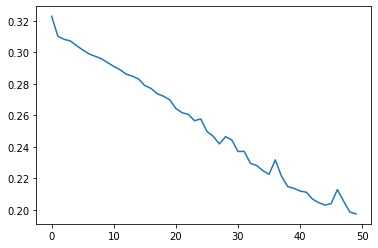

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


In [45]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,76,0.233696,0.181136,0.233696,0.414832
1,50,0.000000,0.000000,0.233696,0.233696
2,73,0.000000,0.000000,0.233696,0.233696
3,101,0.000000,0.000000,0.233696,0.233696
4,63,0.000000,0.000000,0.233696,0.233696
5,73,0.000000,0.000000,0.233696,0.233696
6,63,0.000000,0.000000,0.233696,0.233696
7,40,0.000000,0.000000,0.233696,0.233696
8,67,0.000000,0.000000,0.233696,0.233696
9,50,0.000000,0.000000,0.233696,0.233696


In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

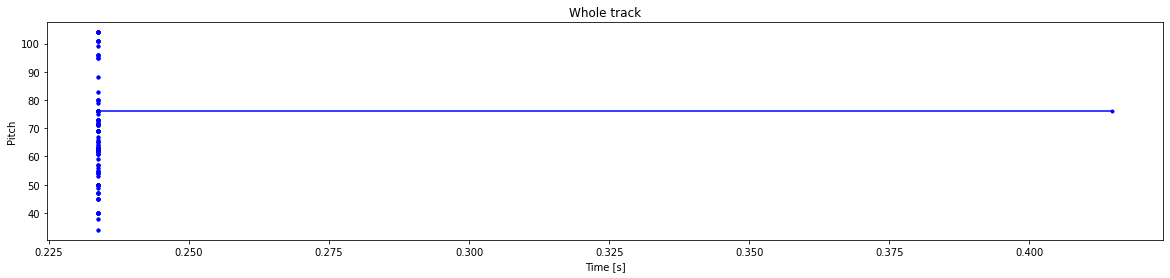

In [47]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

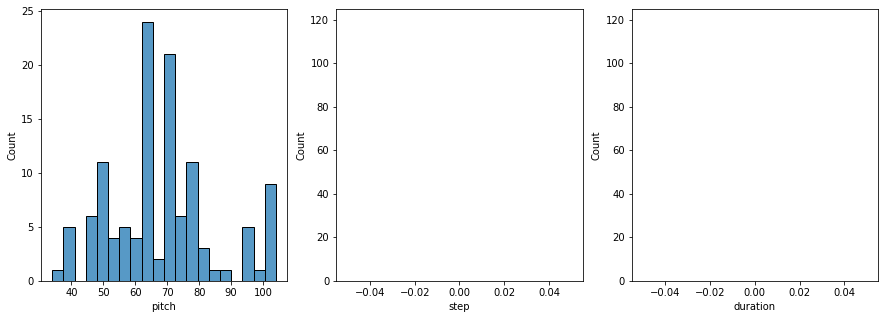

In [48]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).